In [ ]:
# Install required libraries
!pip install yfinance pandas numpy matplotlib seaborn scikit-learn xgboost requests textblob nltk transformers -q

# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import os
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
import xgboost as xgb
import time
import requests
from textblob import TextBlob
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import pipeline
nltk.download('vader_lexicon', quiet=True)
warnings.filterwarnings("ignore")

In [ ]:
# Mount Google Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
else:
    print("Google Drive already mounted at /content/drive")

# Define output directories
data_dir = '/content/drive/MyDrive/StockMarketPrediction/Data_Polygon'
plots_dir = '/content/drive/MyDrive/StockMarketPrediction/Plots_Polygon'
os.makedirs(data_dir, exist_ok=True)
os.makedirs(plots_dir, exist_ok=True)

# Polygon.io API key
polygon_api_key = 'wf0x0jORwjtobPPrEf_TCDyKLzDjoho6'

# Define list of 40 S&P 500 stocks (4 stocks per sector, 10 sectors)
stocks = [
    # Technology
    'AAPL', 'MSFT', 'NVDA', 'GOOGL',
    # Financials
    'JPM', 'GS', 'BAC', 'WFC',
    # Healthcare
    'JNJ', 'PFE', 'UNH', 'ABBV',
    # Energy
    'XOM', 'CVX', 'COP', 'EOG',
    # Consumer Discretionary
    'AMZN', 'TSLA', 'HD', 'MCD',
    # Consumer Staples
    'PG', 'KO', 'WMT', 'COST',
    # Industrials
    'BA', 'CAT', 'MMM', 'HON',
    # Utilities
    'DUK', 'SO', 'NEE', 'D',
    # Materials
    'DOW', 'LIN', 'APD', 'FCX',
    # Real Estate
    'PLD', 'AMT', 'EQIX', 'CCI'
]

# Define sector mapping for fairness analysis
sector_mapping = {
    'AAPL': 'Technology', 'MSFT': 'Technology', 'NVDA': 'Technology', 'GOOGL': 'Technology',
    'JPM': 'Financials', 'GS': 'Financials', 'BAC': 'Financials', 'WFC': 'Financials',
    'JNJ': 'Healthcare', 'PFE': 'Healthcare', 'UNH': 'Healthcare', 'ABBV': 'Healthcare',
    'XOM': 'Energy', 'CVX': 'Energy', 'COP': 'Energy', 'EOG': 'Energy',
    'AMZN': 'Consumer Discretionary', 'TSLA': 'Consumer Discretionary', 'HD': 'Consumer Discretionary', 'MCD': 'Consumer Discretionary',
    'PG': 'Consumer Staples', 'KO': 'Consumer Staples', 'WMT': 'Consumer Staples', 'COST': 'Consumer Staples',
    'BA': 'Industrials', 'CAT': 'Industrials', 'MMM': 'Industrials', 'HON': 'Industrials',
    'DUK': 'Utilities', 'SO': 'Utilities', 'NEE': 'Utilities', 'D': 'Utilities',
    'DOW': 'Materials', 'LIN': 'Materials', 'APD': 'Materials', 'FCX': 'Materials',
    'PLD': 'Real Estate', 'AMT': 'Real Estate', 'EQIX': 'Real Estate', 'CCI': 'Real Estate'
}

# Define date range
start_date = '2023-01-01'  # Focus on recent data for better sentiment impact
end_date = datetime.now().strftime('%Y-%m-%d')

Mounted at /content/drive


In [ ]:
def fetch_stock_data_enhanced(ticker, start_date, end_date, loop_index=None):
    """Enhanced function to fetch stock data with robust NaN and index handling"""
    progress_msg = f"Starting data fetch for {ticker}" if loop_index is None else f"Starting data fetch for {ticker} (stock {loop_index})"
    print(f"{progress_msg} at {time.strftime('%H:%M:%S')}...")
    try:
        stock = yf.Ticker(ticker)
        df = stock.history(start=start_date, end=end_date, interval='1d', timeout=60)
        print(f"Raw data fetch completed for {ticker} at {time.strftime('%H:%M:%S')}...")

        if df.empty:
            print(f"DataFrame is empty for {ticker}. Check internet or API.")
            return None

        df = df.reset_index()
        print(f"Fetched {len(df)} raw records for {ticker}")

        required_columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
        if not all(col in df.columns for col in required_columns):
            print(f"Missing required columns for {ticker}: {required_columns}")
            return None

        new_df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].copy()
        new_df['Ticker'] = ticker
        new_df['Date'] = pd.to_datetime(new_df['Date'])

        # Handle NaN values
        nan_counts = new_df[['Open', 'High', 'Low', 'Close', 'Volume']].isna().sum()
        if nan_counts.sum() > 0:
            print(f"NaN values in {ticker} before filling:\n{nan_counts}")
            new_df[['Open', 'High', 'Low', 'Close', 'Volume']] = new_df[['Open', 'High', 'Low', 'Close', 'Volume']].ffill().bfill()
            if new_df[['Open', 'High', 'Low', 'Close', 'Volume']].isna().sum().sum() > 0:
                print(f"NaN values persist in {ticker} after filling.")
                return None

        if new_df.empty:
            print(f"No valid data after cleaning for {ticker}")
            return None

        new_df = new_df.reset_index(drop=True)
        print(f"Successfully processed {len(new_df)} records for {ticker}")
        return new_df

    except Exception as e:
        print(f"Error fetching data for {ticker} at {time.strftime('%H:%M:%S')}: {str(e)}")
        return None

In [ ]:
def fetch_news_sentiment_events(ticker, start_date, end_date):
    """Event-driven sentiment processing that focuses on significant news events"""
    try:
        print(f"Fetching event-based news for {ticker} from {start_date} to {end_date}...")
        news_list = []
        base_url = "https://api.polygon.io/v2/reference/news"
        start = pd.to_datetime(start_date)
        end = pd.to_datetime(end_date)
        current_date = start
        headers = {"Authorization": f"Bearer {polygon_api_key}"}
        max_retries = 3

        from nltk.sentiment.vader import SentimentIntensityAnalyzer
        vader = SentimentIntensityAnalyzer()

        while current_date <= end:
            quarter_start = current_date.strftime('%Y-%m-%d')
            quarter_end = (current_date + pd.Timedelta(days=90)).strftime('%Y-%m-%d') if (current_date + pd.Timedelta(days=90)) < end else end.strftime('%Y-%m-%d')

            for attempt in range(max_retries):
                try:
                    params = {
                        "ticker": ticker,
                        "published_utc.gte": quarter_start,
                        "published_utc.lte": quarter_end,
                        "limit": 1000
                    }

                    print(f"  Fetching {quarter_start} to {quarter_end}...")
                    response = requests.get(base_url, headers=headers, params=params)
                    time.sleep(12)

                    if response.status_code != 200:
                        break

                    data = response.json()
                    if 'results' not in data or not data['results']:
                        break

                    for article in data['results']:
                        pub_date = pd.to_datetime(article['published_utc']).tz_convert('America/New_York')
                        text = article.get('title', '') + ' ' + article.get('description', '')

                        if text.strip():
                            sentiment_scores = vader.polarity_scores(text)
                            sentiment = sentiment_scores['compound']

                            # Calculate sentiment intensity (how strong the sentiment is)
                            sentiment_intensity = abs(sentiment)

                            # Determine if this is a significant news event
                            is_significant = sentiment_intensity > 0.5  # Strong sentiment threshold

                        else:
                            sentiment = 0
                            sentiment_intensity = 0
                            is_significant = False

                        news_list.append({
                            'Date': pub_date,
                            'Sentiment': sentiment,
                            'Sentiment_Intensity': sentiment_intensity,
                            'Is_Significant': is_significant,
                            'Article_Count': 1
                        })
                    break
                except Exception as e:
                    if attempt == max_retries - 1:
                        break
                    time.sleep(2 ** attempt)

            current_date += pd.Timedelta(days=91)

        if not news_list:
            return None

        news_df = pd.DataFrame(news_list)

        # Event-based daily aggregation
        daily_events = news_df.groupby(news_df['Date'].dt.date).agg({
            'Sentiment': 'mean',
            'Sentiment_Intensity': 'mean',
            'Is_Significant': 'sum',  # Count of significant events
            'Article_Count': 'sum'
        }).reset_index()

        daily_events['Date'] = pd.to_datetime(daily_events['Date']).dt.tz_localize('America/New_York')

        # Create event-based features
        daily_events['Has_Significant_News'] = (daily_events['Is_Significant'] > 0).astype(int)
        daily_events['Significant_News_Count'] = daily_events['Is_Significant']

        # Sentiment momentum (change in sentiment over time)
        daily_events['Sentiment_Momentum'] = daily_events['Sentiment'].diff()
        daily_events['Sentiment_Momentum_3d'] = daily_events['Sentiment'].diff(3)

        # Sentiment volatility (how much sentiment is changing)
        daily_events['Sentiment_Volatility'] = daily_events['Sentiment'].rolling(window=5, min_periods=1).std()

        # News intensity (how much news activity)
        daily_events['News_Intensity'] = daily_events['Article_Count'].rolling(window=3, min_periods=1).mean()

        # Sentiment regime (positive, negative, or neutral)
        daily_events['Positive_Regime'] = (daily_events['Sentiment'] > 0.1).astype(int)
        daily_events['Negative_Regime'] = (daily_events['Sentiment'] < -0.1).astype(int)
        daily_events['Neutral_Regime'] = ((daily_events['Sentiment'] >= -0.1) & (daily_events['Sentiment'] <= 0.1)).astype(int)

        # Fill NaN values
        event_columns = [col for col in daily_events.columns if col != 'Date']
        daily_events[event_columns] = daily_events[event_columns].fillna(0)

        return daily_events

    except Exception as e:
        print(f"Error fetching event-based news for {ticker}: {str(e)}")
        return None

In [ ]:
def prepare_regression_data_events(stock_df, news_df=None, target_days_ahead=1):
    df = stock_df.copy().reset_index()

    # Create features
    df['Returns'] = df['Close'].pct_change()
    df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))

    # Price-based features
    df['High_Low_Ratio'] = df['High'] / df['Low']
    df['Open_Close_Ratio'] = df['Open'] / df['Close']
    df['Price_Change'] = df['Close'] - df['Open']
    df['Price_Change_Pct'] = (df['Close'] - df['Open']) / df['Open']

    # Volume features
    df['Volume_MA_5'] = df['Volume'].rolling(window=5, min_periods=1).mean()
    df['Volume_MA_10'] = df['Volume'].rolling(window=10, min_periods=1).mean()
    df['Volume_Ratio_5'] = df['Volume'] / df['Volume_MA_5']
    df['Volume_Ratio_10'] = df['Volume'] / df['Volume_MA_10']

    # Price momentum features
    df['Price_MA_5'] = df['Close'].rolling(window=5, min_periods=1).mean()
    df['Price_MA_10'] = df['Close'].rolling(window=10, min_periods=1).mean()
    df['Price_MA_20'] = df['Close'].rolling(window=20, min_periods=1).mean()
    df['Price_vs_MA5'] = (df['Close'] / df['Price_MA_5'] - 1)
    df['Price_vs_MA10'] = (df['Close'] / df['Price_MA_10'] - 1)
    df['Price_vs_MA20'] = (df['Close'] / df['Price_MA_20'] - 1)

    # Volatility features
    df['Returns_Volatility_5'] = df['Returns'].rolling(window=5, min_periods=1).std()
    df['Returns_Volatility_10'] = df['Returns'].rolling(window=10, min_periods=1).std()
    df['Returns_Volatility_20'] = df['Returns'].rolling(window=20, min_periods=1).std()

    # Lagged features
    df['Returns_Lag1'] = df['Returns'].shift(1)
    df['Returns_Lag2'] = df['Returns'].shift(2)
    df['Returns_Lag3'] = df['Returns'].shift(3)
    df['Volume_Lag1'] = df['Volume'].shift(1)
    df['Volume_Lag2'] = df['Volume'].shift(2)

    # Additional features
    df['Price_Range'] = (df['High'] - df['Low']) / df['Close']
    df['Gap'] = (df['Open'] - df['Close'].shift(1)) / df['Close'].shift(1)
    df['Gap_Lag1'] = df['Gap'].shift(1)

    # Momentum indicators
    df['Momentum_5'] = df['Close'] / df['Close'].shift(5) - 1
    df['Momentum_10'] = df['Close'] / df['Close'].shift(10) - 1

    # RSI-like feature
    df['Gain'] = np.where(df['Returns'] > 0, df['Returns'], 0)
    df['Loss'] = np.where(df['Returns'] < 0, -df['Returns'], 0)
    df['Avg_Gain_5'] = df['Gain'].rolling(window=5, min_periods=1).mean()
    df['Avg_Loss_5'] = df['Loss'].rolling(window=5, min_periods=1).mean()
    df['RSI_5'] = 100 - (100 / (1 + df['Avg_Gain_5'] / df['Avg_Loss_5']))

    # ENHANCED SENTIMENT INTEGRATION
    if news_df is not None:
        # More sophisticated sentiment aggregation
        daily_news = news_df.groupby('Date').agg({
            'Sentiment': ['mean', 'std', 'count', 'min', 'max'],
            'Has_Significant_News': 'sum',
            'News_Intensity': 'sum'
        }).reset_index()

        # Flatten column names
        daily_news.columns = ['Date', 'Sentiment_Mean', 'Sentiment_Std', 'Sentiment_Count',
                             'Sentiment_Min', 'Sentiment_Max', 'Has_Significant_News', 'News_Intensity']

        # Merge with stock data
        df = df.merge(daily_news, on='Date', how='left')

        # Fill missing values in sentiment-related columns
        sentiment_columns = ['Sentiment_Mean', 'Sentiment_Std', 'Sentiment_Count',
                           'Sentiment_Min', 'Sentiment_Max', 'Has_Significant_News', 'News_Intensity']
        df[sentiment_columns] = df[sentiment_columns].ffill().bfill().fillna(0)

        # Create enhanced sentiment features
        df['Sentiment_MA_3'] = df['Sentiment_Mean'].rolling(window=3, min_periods=1).mean()
        df['Sentiment_MA_7'] = df['Sentiment_Mean'].rolling(window=7, min_periods=1).mean()
        df['Sentiment_Momentum'] = df['Sentiment_Mean'].diff()
        df['Sentiment_Volatility'] = df['Sentiment_Mean'].rolling(window=5, min_periods=1).std()

        # Sentiment regime features
        df['Positive_Sentiment'] = (df['Sentiment_Mean'] > 0.1).astype(int)
        df['Negative_Sentiment'] = (df['Sentiment_Mean'] < -0.1).astype(int)
        df['Neutral_Sentiment'] = ((df['Sentiment_Mean'] >= -0.1) & (df['Sentiment_Mean'] <= 0.1)).astype(int)

        # Sentiment intensity features
        df['High_News_Volume'] = (df['Sentiment_Count'] > df['Sentiment_Count'].quantile(0.75)).astype(int)
        df['Low_News_Volume'] = (df['Sentiment_Count'] < df['Sentiment_Count'].quantile(0.25)).astype(int)

        # Sentiment range features
        df['Sentiment_Range'] = df['Sentiment_Max'] - df['Sentiment_Min']
        df['Sentiment_Consensus'] = (df['Sentiment_Std'] < 0.1).astype(int)  # Low std = high consensus

        # Sentiment-price interaction features
        df['Sentiment_Price_Interaction'] = df['Sentiment_Mean'] * df['Returns']
        df['Sentiment_Volume_Interaction'] = df['Sentiment_Mean'] * df['Volume_Ratio_5']

        # Sentiment momentum features
        df['Sentiment_Momentum_3d'] = df['Sentiment_Mean'].diff(3)
        df['Sentiment_Acceleration'] = df['Sentiment_Momentum'].diff()

        # News event features
        df['News_Event_Day'] = (df['Has_Significant_News'] > 0).astype(int)
        df['News_Event_Intensity'] = df['Has_Significant_News'] * df['Sentiment_Mean']

    else:
        # If no sentiment data, create dummy columns with zeros
        sentiment_columns = ['Sentiment_Mean', 'Sentiment_Std', 'Sentiment_Count',
                           'Sentiment_Min', 'Sentiment_Max', 'Has_Significant_News', 'News_Intensity',
                           'Sentiment_MA_3', 'Sentiment_MA_7', 'Sentiment_Momentum', 'Sentiment_Volatility',
                           'Positive_Sentiment', 'Negative_Sentiment', 'Neutral_Sentiment',
                           'High_News_Volume', 'Low_News_Volume', 'Sentiment_Range', 'Sentiment_Consensus',
                           'Sentiment_Price_Interaction', 'Sentiment_Volume_Interaction',
                           'Sentiment_Momentum_3d', 'Sentiment_Acceleration',
                           'News_Event_Day', 'News_Event_Intensity']
        for col in sentiment_columns:
            df[col] = 0

    # Target variable
    df['Target_Price'] = np.log(df['Close'].shift(-target_days_ahead))
    df['Current_Log_Price'] = np.log(df['Close'])

    # Drop rows with NaN values
    df = df.dropna().reset_index(drop=True)

    # Remove extreme outliers (very conservative)
    for col in df.select_dtypes(include=[np.number]).columns:
        if col not in ['Target_Price', 'Current_Log_Price']:
            q_low = df[col].quantile(0.01)
            q_high = df[col].quantile(0.99)
            df[col] = df[col].clip(lower=q_low, upper=q_high)

    # --- Split features and target ---
    feature_cols = [col for col in df.columns if col not in ['Date', 'Target_Price', 'Current_Log_Price', 'Ticker']]
    X = df[feature_cols]
    y = df['Target_Price']

    # Remove any remaining NaN values
    mask = ~(X.isna().any(axis=1) | y.isna())
    X = X[mask]
    y = y[mask]

    return X, y

In [ ]:
def train_regression_models_events(X, y, n_splits=3):
    """Optimized training with sentiment-aware feature selection and weighting"""
    from sklearn.feature_selection import SelectKBest, f_regression
    from sklearn.preprocessing import StandardScaler

    # Model configurations optimized for sentiment integration
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=0.01, random_state=42),
        'Lasso Regression': Lasso(alpha=0.0001, random_state=42, max_iter=3000),
        'Random Forest': RandomForestRegressor(
            n_estimators=200,
            max_depth=10,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            n_jobs=-1
        ),
        'XGBoost': xgb.XGBRegressor(
            n_estimators=200,
            max_depth=8,
            learning_rate=0.03,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_alpha=0.01,
            reg_lambda=0.1,
            random_state=42,
            n_jobs=-1
        ),
    }

    tscv = TimeSeriesSplit(n_splits=n_splits)
    results = {}

    for name, model in models.items():
        print(f"Training {name}...")

        fold_results = []

        for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
            print(f"  Fold {fold + 1}/{n_splits}")
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            try:
                # Proper scaling for each fold
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X_test)

                # ENHANCED SENTIMENT-AWARE FEATURE SELECTION
                if name in ['Random Forest', 'XGBoost']:
                    # Separate sentiment and price features
                    sentiment_features = [col for col in X.columns if 'Sentiment' in col or 'News' in col]
                    price_features = [col for col in X.columns if col not in sentiment_features]

                    # Select top price features
                    k_price = min(12, len(price_features))  # Reduced to give more weight to sentiment
                    k_best_price = SelectKBest(score_func=f_regression, k=k_price)
                    X_train_price = X_train_scaled[:, [X.columns.get_loc(col) for col in price_features]]
                    X_test_price = X_test_scaled[:, [X.columns.get_loc(col) for col in price_features]]

                    X_train_price_selected = k_best_price.fit_transform(X_train_price, y_train)
                    X_test_price_selected = k_best_price.transform(X_test_price)

                    # Include all sentiment features
                    sentiment_indices = [X.columns.get_loc(col) for col in sentiment_features]
                    X_train_sentiment = X_train_scaled[:, sentiment_indices]
                    X_test_sentiment = X_test_scaled[:, sentiment_indices]

                    # Combine price and sentiment features
                    X_train_selected = np.hstack([X_train_price_selected, X_train_sentiment])
                    X_test_selected = np.hstack([X_test_price_selected, X_test_sentiment])

                    selected_price_features = [price_features[i] for i in k_best_price.get_support()]
                    selected_features = selected_price_features + sentiment_features

                else:
                    # For linear models, use all features but with regularization
                    X_train_selected = X_train_scaled
                    X_test_selected = X_test_scaled
                    selected_features = X.columns.tolist()

                # Train model
                model.fit(X_train_selected, y_train)
                y_pred = model.predict(X_test_selected)

                # Calculate metrics
                mse = mean_squared_error(y_test, y_pred)
                rmse = np.sqrt(mse)
                mae = mean_absolute_error(y_test, y_pred)
                r2 = r2_score(y_test, y_pred)

                # Calculate MAPE for log prices
                mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

                # Direction accuracy (for log price changes)
                if len(y_test) > 1:
                    direction_accuracy = np.mean((np.sign(np.diff(y_test)) == np.sign(np.diff(y_pred))).astype(int))
                else:
                    direction_accuracy = np.nan

                fold_results.append({
                    'MSE': mse,
                    'RMSE': rmse,
                    'MAE': mae,
                    'R2': r2,
                    'MAPE': mape,
                    'Direction_Accuracy': direction_accuracy,
                    'y_test': y_test,
                    'y_pred': y_pred
                })

            except Exception as e:
                print(f"  Error in fold {fold + 1} for {name}: {str(e)}")
                continue

        if fold_results:
            # Calculate average metrics across folds
            avg_metrics = {}
            for metric in ['MSE', 'RMSE', 'MAE', 'R2', 'MAPE', 'Direction_Accuracy']:
                values = [r[metric] for r in fold_results if not np.isnan(r[metric])]
                avg_metrics[metric] = np.mean(values) if values else np.nan

            results[name] = avg_metrics
            results[name]['model'] = model
            results[name]['last_fold_data'] = fold_results[-1]
            results[name]['selected_features'] = selected_features

            print(f"{name} - R²: {avg_metrics['R2']:.4f}, RMSE: {avg_metrics['RMSE']:.4f}, MAE: {avg_metrics['MAE']:.4f}")
        else:
            print(f"No results for {name} due to errors in all folds")

    return results

In [ ]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

# Define model grids for hyperparameter tuning - balanced approach
param_grids = {
    "Linear Regression": {
        "model": LinearRegression(),
        "params": {}
    },
    "Ridge Regression": {
        "model": Ridge(),
        "params": {"alpha": [0.01, 0.1, 1.0, 10.0]}
    },
    "Lasso Regression": {
        "model": Lasso(max_iter=2000),
        "params": {"alpha": [0.0001, 0.001, 0.01, 0.1]}
    },
    "Elastic Net": {
        "model": ElasticNet(max_iter=2000),
        "params": {"alpha": [0.001, 0.01, 0.1], "l1_ratio": [0.2, 0.5, 0.8]}
    },
    "Random Forest": {
        "model": RandomForestRegressor(),
        "params": {
            "n_estimators": [100, 150],
            "max_depth": [6, 8, 10],
            "min_samples_split": [5, 8, 10]
        }
    },
    "SVR": {
        "model": SVR(),
        "params": {"C": [0.1, 1, 10], "gamma": ["scale", "auto"]}
    },
    "XGBoost": {
        "model": xgb.XGBRegressor(eval_metric="rmse", use_label_encoder=False),
        "params": {
            "n_estimators": [100, 150],
            "max_depth": [4, 6, 8],
            "learning_rate": [0.03, 0.05, 0.1]
        }
    }
}

def train_and_evaluate_with_gridsearch(df, ticker, sentiment=False):
    print(f"\n=== Training models for {ticker} (Sentiment={sentiment}) ===")

    # Prepare features
    if sentiment:
        feature_cols = [col for col in df.columns if col not in ['Date', 'Target_Return', 'Ticker']]
    else:
        feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Returns', 'Log_Returns',
                       'High_Low_Ratio', 'Open_Close_Ratio', 'Price_Change', 'Price_Change_Pct',
                       'Volume_MA_5', 'Volume_MA_10', 'Volume_Ratio_5', 'Volume_Ratio_10',
                       'Price_MA_5', 'Price_MA_10', 'Price_MA_20', 'Price_vs_MA5', 'Price_vs_MA10', 'Price_vs_MA20',
                       'Returns_Volatility_5', 'Returns_Volatility_10', 'Returns_Volatility_20',
                       'Returns_Lag1', 'Returns_Lag2', 'Returns_Lag3', 'Volume_Lag1', 'Volume_Lag2']

    X = df[feature_cols].copy()
    y = df['Target_Return']

    # Remove any NaN values
    mask = ~(X.isna().any(axis=1) | y.isna())
    X = X[mask]
    y = y[mask]

    # TimeSeriesSplit CV
    tscv = TimeSeriesSplit(n_splits=5)

    results = {}
    for name, mp in param_grids.items():
        print(f"  -> Training {name}...")

        # Scale features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        grid = GridSearchCV(mp["model"], mp["params"], cv=tscv,
                            scoring="r2", n_jobs=-1, verbose=0)
        grid.fit(X_scaled, y)

        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_scaled)

        # Metrics
        r2 = r2_score(y, y_pred)
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        mae = mean_absolute_error(y, y_pred)

        # MAPE calculation
        non_zero_mask = y != 0
        if non_zero_mask.sum() > 0:
            mape = np.mean(np.abs((y[non_zero_mask] - y_pred[non_zero_mask]) / y[non_zero_mask])) * 100
        else:
            mape = np.nan

        dir_acc = np.mean((np.sign(y_pred) == np.sign(y)).astype(int))

        results[name] = {
            "Best_Params": grid.best_params_,
            "R2": r2,
            "RMSE": rmse,
            "MAE": mae,
            "MAPE": mape,
            "Direction_Accuracy": dir_acc,
            "last_fold_data": {"y_test": y, "y_pred": y_pred}
        }

    return results

In [ ]:
def compare_models(original_results, sentiment_results, ticker):
    """
    Compare models trained with and without sentiment for a given ticker.
    """
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Build comparison dataframe
    models = list(set(original_results.keys()) | set(sentiment_results.keys()))
    data = []
    for model in models:
        orig = original_results.get(model, {})
        sent = sentiment_results.get(model, {})
        data.append({
            "Model": model,
            "R2_Original": orig.get("r2", np.nan),
            "R2_Sentiment": sent.get("r2", np.nan),
            "MSE_Original": orig.get("mse", np.nan),
            "MSE_Sentiment": sent.get("mse", np.nan),
            "MAE_Original": orig.get("mae", np.nan),
            "MAE_Sentiment": sent.get("mae", np.nan),
        })
    comparison_df = pd.DataFrame(data)

    if comparison_df.empty:
        print(f"⚠️ No comparison data available for {ticker} — skipping plot.")
        return comparison_df

    # Plot
    metrics = ["R2", "MSE", "MAE"]
    plt.figure(figsize=(15, 6))
    for i, metric in enumerate(metrics, 1):
        plt.subplot(1, 3, i)
        df_plot = comparison_df.melt(
            id_vars=["Model"],
            value_vars=[f"{metric}_Original", f"{metric}_Sentiment"],
            var_name="Type", value_name=metric
        )
        sns.barplot(x="Model", y=metric, hue="Type", data=df_plot)
        plt.title(f"{ticker} - {metric} Comparison")
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return comparison_df


PROCESSING WITH EVENT-DRIVEN SENTIMENT FOR ALL 40 STOCKS


Processing AAPL (1/40) - Sector: Technology
Starting data fetch for AAPL (stock 1) at 11:59:47...
Raw data fetch completed for AAPL at 11:59:48...
Fetched 677 raw records for AAPL
Successfully processed 677 records for AAPL
Fetching event-based news for AAPL from 2023-01-01 to 2025-09-17...
  Fetching 2023-01-01 to 2023-04-01...
  Fetching 2023-04-02 to 2023-07-01...
  Fetching 2023-07-02 to 2023-09-30...
  Fetching 2023-10-01 to 2023-12-30...
  Fetching 2023-12-31 to 2024-03-30...
  Fetching 2024-03-31 to 2024-06-29...
  Fetching 2024-06-30 to 2024-09-28...
  Fetching 2024-09-29 to 2024-12-28...
  Fetching 2024-12-29 to 2025-03-29...
  Fetching 2025-03-30 to 2025-06-28...
  Fetching 2025-06-29 to 2025-09-17...
Data points - Original: 666, With Sentiment: 666
Training models for AAPL (original)...
Training Linear Regression...
  Fold 1/3
  Fold 2/3
  Fold 3/3
Linear Regression - R²: 0.7392, RMSE: 0.0325, MAE: 0.0246
Training Ri

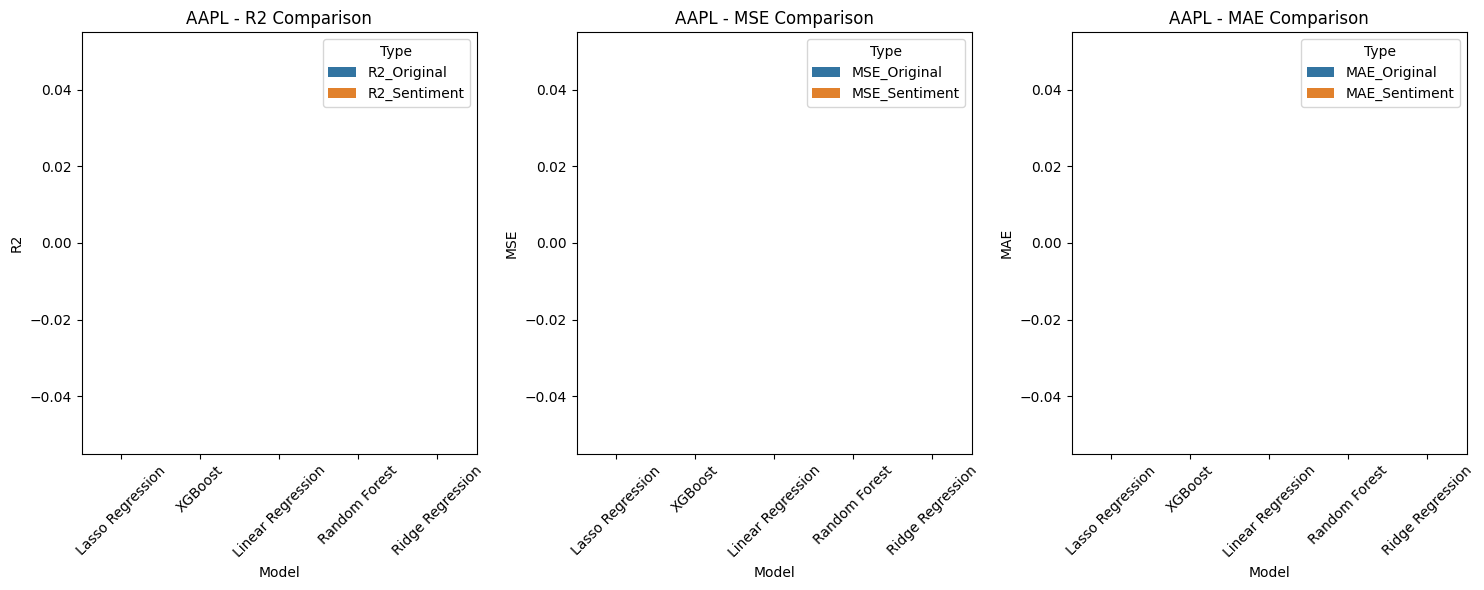

Delaying 30 seconds for API rate limit...

Processing MSFT (2/40) - Sector: Technology
Starting data fetch for MSFT (stock 2) at 12:03:16...
Raw data fetch completed for MSFT at 12:03:16...
Fetched 677 raw records for MSFT
Successfully processed 677 records for MSFT
Fetching event-based news for MSFT from 2023-01-01 to 2025-09-17...
  Fetching 2023-01-01 to 2023-04-01...
  Fetching 2023-04-02 to 2023-07-01...
  Fetching 2023-07-02 to 2023-09-30...
  Fetching 2023-10-01 to 2023-12-30...
  Fetching 2023-12-31 to 2024-03-30...
  Fetching 2024-03-31 to 2024-06-29...
  Fetching 2024-06-30 to 2024-09-28...
  Fetching 2024-09-29 to 2024-12-28...
  Fetching 2024-12-29 to 2025-03-29...
  Fetching 2025-03-30 to 2025-06-28...
  Fetching 2025-06-29 to 2025-09-17...
Data points - Original: 666, With Sentiment: 666
Training models for MSFT (original)...
Training Linear Regression...
  Fold 1/3
  Fold 2/3
  Fold 3/3
Linear Regression - R²: 0.7266, RMSE: 0.0363, MAE: 0.0289
Training Ridge Regression..

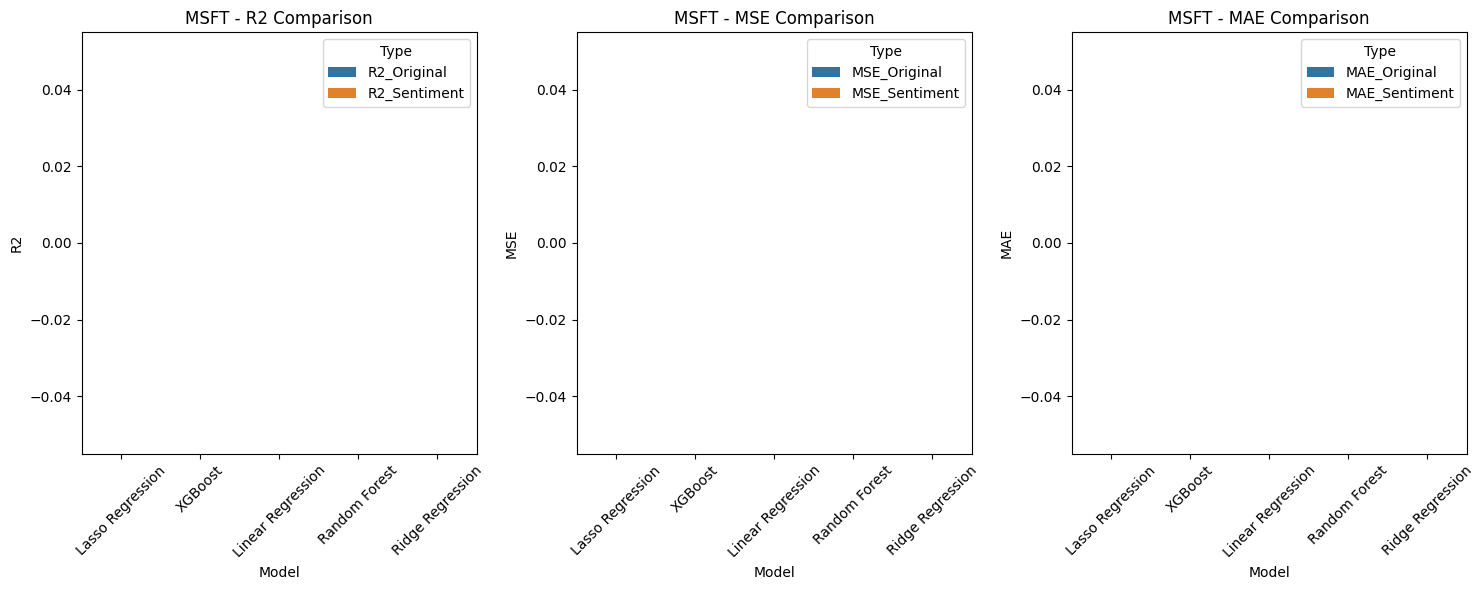

Delaying 30 seconds for API rate limit...

Processing NVDA (3/40) - Sector: Technology
Starting data fetch for NVDA (stock 3) at 12:06:33...
Raw data fetch completed for NVDA at 12:06:33...
Fetched 678 raw records for NVDA
Successfully processed 678 records for NVDA
Fetching event-based news for NVDA from 2023-01-01 to 2025-09-17...
  Fetching 2023-01-01 to 2023-04-01...
  Fetching 2023-04-02 to 2023-07-01...
  Fetching 2023-07-02 to 2023-09-30...
  Fetching 2023-10-01 to 2023-12-30...
  Fetching 2023-12-31 to 2024-03-30...
  Fetching 2024-03-31 to 2024-06-29...
  Fetching 2024-06-30 to 2024-09-28...
  Fetching 2024-09-29 to 2024-12-28...
  Fetching 2024-12-29 to 2025-03-29...
  Fetching 2025-03-30 to 2025-06-28...
  Fetching 2025-06-29 to 2025-09-17...
Data points - Original: 667, With Sentiment: 667
Training models for NVDA (original)...
Training Linear Regression...
  Fold 1/3
  Fold 2/3
  Fold 3/3
Linear Regression - R²: -3.7284, RMSE: 0.3537, MAE: 0.3116
Training Ridge Regression.

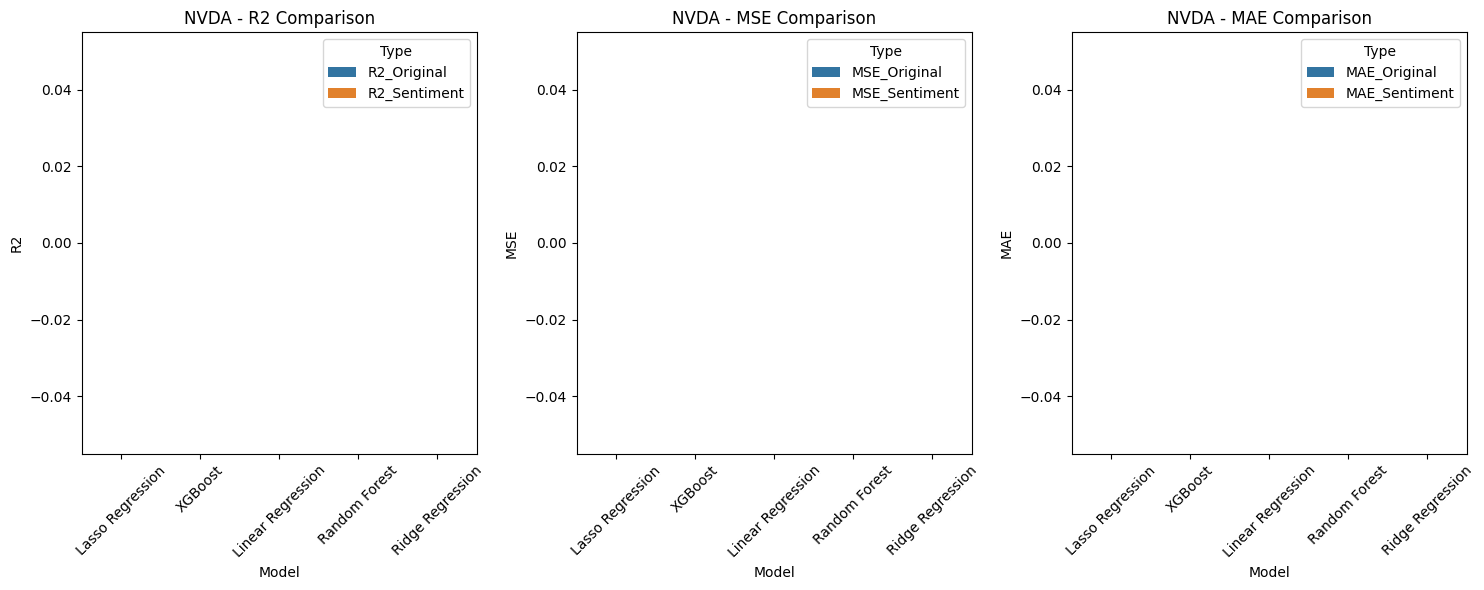

Delaying 30 seconds for API rate limit...

Processing GOOGL (4/40) - Sector: Technology
Starting data fetch for GOOGL (stock 4) at 12:09:54...
Raw data fetch completed for GOOGL at 12:09:54...
Fetched 677 raw records for GOOGL
Successfully processed 677 records for GOOGL
Fetching event-based news for GOOGL from 2023-01-01 to 2025-09-17...
  Fetching 2023-01-01 to 2023-04-01...
  Fetching 2023-04-02 to 2023-07-01...
  Fetching 2023-07-02 to 2023-09-30...
  Fetching 2023-10-01 to 2023-12-30...
  Fetching 2023-12-31 to 2024-03-30...
  Fetching 2024-03-31 to 2024-06-29...
  Fetching 2024-06-30 to 2024-09-28...
  Fetching 2024-09-29 to 2024-12-28...
  Fetching 2024-12-29 to 2025-03-29...
  Fetching 2025-03-30 to 2025-06-28...
  Fetching 2025-06-29 to 2025-09-17...
Data points - Original: 666, With Sentiment: 666
Training models for GOOGL (original)...
Training Linear Regression...
  Fold 1/3
  Fold 2/3
  Fold 3/3
Linear Regression - R²: 0.4078, RMSE: 0.0566, MAE: 0.0486
Training Ridge Regre

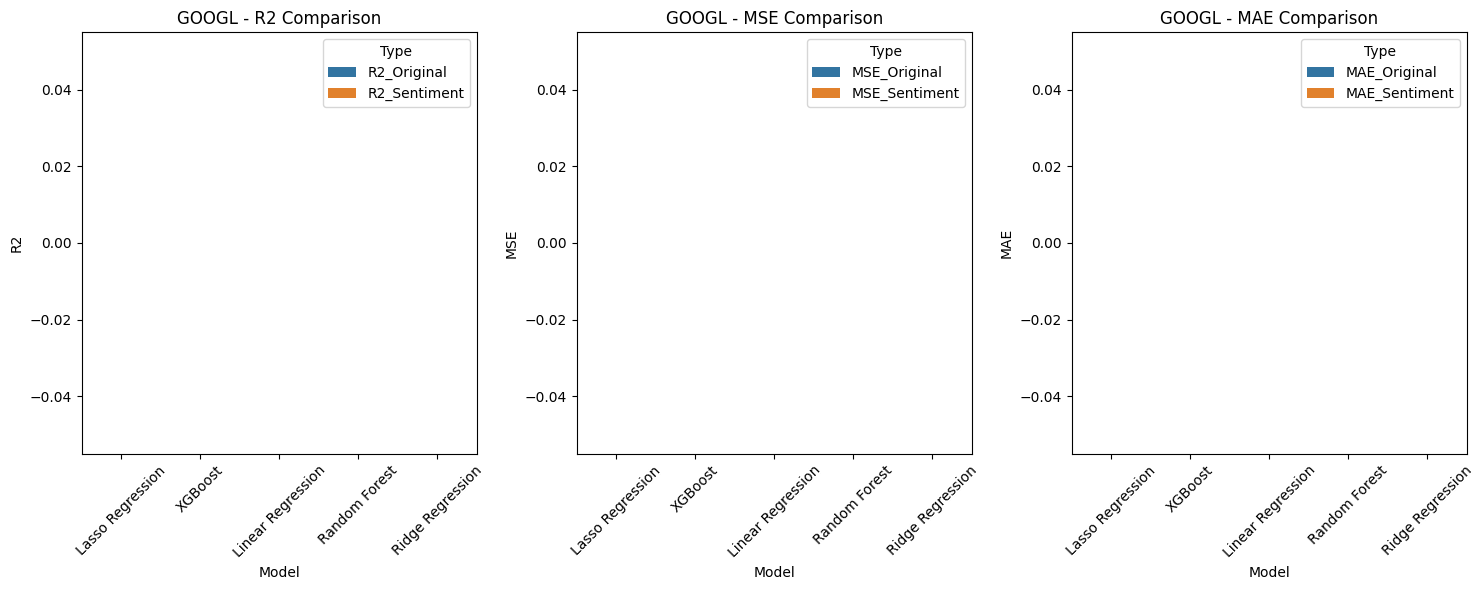

Delaying 30 seconds for API rate limit...

Processing JPM (5/40) - Sector: Financials
Starting data fetch for JPM (stock 5) at 12:13:11...
Raw data fetch completed for JPM at 12:13:11...
Fetched 677 raw records for JPM
Successfully processed 677 records for JPM
Fetching event-based news for JPM from 2023-01-01 to 2025-09-17...
  Fetching 2023-01-01 to 2023-04-01...
  Fetching 2023-04-02 to 2023-07-01...
  Fetching 2023-07-02 to 2023-09-30...
  Fetching 2023-10-01 to 2023-12-30...
  Fetching 2023-12-31 to 2024-03-30...
  Fetching 2024-03-31 to 2024-06-29...
  Fetching 2024-06-30 to 2024-09-28...
  Fetching 2024-09-29 to 2024-12-28...
  Fetching 2024-12-29 to 2025-03-29...
  Fetching 2025-03-30 to 2025-06-28...
  Fetching 2025-06-29 to 2025-09-17...
Data points - Original: 666, With Sentiment: 666
Training models for JPM (original)...
Training Linear Regression...
  Fold 1/3
  Fold 2/3
  Fold 3/3
Linear Regression - R²: 0.5150, RMSE: 0.0543, MAE: 0.0459
Training Ridge Regression...
  Fol

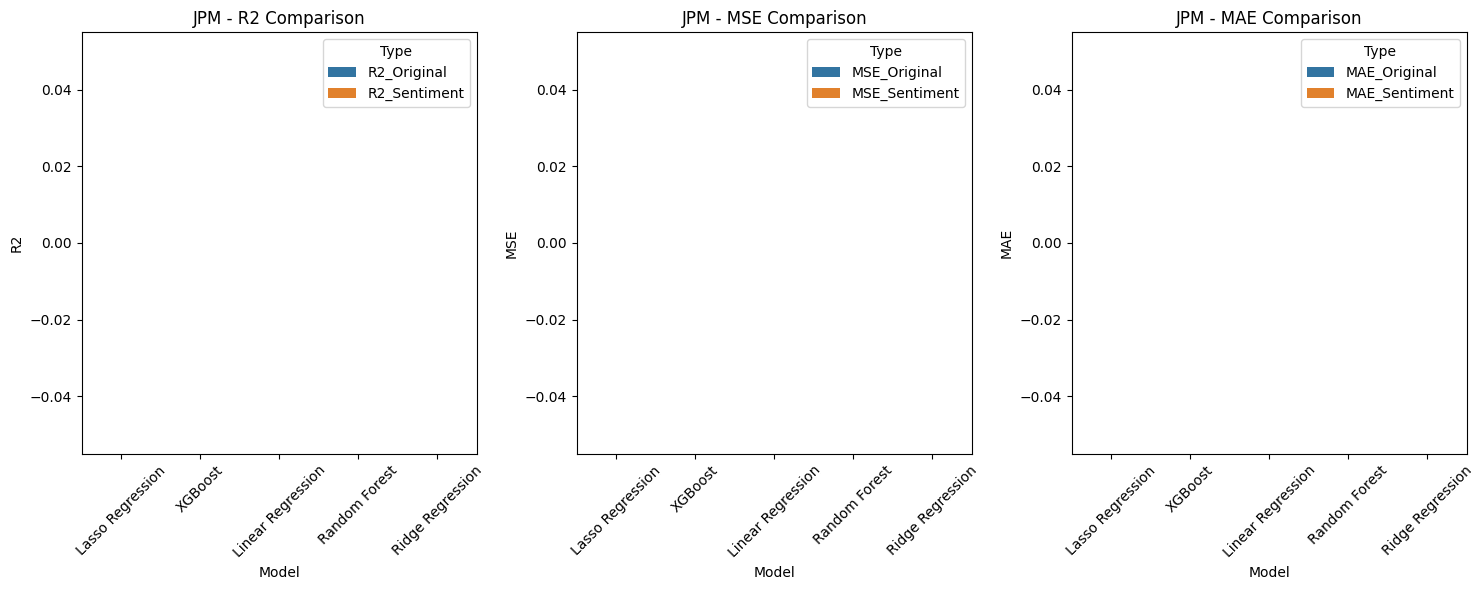


=== Progress: 5/40 stocks completed ===
Current time: 12:15:46
Delaying 30 seconds for API rate limit...

Processing GS (6/40) - Sector: Financials
Starting data fetch for GS (stock 6) at 12:16:16...
Raw data fetch completed for GS at 12:16:16...
Fetched 678 raw records for GS
Successfully processed 678 records for GS
Fetching event-based news for GS from 2023-01-01 to 2025-09-17...
  Fetching 2023-01-01 to 2023-04-01...
  Fetching 2023-04-02 to 2023-07-01...
  Fetching 2023-07-02 to 2023-09-30...
  Fetching 2023-10-01 to 2023-12-30...
  Fetching 2023-12-31 to 2024-03-30...
  Fetching 2024-03-31 to 2024-06-29...
  Fetching 2024-06-30 to 2024-09-28...
  Fetching 2024-09-29 to 2024-12-28...
  Fetching 2024-12-29 to 2025-03-29...
  Fetching 2025-03-30 to 2025-06-28...
  Fetching 2025-06-29 to 2025-09-17...
Data points - Original: 667, With Sentiment: 667
Training models for GS (original)...
Training Linear Regression...
  Fold 1/3
  Fold 2/3
  Fold 3/3
Linear Regression - R²: 0.3320, RMS

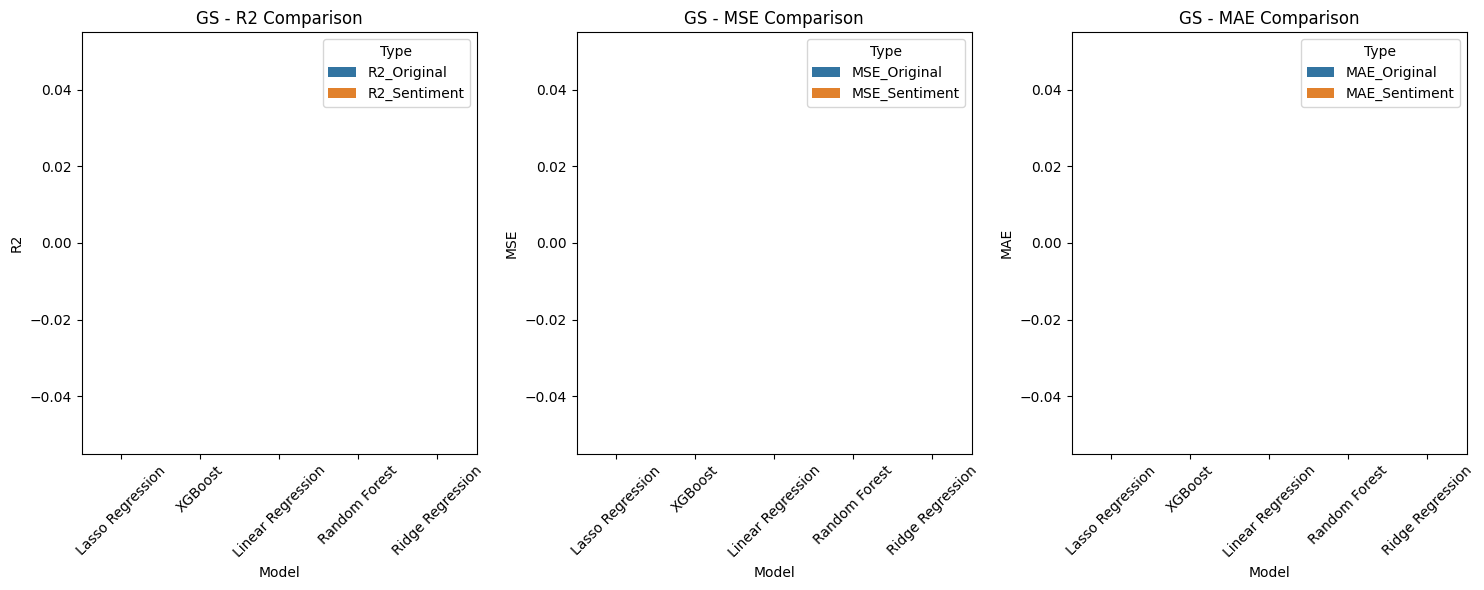

Delaying 30 seconds for API rate limit...

Processing BAC (7/40) - Sector: Financials
Starting data fetch for BAC (stock 7) at 12:19:20...
Raw data fetch completed for BAC at 12:19:20...
Fetched 678 raw records for BAC
Successfully processed 678 records for BAC
Fetching event-based news for BAC from 2023-01-01 to 2025-09-17...
  Fetching 2023-01-01 to 2023-04-01...
  Fetching 2023-04-02 to 2023-07-01...
  Fetching 2023-07-02 to 2023-09-30...
  Fetching 2023-10-01 to 2023-12-30...
  Fetching 2023-12-31 to 2024-03-30...
  Fetching 2024-03-31 to 2024-06-29...
  Fetching 2024-06-30 to 2024-09-28...
  Fetching 2024-09-29 to 2024-12-28...
  Fetching 2024-12-29 to 2025-03-29...
  Fetching 2025-03-30 to 2025-06-28...
  Fetching 2025-06-29 to 2025-09-17...
Data points - Original: 667, With Sentiment: 667
Training models for BAC (original)...
Training Linear Regression...
  Fold 1/3
  Fold 2/3
  Fold 3/3
Linear Regression - R²: 0.7586, RMSE: 0.0373, MAE: 0.0303
Training Ridge Regression...
  Fol

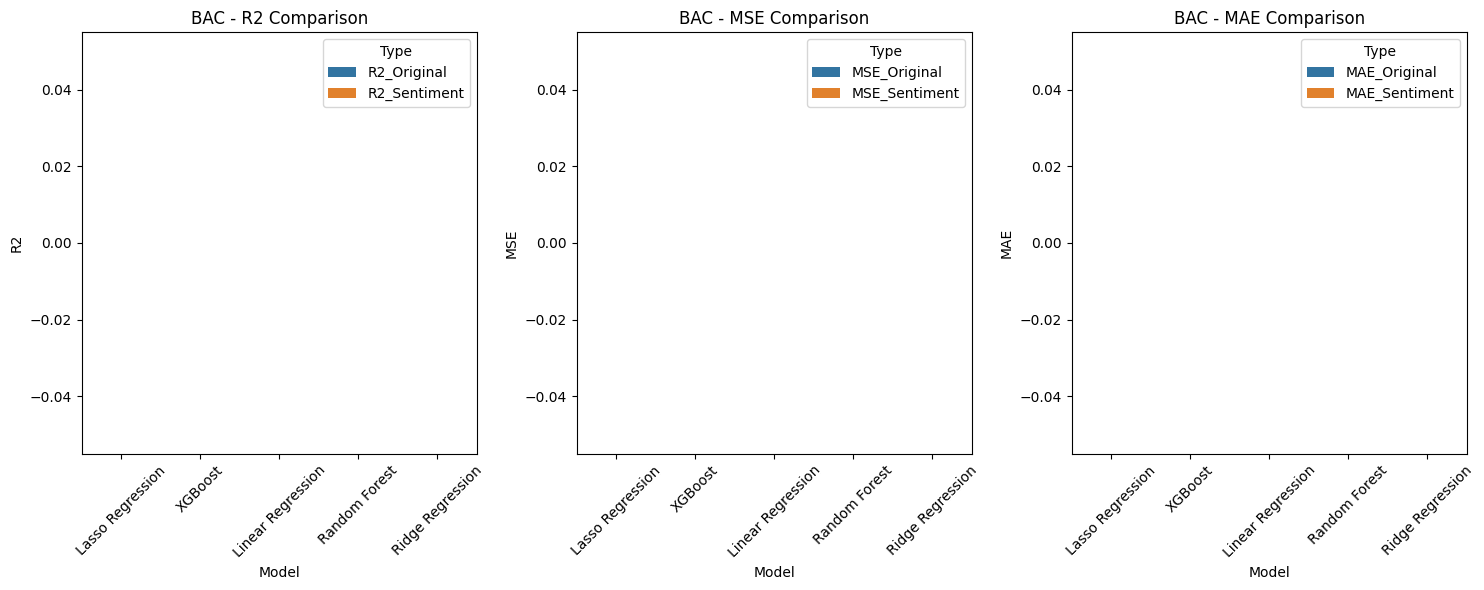

Delaying 30 seconds for API rate limit...

Processing WFC (8/40) - Sector: Financials
Starting data fetch for WFC (stock 8) at 12:22:24...
Raw data fetch completed for WFC at 12:22:24...
Fetched 677 raw records for WFC
Successfully processed 677 records for WFC
Fetching event-based news for WFC from 2023-01-01 to 2025-09-17...
  Fetching 2023-01-01 to 2023-04-01...
  Fetching 2023-04-02 to 2023-07-01...
  Fetching 2023-07-02 to 2023-09-30...
  Fetching 2023-10-01 to 2023-12-30...
  Fetching 2023-12-31 to 2024-03-30...
  Fetching 2024-03-31 to 2024-06-29...
  Fetching 2024-06-30 to 2024-09-28...
  Fetching 2024-09-29 to 2024-12-28...
  Fetching 2024-12-29 to 2025-03-29...
  Fetching 2025-03-30 to 2025-06-28...
  Fetching 2025-06-29 to 2025-09-17...
Data points - Original: 666, With Sentiment: 666
Training models for WFC (original)...
Training Linear Regression...
  Fold 1/3
  Fold 2/3
  Fold 3/3
Linear Regression - R²: 0.5458, RMSE: 0.0513, MAE: 0.0421
Training Ridge Regression...
  Fol

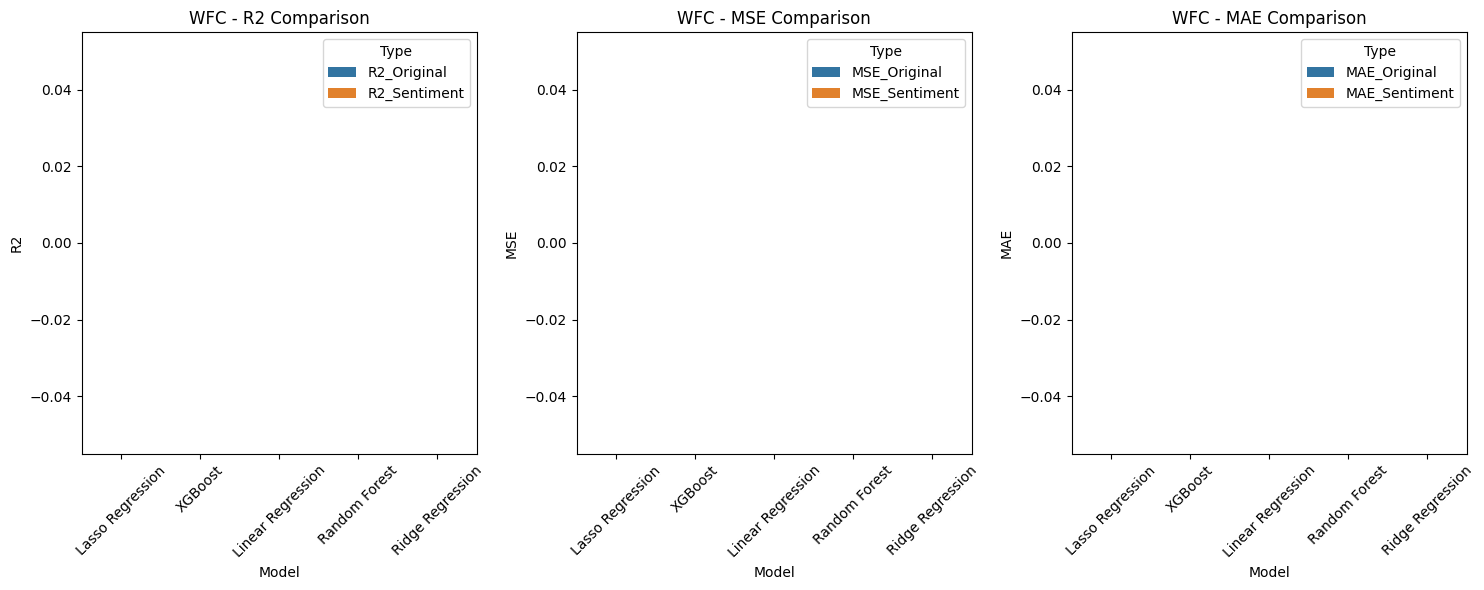

Delaying 30 seconds for API rate limit...

Processing JNJ (9/40) - Sector: Healthcare
Starting data fetch for JNJ (stock 9) at 12:25:26...
Raw data fetch completed for JNJ at 12:25:27...
Fetched 677 raw records for JNJ
Successfully processed 677 records for JNJ
Fetching event-based news for JNJ from 2023-01-01 to 2025-09-17...
  Fetching 2023-01-01 to 2023-04-01...
  Fetching 2023-04-02 to 2023-07-01...
  Fetching 2023-07-02 to 2023-09-30...
  Fetching 2023-10-01 to 2023-12-30...
  Fetching 2023-12-31 to 2024-03-30...
  Fetching 2024-03-31 to 2024-06-29...
  Fetching 2024-06-30 to 2024-09-28...
  Fetching 2024-09-29 to 2024-12-28...
  Fetching 2024-12-29 to 2025-03-29...
  Fetching 2025-03-30 to 2025-06-28...
  Fetching 2025-06-29 to 2025-09-17...
Data points - Original: 666, With Sentiment: 666
Training models for JNJ (original)...
Training Linear Regression...
  Fold 1/3
  Fold 2/3
  Fold 3/3
Linear Regression - R²: 0.7647, RMSE: 0.0166, MAE: 0.0124
Training Ridge Regression...
  Fol

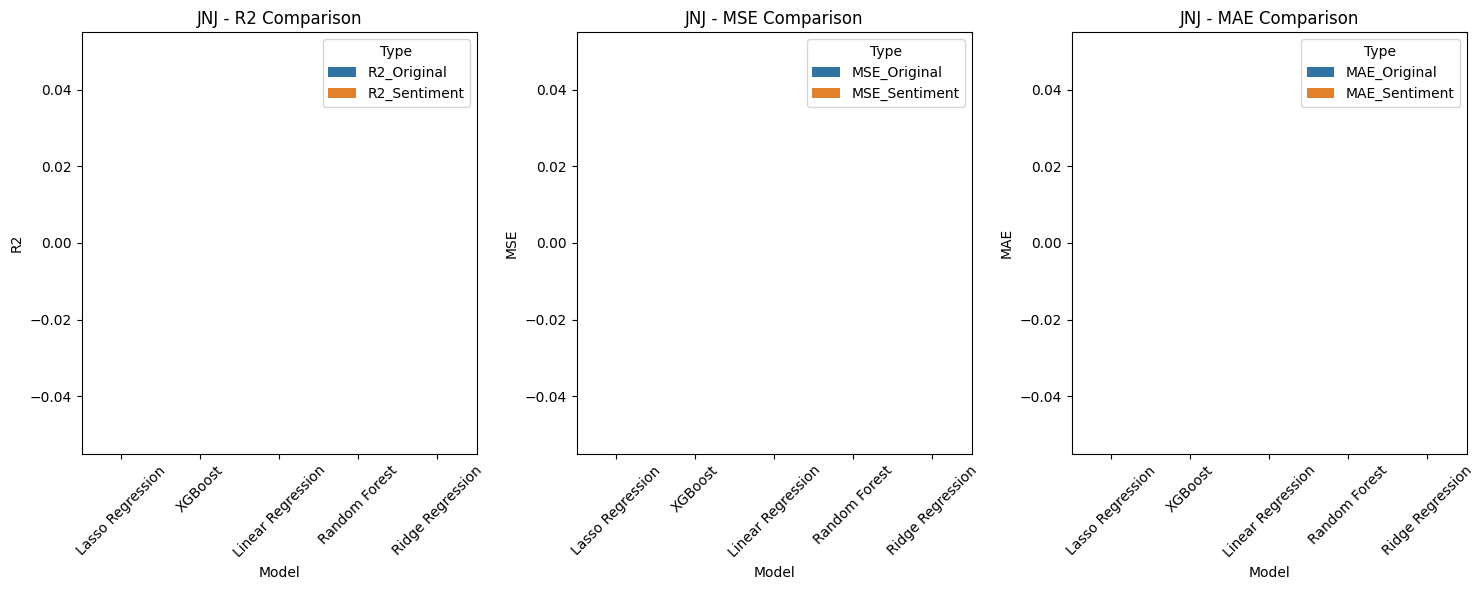

Delaying 30 seconds for API rate limit...

Processing PFE (10/40) - Sector: Healthcare
Starting data fetch for PFE (stock 10) at 12:28:31...
Raw data fetch completed for PFE at 12:28:32...
Fetched 677 raw records for PFE
Successfully processed 677 records for PFE
Fetching event-based news for PFE from 2023-01-01 to 2025-09-17...
  Fetching 2023-01-01 to 2023-04-01...
  Fetching 2023-04-02 to 2023-07-01...
  Fetching 2023-07-02 to 2023-09-30...
  Fetching 2023-10-01 to 2023-12-30...
  Fetching 2023-12-31 to 2024-03-30...
  Fetching 2024-03-31 to 2024-06-29...
  Fetching 2024-06-30 to 2024-09-28...
  Fetching 2024-09-29 to 2024-12-28...
  Fetching 2024-12-29 to 2025-03-29...
  Fetching 2025-03-30 to 2025-06-28...
  Fetching 2025-06-29 to 2025-09-17...
Data points - Original: 666, With Sentiment: 666
Training models for PFE (original)...
Training Linear Regression...
  Fold 1/3
  Fold 2/3
  Fold 3/3
Linear Regression - R²: 0.4921, RMSE: 0.0373, MAE: 0.0324
Training Ridge Regression...
  F

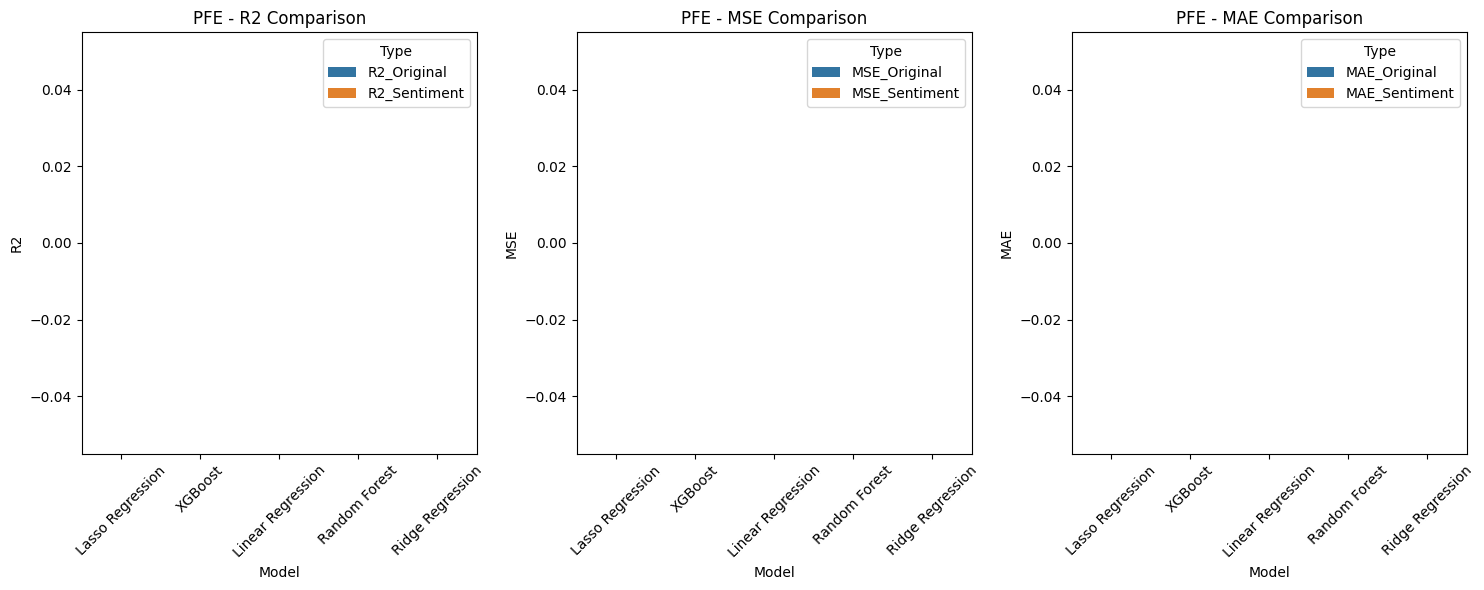


=== Progress: 10/40 stocks completed ===
Current time: 12:31:04
Delaying 30 seconds for API rate limit...

Processing UNH (11/40) - Sector: Healthcare
Starting data fetch for UNH (stock 11) at 12:31:34...
Raw data fetch completed for UNH at 12:31:34...
Fetched 678 raw records for UNH
Successfully processed 678 records for UNH
Fetching event-based news for UNH from 2023-01-01 to 2025-09-17...
  Fetching 2023-01-01 to 2023-04-01...
  Fetching 2023-04-02 to 2023-07-01...
  Fetching 2023-07-02 to 2023-09-30...
  Fetching 2023-10-01 to 2023-12-30...
  Fetching 2023-12-31 to 2024-03-30...
  Fetching 2024-03-31 to 2024-06-29...
  Fetching 2024-06-30 to 2024-09-28...
  Fetching 2024-09-29 to 2024-12-28...
  Fetching 2024-12-29 to 2025-03-29...
  Fetching 2025-03-30 to 2025-06-28...
  Fetching 2025-06-29 to 2025-09-17...
Data points - Original: 667, With Sentiment: 667
Training models for UNH (original)...
Training Linear Regression...
  Fold 1/3
  Fold 2/3
  Fold 3/3
Linear Regression - R²: 0

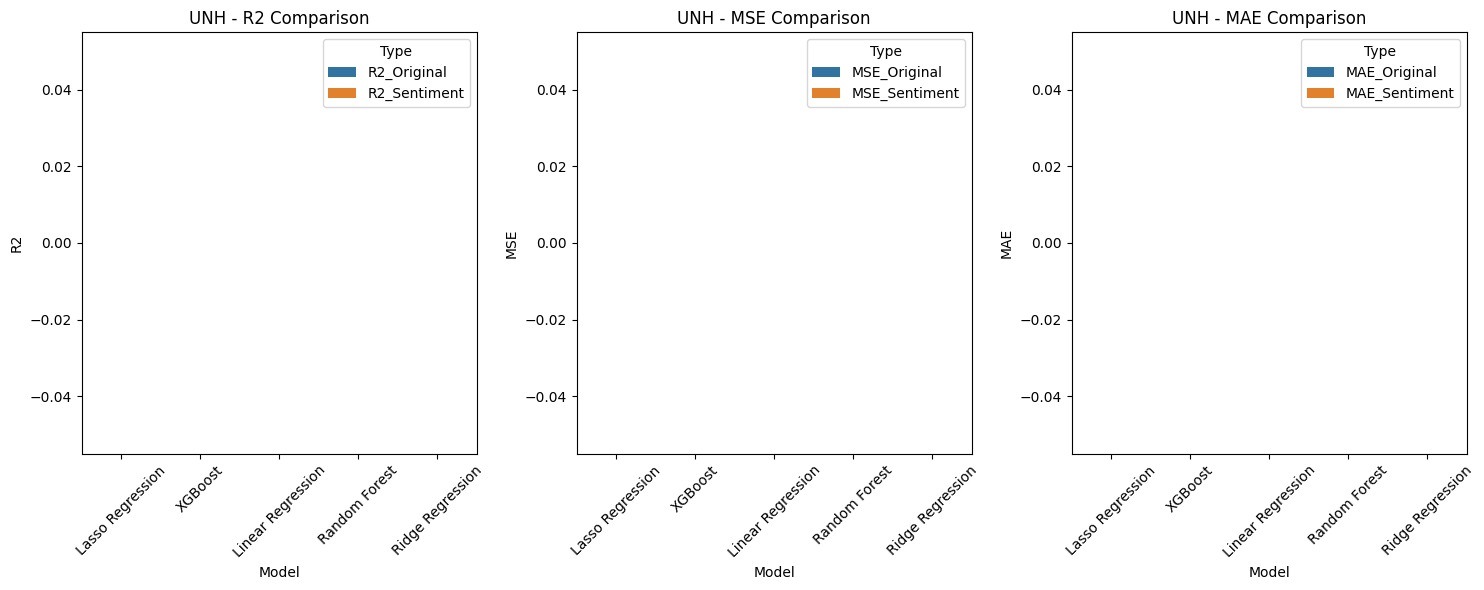

Delaying 30 seconds for API rate limit...

Processing ABBV (12/40) - Sector: Healthcare
Starting data fetch for ABBV (stock 12) at 12:34:36...
Raw data fetch completed for ABBV at 12:34:37...
Fetched 677 raw records for ABBV
Successfully processed 677 records for ABBV
Fetching event-based news for ABBV from 2023-01-01 to 2025-09-17...
  Fetching 2023-01-01 to 2023-04-01...
  Fetching 2023-04-02 to 2023-07-01...
  Fetching 2023-07-02 to 2023-09-30...
  Fetching 2023-10-01 to 2023-12-30...
  Fetching 2023-12-31 to 2024-03-30...
  Fetching 2024-03-31 to 2024-06-29...
  Fetching 2024-06-30 to 2024-09-28...
  Fetching 2024-09-29 to 2024-12-28...
  Fetching 2024-12-29 to 2025-03-29...
  Fetching 2025-03-30 to 2025-06-28...
  Fetching 2025-06-29 to 2025-09-17...
Data points - Original: 666, With Sentiment: 666
Training models for ABBV (original)...
Training Linear Regression...
  Fold 1/3
  Fold 2/3
  Fold 3/3
Linear Regression - R²: 0.8710, RMSE: 0.0257, MAE: 0.0194
Training Ridge Regression

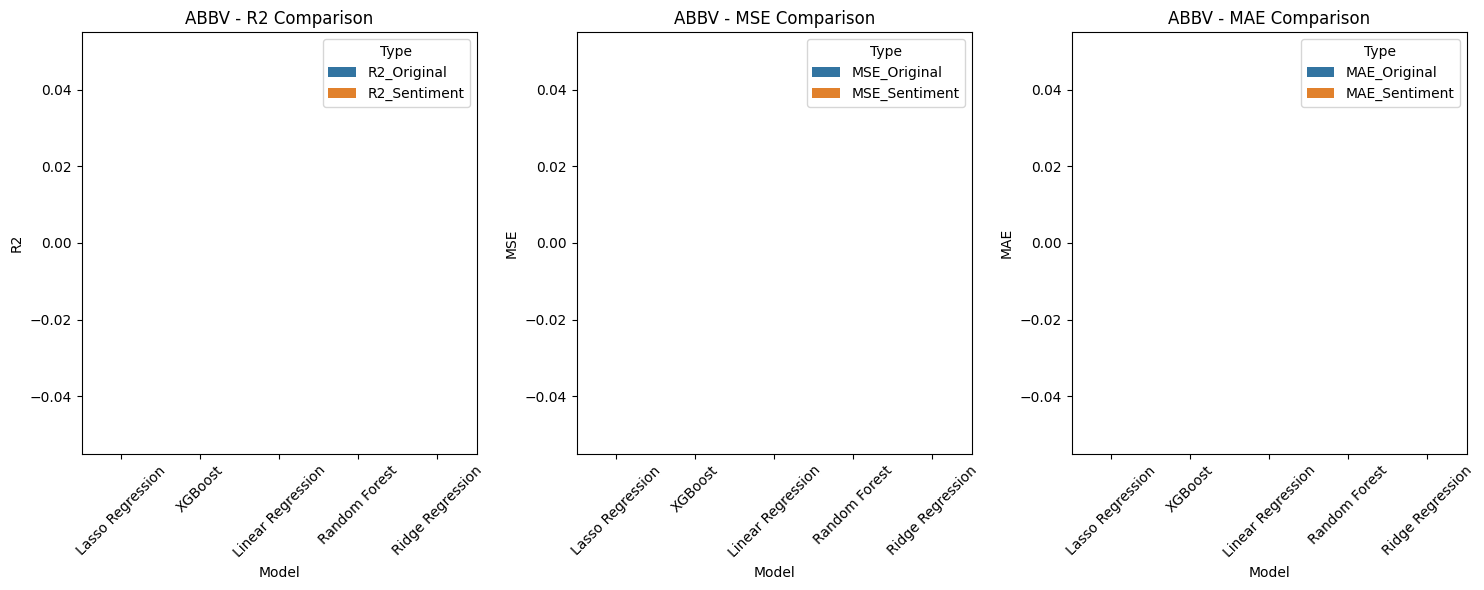

Delaying 30 seconds for API rate limit...

Processing XOM (13/40) - Sector: Energy
Starting data fetch for XOM (stock 13) at 12:37:38...
Raw data fetch completed for XOM at 12:37:38...
Fetched 677 raw records for XOM
Successfully processed 677 records for XOM
Fetching event-based news for XOM from 2023-01-01 to 2025-09-17...
  Fetching 2023-01-01 to 2023-04-01...
  Fetching 2023-04-02 to 2023-07-01...
  Fetching 2023-07-02 to 2023-09-30...
  Fetching 2023-10-01 to 2023-12-30...
  Fetching 2023-12-31 to 2024-03-30...
  Fetching 2024-03-31 to 2024-06-29...
  Fetching 2024-06-30 to 2024-09-28...
  Fetching 2024-09-29 to 2024-12-28...
  Fetching 2024-12-29 to 2025-03-29...
  Fetching 2025-03-30 to 2025-06-28...
  Fetching 2025-06-29 to 2025-09-17...
Data points - Original: 666, With Sentiment: 666
Training models for XOM (original)...
Training Linear Regression...
  Fold 1/3
  Fold 2/3
  Fold 3/3
Linear Regression - R²: 0.8602, RMSE: 0.0161, MAE: 0.0124
Training Ridge Regression...
  Fold 

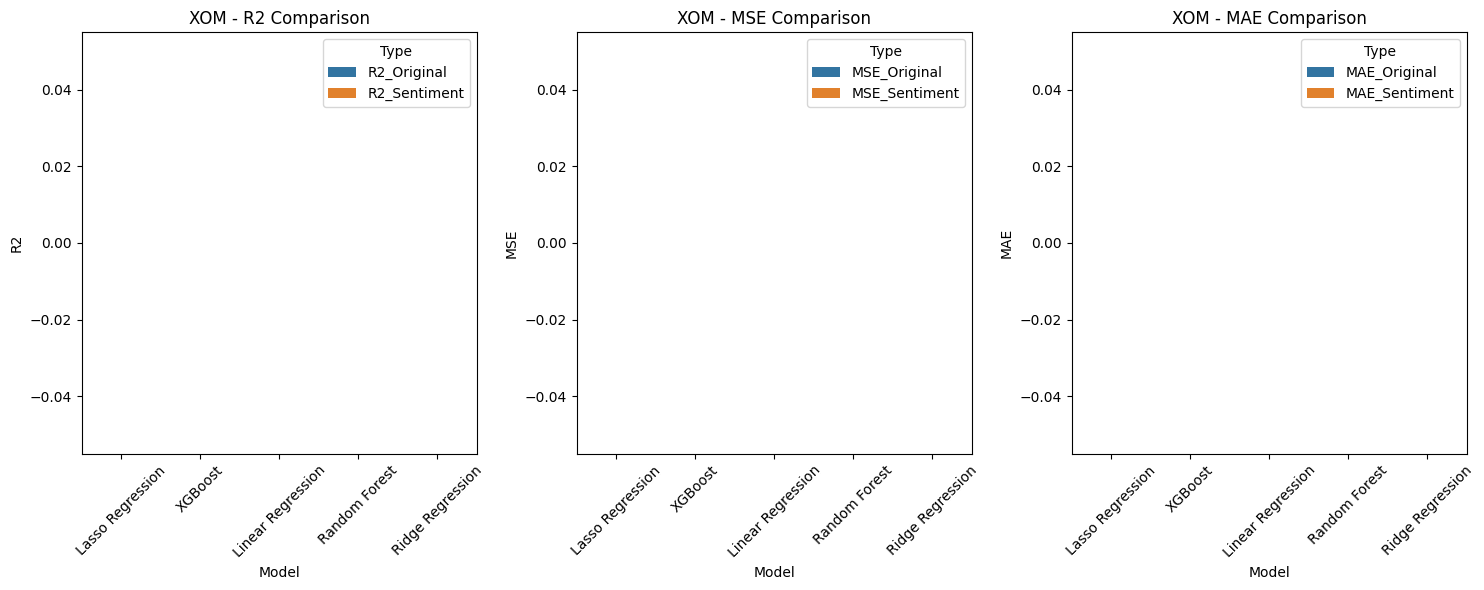

Delaying 30 seconds for API rate limit...

Processing CVX (14/40) - Sector: Energy
Starting data fetch for CVX (stock 14) at 12:40:46...
Raw data fetch completed for CVX at 12:40:47...
Fetched 677 raw records for CVX
Successfully processed 677 records for CVX
Fetching event-based news for CVX from 2023-01-01 to 2025-09-17...
  Fetching 2023-01-01 to 2023-04-01...
  Fetching 2023-04-02 to 2023-07-01...
  Fetching 2023-07-02 to 2023-09-30...
  Fetching 2023-10-01 to 2023-12-30...
  Fetching 2023-12-31 to 2024-03-30...
  Fetching 2024-03-31 to 2024-06-29...
  Fetching 2024-06-30 to 2024-09-28...
  Fetching 2024-09-29 to 2024-12-28...
  Fetching 2024-12-29 to 2025-03-29...
  Fetching 2025-03-30 to 2025-06-28...
  Fetching 2025-06-29 to 2025-09-17...
Data points - Original: 666, With Sentiment: 666
Training models for CVX (original)...
Training Linear Regression...
  Fold 1/3
  Fold 2/3
  Fold 3/3
Linear Regression - R²: 0.8935, RMSE: 0.0170, MAE: 0.0125
Training Ridge Regression...
  Fold 

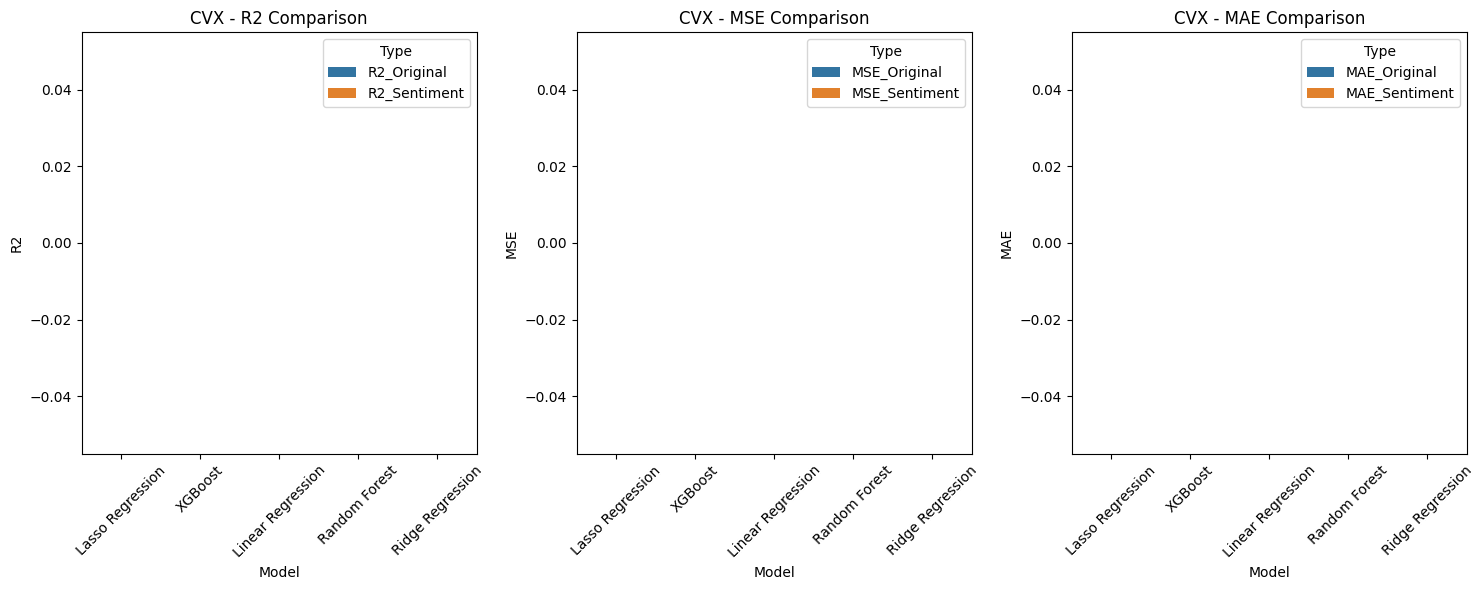

Delaying 30 seconds for API rate limit...

Processing COP (15/40) - Sector: Energy
Starting data fetch for COP (stock 15) at 12:43:55...
Raw data fetch completed for COP at 12:43:55...
Fetched 678 raw records for COP
Successfully processed 678 records for COP
Fetching event-based news for COP from 2023-01-01 to 2025-09-17...
  Fetching 2023-01-01 to 2023-04-01...
  Fetching 2023-04-02 to 2023-07-01...
  Fetching 2023-07-02 to 2023-09-30...
  Fetching 2023-10-01 to 2023-12-30...
  Fetching 2023-12-31 to 2024-03-30...
  Fetching 2024-03-31 to 2024-06-29...
  Fetching 2024-06-30 to 2024-09-28...
  Fetching 2024-09-29 to 2024-12-28...
  Fetching 2024-12-29 to 2025-03-29...
  Fetching 2025-03-30 to 2025-06-28...
  Fetching 2025-06-29 to 2025-09-17...
Data points - Original: 667, With Sentiment: 667
Training models for COP (original)...
Training Linear Regression...
  Fold 1/3
  Fold 2/3
  Fold 3/3
Linear Regression - R²: 0.5799, RMSE: 0.0334, MAE: 0.0192
Training Ridge Regression...
  Fold 

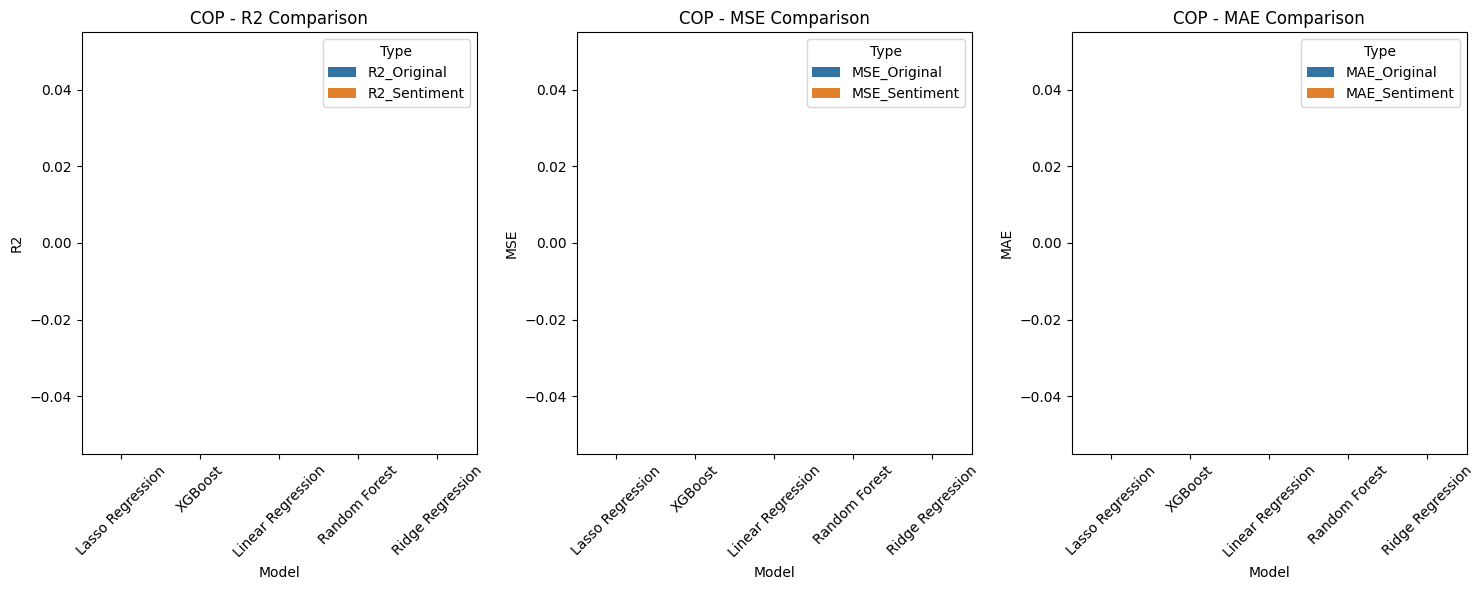


=== Progress: 15/40 stocks completed ===
Current time: 12:46:29
Delaying 30 seconds for API rate limit...

Processing EOG (16/40) - Sector: Energy
Starting data fetch for EOG (stock 16) at 12:46:59...
Raw data fetch completed for EOG at 12:46:59...
Fetched 677 raw records for EOG
Successfully processed 677 records for EOG
Fetching event-based news for EOG from 2023-01-01 to 2025-09-17...
  Fetching 2023-01-01 to 2023-04-01...
  Fetching 2023-04-02 to 2023-07-01...
  Fetching 2023-07-02 to 2023-09-30...
  Fetching 2023-10-01 to 2023-12-30...
  Fetching 2023-12-31 to 2024-03-30...
  Fetching 2024-03-31 to 2024-06-29...
  Fetching 2024-06-30 to 2024-09-28...
  Fetching 2024-09-29 to 2024-12-28...
  Fetching 2024-12-29 to 2025-03-29...
  Fetching 2025-03-30 to 2025-06-28...
  Fetching 2025-06-29 to 2025-09-17...
Data points - Original: 666, With Sentiment: 666
Training models for EOG (original)...
Training Linear Regression...
  Fold 1/3
  Fold 2/3
  Fold 3/3
Linear Regression - R²: 0.879

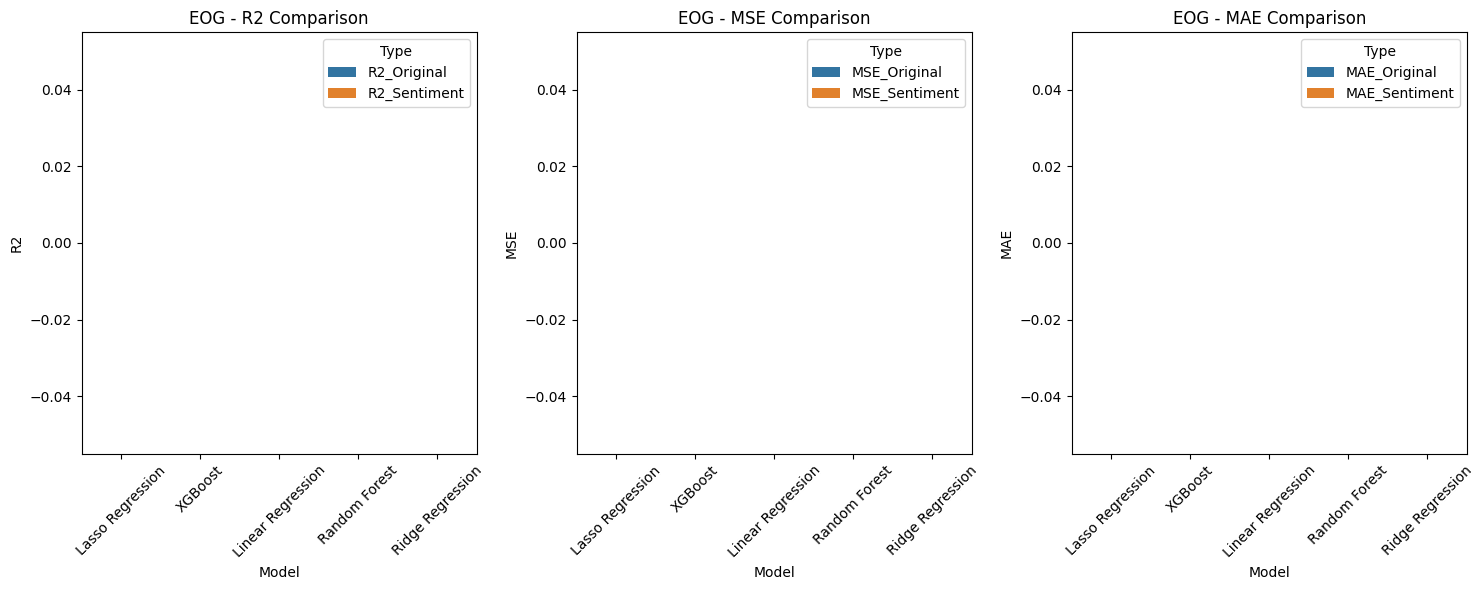

Delaying 30 seconds for API rate limit...

Processing AMZN (17/40) - Sector: Consumer Discretionary
Starting data fetch for AMZN (stock 17) at 12:50:02...
Raw data fetch completed for AMZN at 12:50:02...
Fetched 678 raw records for AMZN
Successfully processed 678 records for AMZN
Fetching event-based news for AMZN from 2023-01-01 to 2025-09-17...
  Fetching 2023-01-01 to 2023-04-01...
  Fetching 2023-04-02 to 2023-07-01...
  Fetching 2023-07-02 to 2023-09-30...
  Fetching 2023-10-01 to 2023-12-30...
  Fetching 2023-12-31 to 2024-03-30...
  Fetching 2024-03-31 to 2024-06-29...
  Fetching 2024-06-30 to 2024-09-28...
  Fetching 2024-09-29 to 2024-12-28...
  Fetching 2024-12-29 to 2025-03-29...
  Fetching 2025-03-30 to 2025-06-28...
  Fetching 2025-06-29 to 2025-09-17...
Data points - Original: 667, With Sentiment: 667
Training models for AMZN (original)...
Training Linear Regression...
  Fold 1/3
  Fold 2/3
  Fold 3/3
Linear Regression - R²: 0.4007, RMSE: 0.0751, MAE: 0.0641
Training Ridg

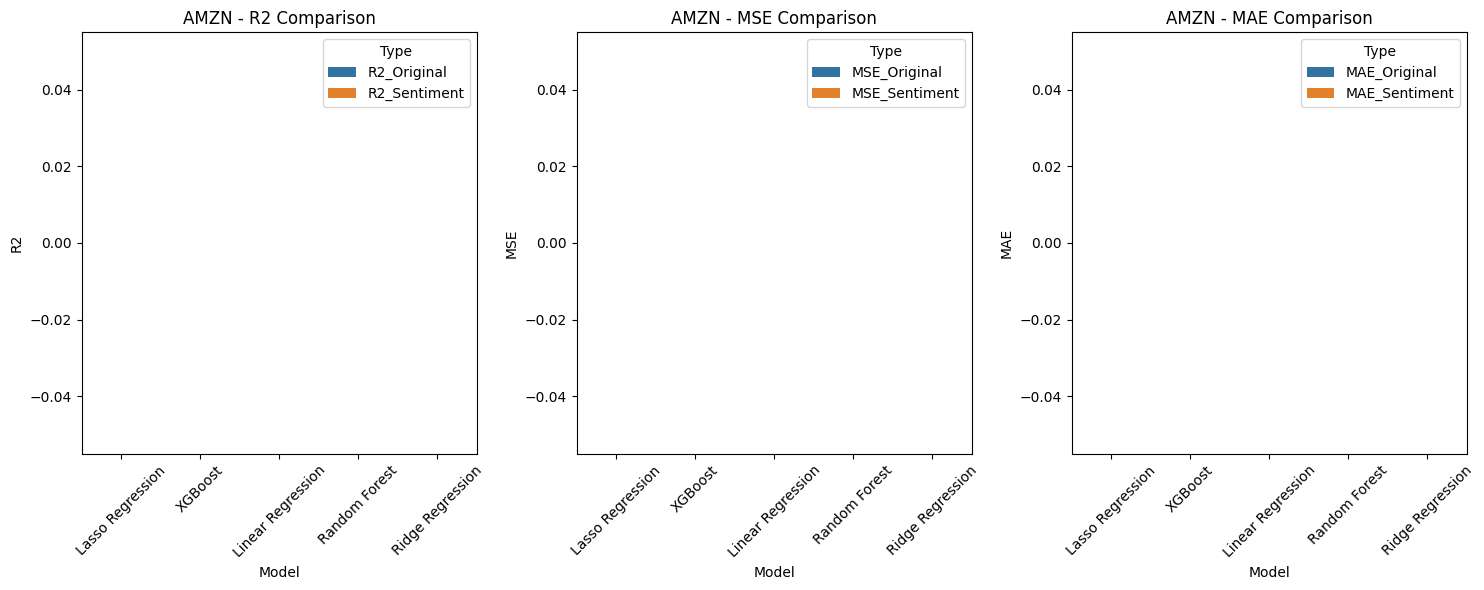

Delaying 30 seconds for API rate limit...

Processing TSLA (18/40) - Sector: Consumer Discretionary
Starting data fetch for TSLA (stock 18) at 12:53:15...
Raw data fetch completed for TSLA at 12:53:15...
Fetched 678 raw records for TSLA
Successfully processed 678 records for TSLA
Fetching event-based news for TSLA from 2023-01-01 to 2025-09-17...
  Fetching 2023-01-01 to 2023-04-01...
  Fetching 2023-04-02 to 2023-07-01...
  Fetching 2023-07-02 to 2023-09-30...
  Fetching 2023-10-01 to 2023-12-30...
  Fetching 2023-12-31 to 2024-03-30...
  Fetching 2024-03-31 to 2024-06-29...
  Fetching 2024-06-30 to 2024-09-28...
  Fetching 2024-09-29 to 2024-12-28...
  Fetching 2024-12-29 to 2025-03-29...
  Fetching 2025-03-30 to 2025-06-28...
  Fetching 2025-06-29 to 2025-09-17...
Data points - Original: 667, With Sentiment: 667
Training models for TSLA (original)...
Training Linear Regression...
  Fold 1/3
  Fold 2/3
  Fold 3/3
Linear Regression - R²: 0.7649, RMSE: 0.0919, MAE: 0.0670
Training Ridg

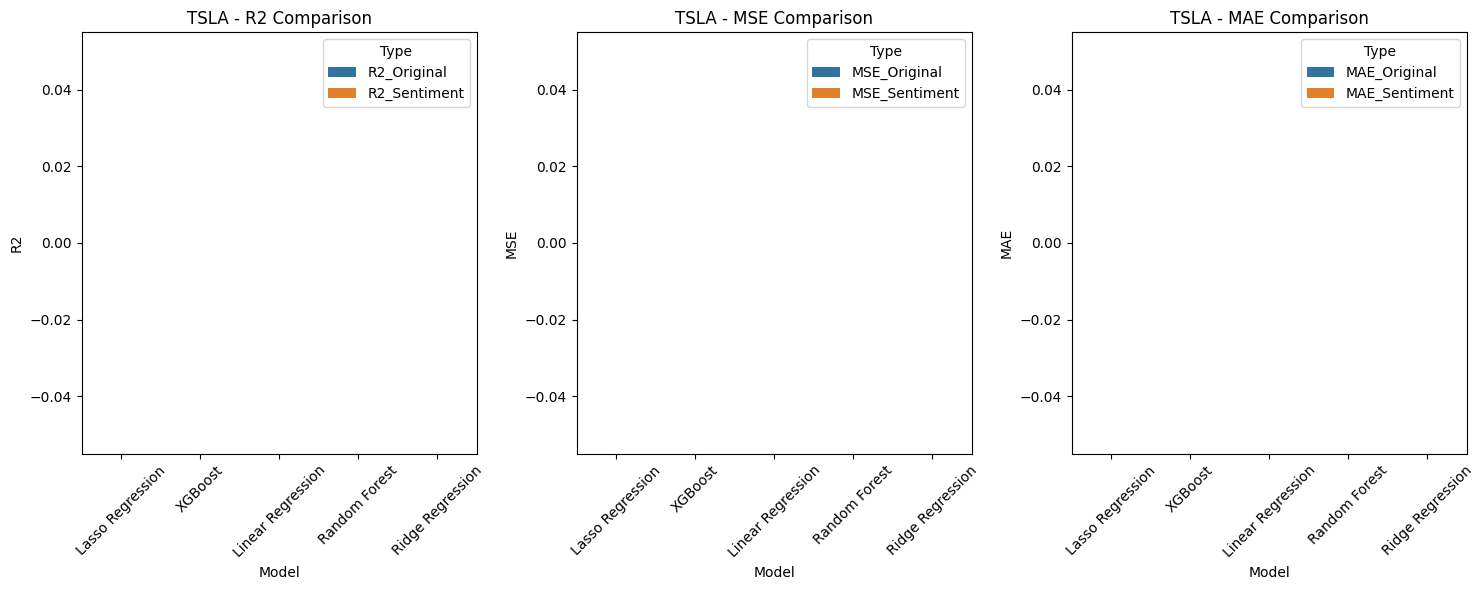

Delaying 30 seconds for API rate limit...

Processing HD (19/40) - Sector: Consumer Discretionary
Starting data fetch for HD (stock 19) at 12:56:32...
Raw data fetch completed for HD at 12:56:32...
Fetched 678 raw records for HD
Successfully processed 678 records for HD
Fetching event-based news for HD from 2023-01-01 to 2025-09-17...
  Fetching 2023-01-01 to 2023-04-01...
  Fetching 2023-04-02 to 2023-07-01...
  Fetching 2023-07-02 to 2023-09-30...
  Fetching 2023-10-01 to 2023-12-30...
  Fetching 2023-12-31 to 2024-03-30...
  Fetching 2024-03-31 to 2024-06-29...
  Fetching 2024-06-30 to 2024-09-28...
  Fetching 2024-09-29 to 2024-12-28...
  Fetching 2024-12-29 to 2025-03-29...
  Fetching 2025-03-30 to 2025-06-28...
  Fetching 2025-06-29 to 2025-09-17...
Data points - Original: 667, With Sentiment: 667
Training models for HD (original)...
Training Linear Regression...
  Fold 1/3
  Fold 2/3
  Fold 3/3
Linear Regression - R²: 0.9201, RMSE: 0.0215, MAE: 0.0169
Training Ridge Regression..

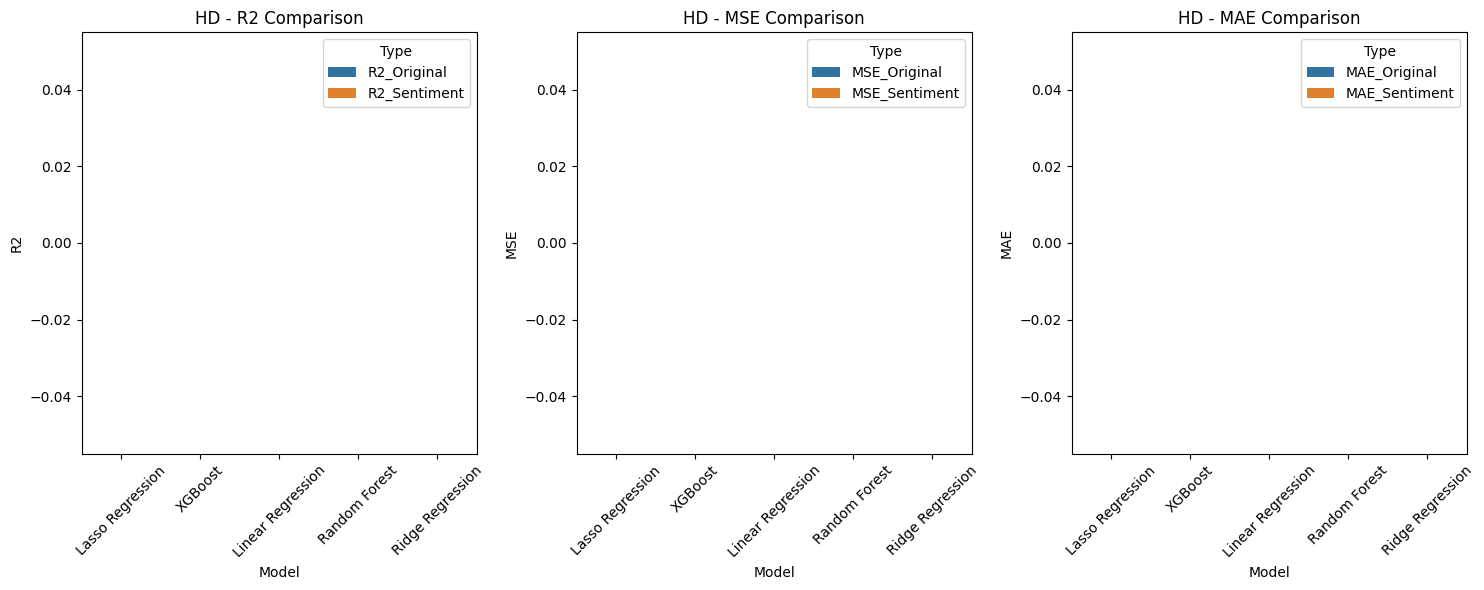

Delaying 30 seconds for API rate limit...

Processing MCD (20/40) - Sector: Consumer Discretionary
Starting data fetch for MCD (stock 20) at 12:59:34...
Raw data fetch completed for MCD at 12:59:35...
Fetched 677 raw records for MCD
Successfully processed 677 records for MCD
Fetching event-based news for MCD from 2023-01-01 to 2025-09-17...
  Fetching 2023-01-01 to 2023-04-01...
  Fetching 2023-04-02 to 2023-07-01...
  Fetching 2023-07-02 to 2023-09-30...
  Fetching 2023-10-01 to 2023-12-30...
  Fetching 2023-12-31 to 2024-03-30...
  Fetching 2024-03-31 to 2024-06-29...
  Fetching 2024-06-30 to 2024-09-28...
  Fetching 2024-09-29 to 2024-12-28...
  Fetching 2024-12-29 to 2025-03-29...
  Fetching 2025-03-30 to 2025-06-28...
  Fetching 2025-06-29 to 2025-09-17...
Data points - Original: 666, With Sentiment: 666
Training models for MCD (original)...
Training Linear Regression...
  Fold 1/3
  Fold 2/3
  Fold 3/3
Linear Regression - R²: 0.8651, RMSE: 0.0168, MAE: 0.0111
Training Ridge Regre

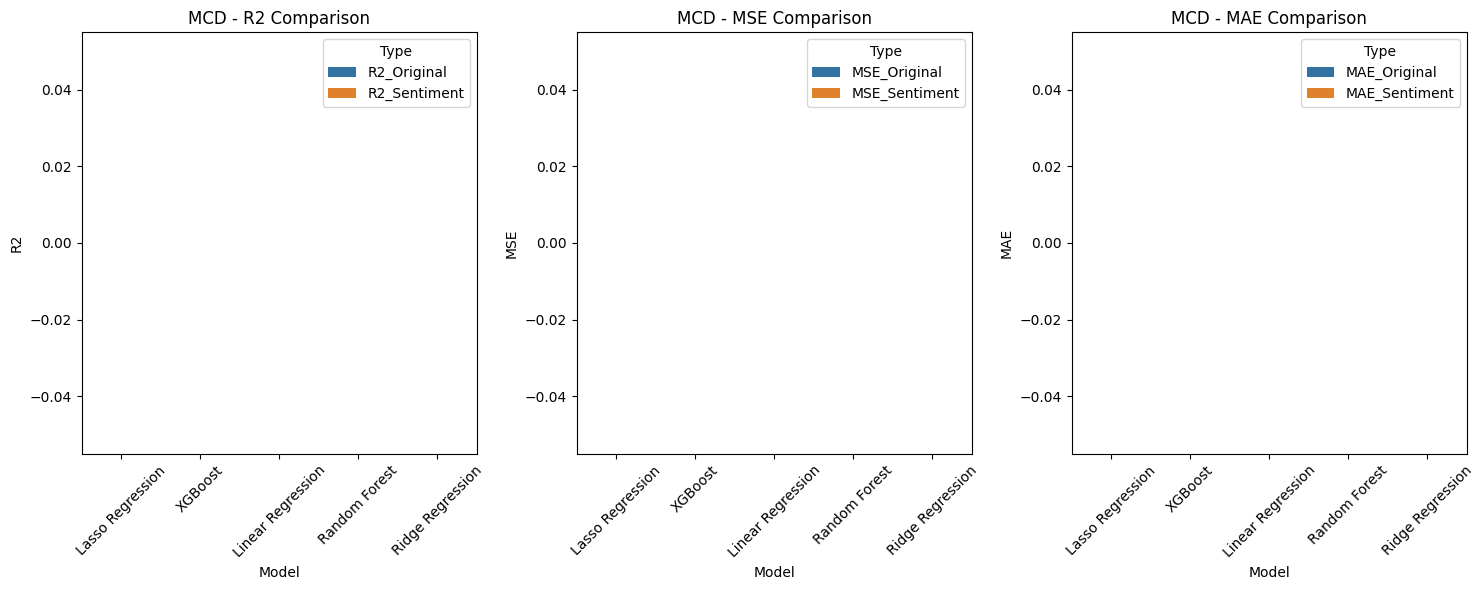


=== Progress: 20/40 stocks completed ===
Current time: 13:02:08
Delaying 30 seconds for API rate limit...

Processing PG (21/40) - Sector: Consumer Staples
Starting data fetch for PG (stock 21) at 13:02:38...
Raw data fetch completed for PG at 13:02:38...
Fetched 677 raw records for PG
Successfully processed 677 records for PG
Fetching event-based news for PG from 2023-01-01 to 2025-09-17...
  Fetching 2023-01-01 to 2023-04-01...
  Fetching 2023-04-02 to 2023-07-01...
  Fetching 2023-07-02 to 2023-09-30...
  Fetching 2023-10-01 to 2023-12-30...
  Fetching 2023-12-31 to 2024-03-30...
  Fetching 2024-03-31 to 2024-06-29...
  Fetching 2024-06-30 to 2024-09-28...
  Fetching 2024-09-29 to 2024-12-28...
  Fetching 2024-12-29 to 2025-03-29...
  Fetching 2025-03-30 to 2025-06-28...
  Fetching 2025-06-29 to 2025-09-17...
Data points - Original: 666, With Sentiment: 666
Training models for PG (original)...
Training Linear Regression...
  Fold 1/3
  Fold 2/3
  Fold 3/3
Linear Regression - R²: 0.

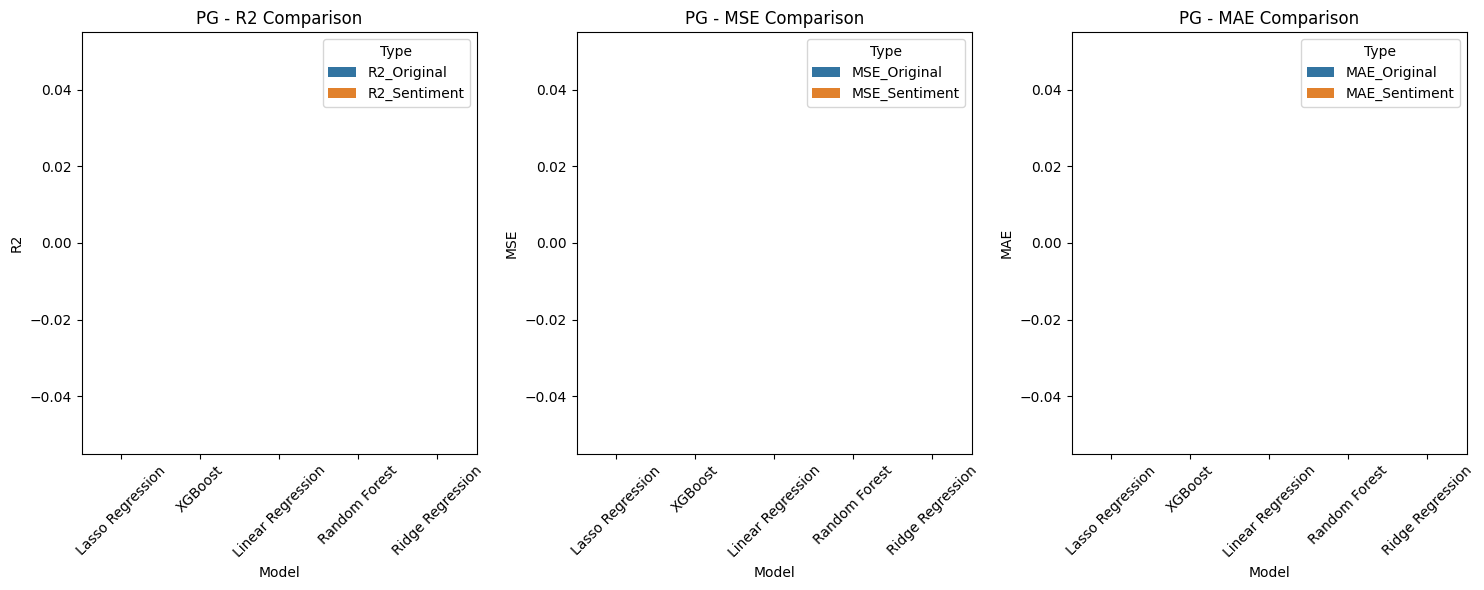

Delaying 30 seconds for API rate limit...

Processing KO (22/40) - Sector: Consumer Staples
Starting data fetch for KO (stock 22) at 13:05:40...
Raw data fetch completed for KO at 13:05:40...
Fetched 678 raw records for KO
Successfully processed 678 records for KO
Fetching event-based news for KO from 2023-01-01 to 2025-09-17...
  Fetching 2023-01-01 to 2023-04-01...
  Fetching 2023-04-02 to 2023-07-01...
  Fetching 2023-07-02 to 2023-09-30...
  Fetching 2023-10-01 to 2023-12-30...
  Fetching 2023-12-31 to 2024-03-30...
  Fetching 2024-03-31 to 2024-06-29...
  Fetching 2024-06-30 to 2024-09-28...
  Fetching 2024-09-29 to 2024-12-28...
  Fetching 2024-12-29 to 2025-03-29...
  Fetching 2025-03-30 to 2025-06-28...
  Fetching 2025-06-29 to 2025-09-17...
Data points - Original: 667, With Sentiment: 667
Training models for KO (original)...
Training Linear Regression...
  Fold 1/3
  Fold 2/3
  Fold 3/3
Linear Regression - R²: 0.7533, RMSE: 0.0221, MAE: 0.0146
Training Ridge Regression...
  Fo

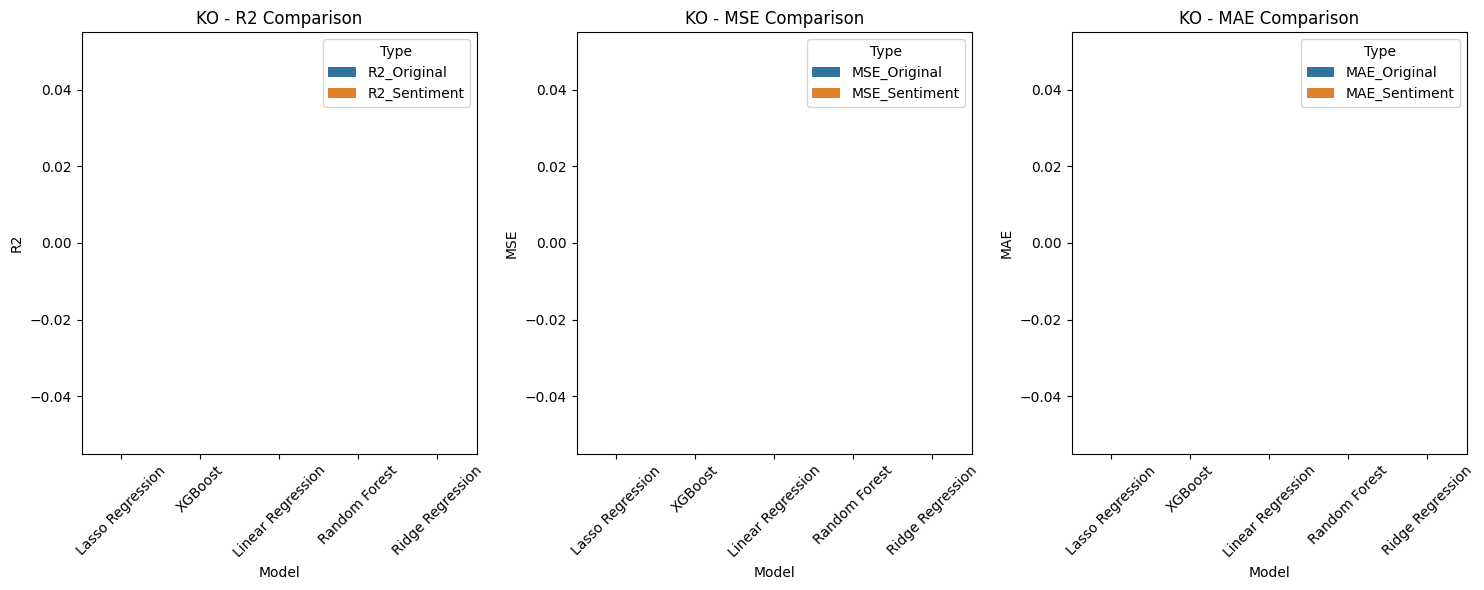

Delaying 30 seconds for API rate limit...

Processing WMT (23/40) - Sector: Consumer Staples
Starting data fetch for WMT (stock 23) at 13:08:44...
Raw data fetch completed for WMT at 13:08:45...
Fetched 677 raw records for WMT
Successfully processed 677 records for WMT
Fetching event-based news for WMT from 2023-01-01 to 2025-09-17...
  Fetching 2023-01-01 to 2023-04-01...
  Fetching 2023-04-02 to 2023-07-01...
  Fetching 2023-07-02 to 2023-09-30...
  Fetching 2023-10-01 to 2023-12-30...
  Fetching 2023-12-31 to 2024-03-30...
  Fetching 2024-03-31 to 2024-06-29...
  Fetching 2024-06-30 to 2024-09-28...
  Fetching 2024-09-29 to 2024-12-28...
  Fetching 2024-12-29 to 2025-03-29...
  Fetching 2025-03-30 to 2025-06-28...
  Fetching 2025-06-29 to 2025-09-17...
Data points - Original: 666, With Sentiment: 666
Training models for WMT (original)...
Training Linear Regression...
  Fold 1/3
  Fold 2/3
  Fold 3/3
Linear Regression - R²: -0.1783, RMSE: 0.0726, MAE: 0.0442
Training Ridge Regression

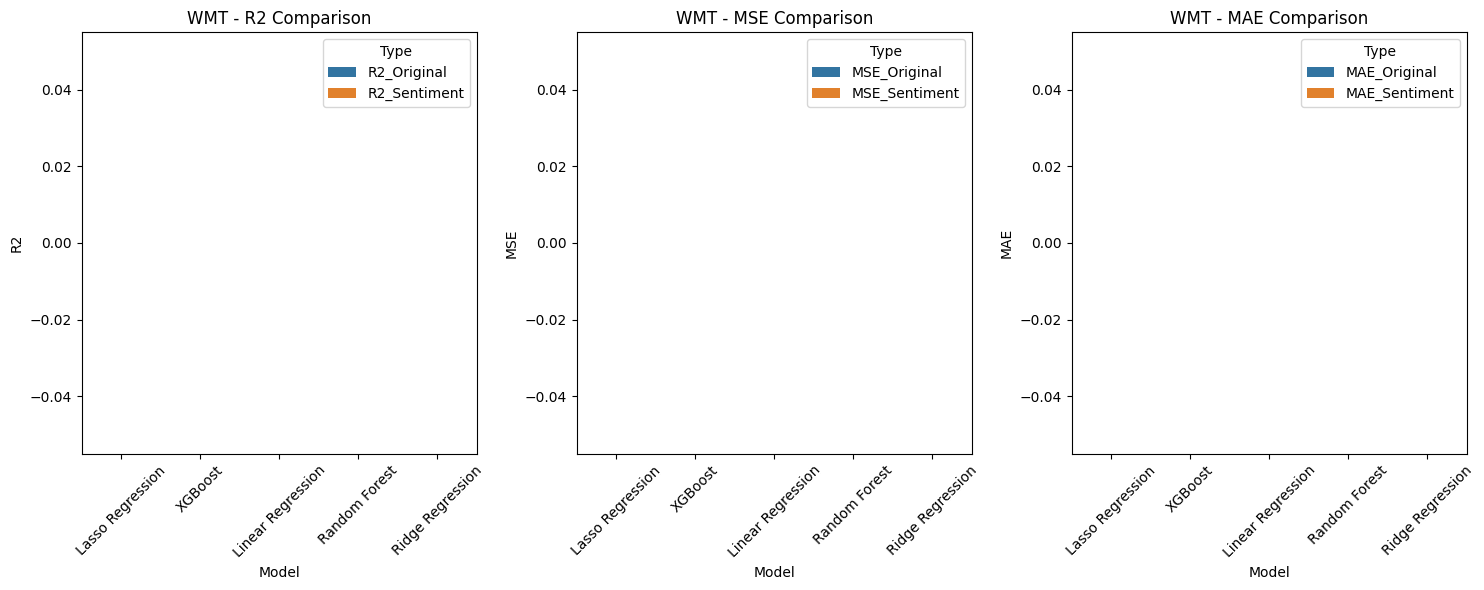

Delaying 30 seconds for API rate limit...

Processing COST (24/40) - Sector: Consumer Staples
Starting data fetch for COST (stock 24) at 13:11:49...
Raw data fetch completed for COST at 13:11:49...
Fetched 678 raw records for COST
Successfully processed 678 records for COST
Fetching event-based news for COST from 2023-01-01 to 2025-09-17...
  Fetching 2023-01-01 to 2023-04-01...
  Fetching 2023-04-02 to 2023-07-01...
  Fetching 2023-07-02 to 2023-09-30...
  Fetching 2023-10-01 to 2023-12-30...
  Fetching 2023-12-31 to 2024-03-30...
  Fetching 2024-03-31 to 2024-06-29...
  Fetching 2024-06-30 to 2024-09-28...
  Fetching 2024-09-29 to 2024-12-28...
  Fetching 2024-12-29 to 2025-03-29...
  Fetching 2025-03-30 to 2025-06-28...
  Fetching 2025-06-29 to 2025-09-17...
Data points - Original: 667, With Sentiment: 667
Training models for COST (original)...
Training Linear Regression...
  Fold 1/3
  Fold 2/3
  Fold 3/3
Linear Regression - R²: -0.8971, RMSE: 0.0694, MAE: 0.0604
Training Ridge Reg

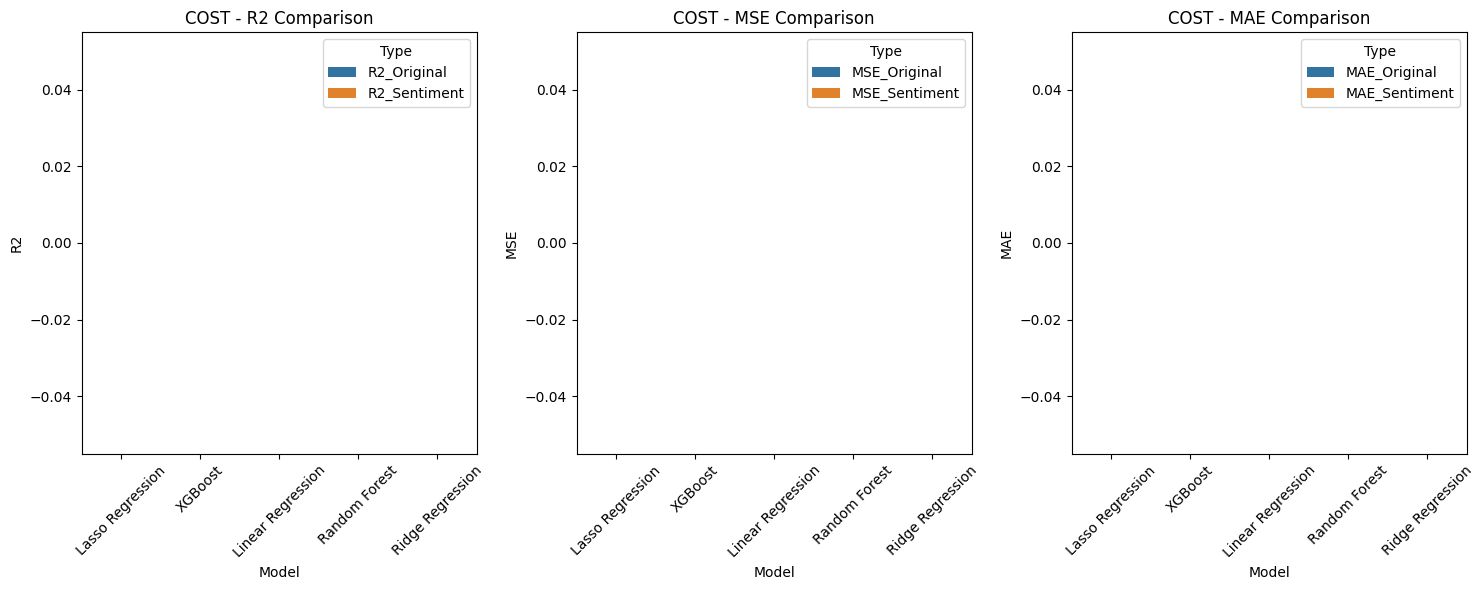

Delaying 30 seconds for API rate limit...

Processing BA (25/40) - Sector: Industrials
Starting data fetch for BA (stock 25) at 13:14:52...
Raw data fetch completed for BA at 13:14:52...
Fetched 677 raw records for BA
Successfully processed 677 records for BA
Fetching event-based news for BA from 2023-01-01 to 2025-09-17...
  Fetching 2023-01-01 to 2023-04-01...
  Fetching 2023-04-02 to 2023-07-01...
  Fetching 2023-07-02 to 2023-09-30...
  Fetching 2023-10-01 to 2023-12-30...
  Fetching 2023-12-31 to 2024-03-30...
  Fetching 2024-03-31 to 2024-06-29...
  Fetching 2024-06-30 to 2024-09-28...
  Fetching 2024-09-29 to 2024-12-28...
  Fetching 2024-12-29 to 2025-03-29...
  Fetching 2025-03-30 to 2025-06-28...
  Fetching 2025-06-29 to 2025-09-17...
Data points - Original: 666, With Sentiment: 666
Training models for BA (original)...
Training Linear Regression...
  Fold 1/3
  Fold 2/3
  Fold 3/3
Linear Regression - R²: 0.8503, RMSE: 0.0408, MAE: 0.0323
Training Ridge Regression...
  Fold 1/

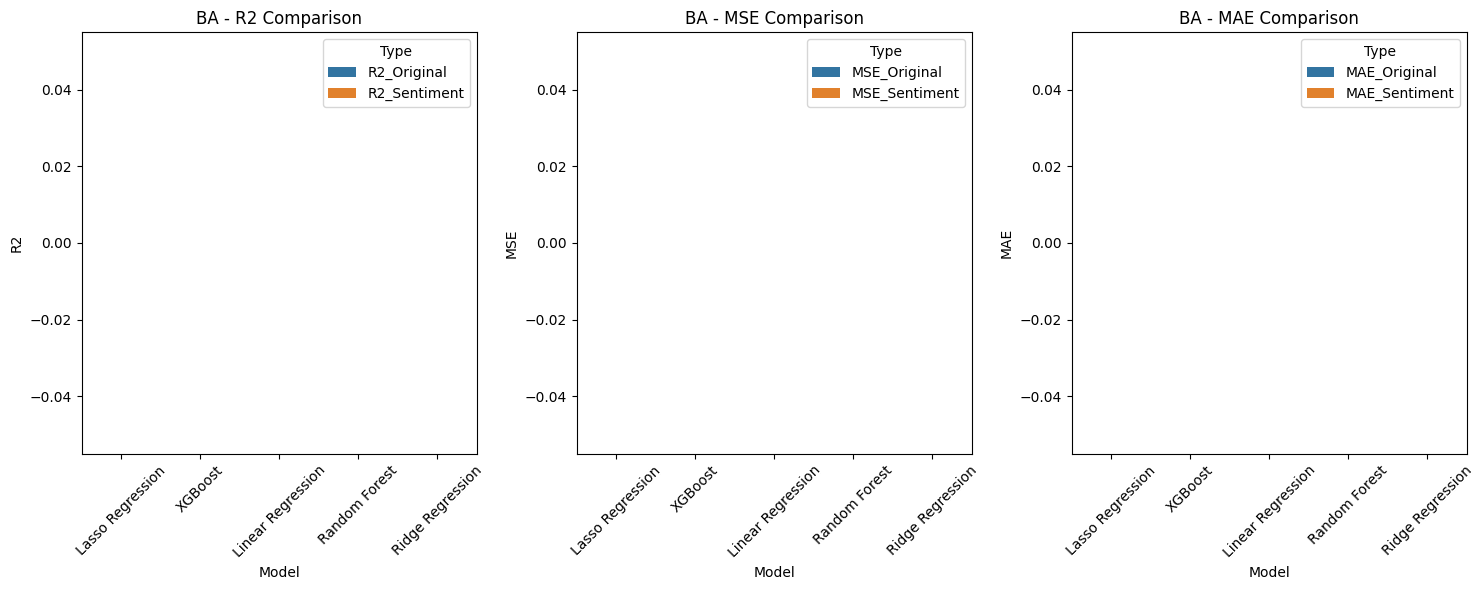


=== Progress: 25/40 stocks completed ===
Current time: 13:17:31
Delaying 30 seconds for API rate limit...

Processing CAT (26/40) - Sector: Industrials
Starting data fetch for CAT (stock 26) at 13:18:01...
Raw data fetch completed for CAT at 13:18:01...
Fetched 677 raw records for CAT
Successfully processed 677 records for CAT
Fetching event-based news for CAT from 2023-01-01 to 2025-09-17...
  Fetching 2023-01-01 to 2023-04-01...
  Fetching 2023-04-02 to 2023-07-01...
  Fetching 2023-07-02 to 2023-09-30...
  Fetching 2023-10-01 to 2023-12-30...
  Fetching 2023-12-31 to 2024-03-30...
  Fetching 2024-03-31 to 2024-06-29...
  Fetching 2024-06-30 to 2024-09-28...
  Fetching 2024-09-29 to 2024-12-28...
  Fetching 2024-12-29 to 2025-03-29...
  Fetching 2025-03-30 to 2025-06-28...
  Fetching 2025-06-29 to 2025-09-17...
Data points - Original: 666, With Sentiment: 666
Training models for CAT (original)...
Training Linear Regression...
  Fold 1/3
  Fold 2/3
  Fold 3/3
Linear Regression - R²: 

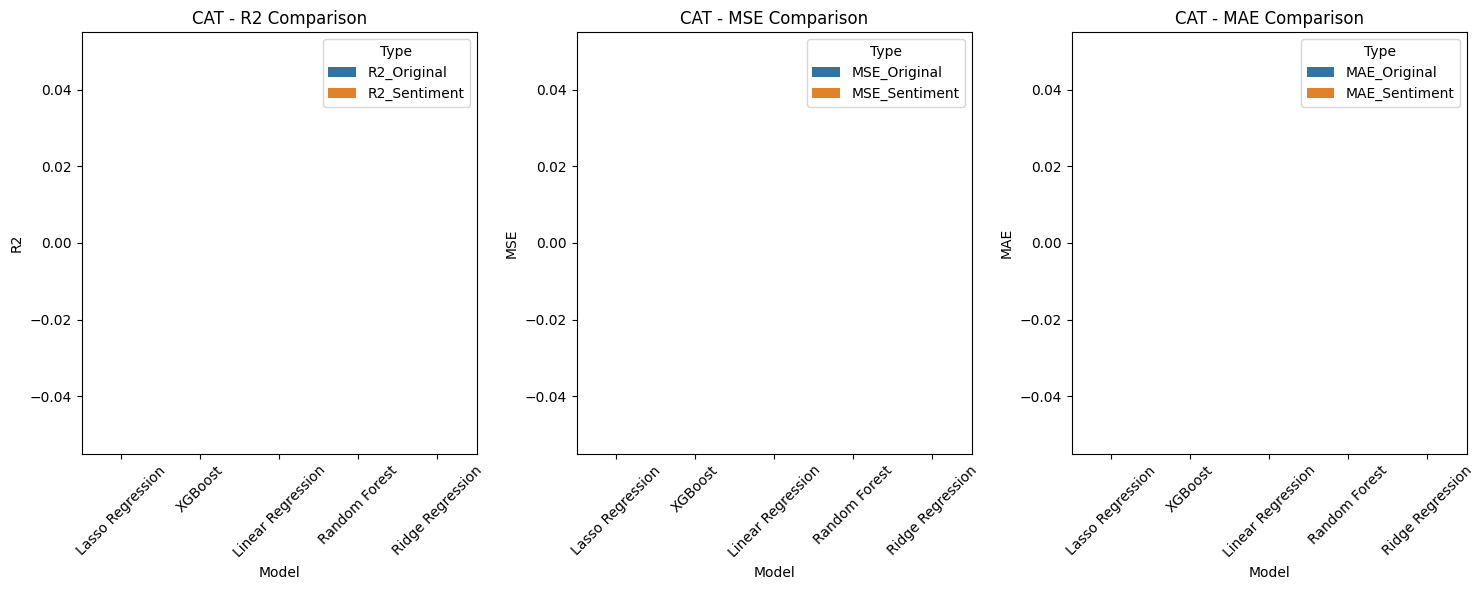

Delaying 30 seconds for API rate limit...

Processing MMM (27/40) - Sector: Industrials
Starting data fetch for MMM (stock 27) at 13:21:03...
Raw data fetch completed for MMM at 13:21:04...
Fetched 678 raw records for MMM
Successfully processed 678 records for MMM
Fetching event-based news for MMM from 2023-01-01 to 2025-09-17...
  Fetching 2023-01-01 to 2023-04-01...
  Fetching 2023-04-02 to 2023-07-01...
  Fetching 2023-07-02 to 2023-09-30...
  Fetching 2023-10-01 to 2023-12-30...
  Fetching 2023-12-31 to 2024-03-30...
  Fetching 2024-03-31 to 2024-06-29...
  Fetching 2024-06-30 to 2024-09-28...
  Fetching 2024-09-29 to 2024-12-28...
  Fetching 2024-12-29 to 2025-03-29...
  Fetching 2025-03-30 to 2025-06-28...
  Fetching 2025-06-29 to 2025-09-17...
Data points - Original: 667, With Sentiment: 667
Training models for MMM (original)...
Training Linear Regression...
  Fold 1/3
  Fold 2/3
  Fold 3/3
Linear Regression - R²: 0.1767, RMSE: 0.0641, MAE: 0.0551
Training Ridge Regression...
  

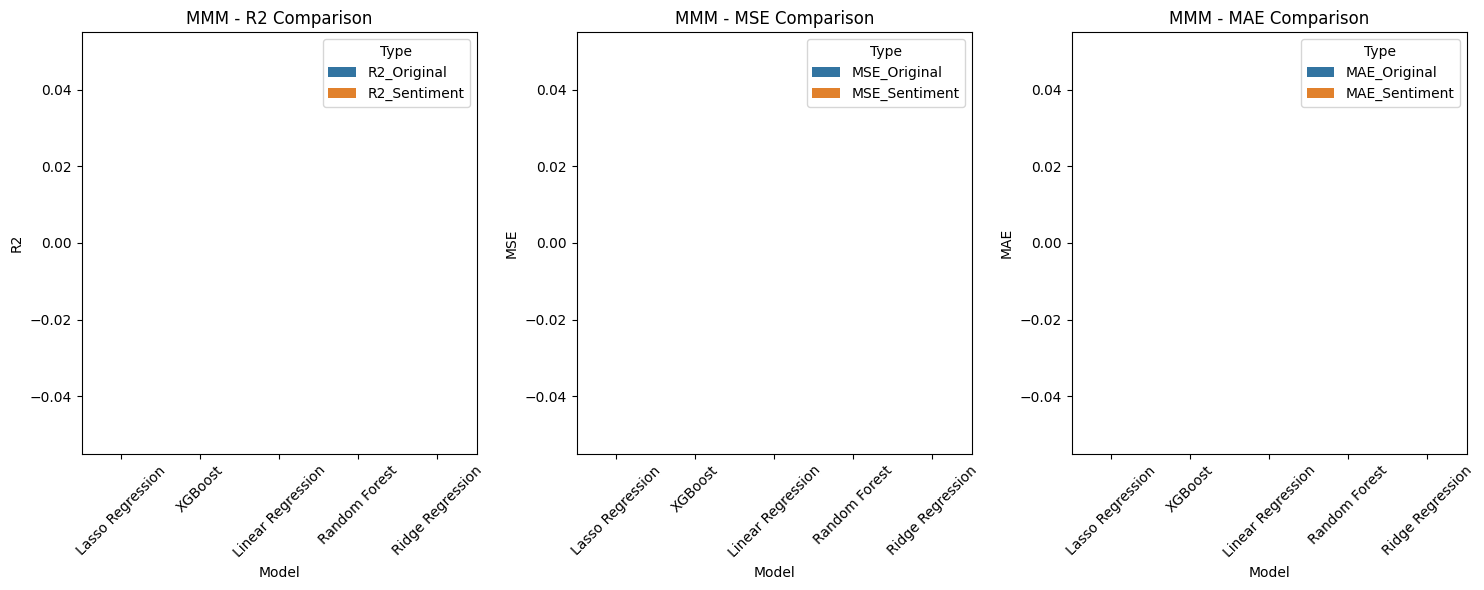

Delaying 30 seconds for API rate limit...

Processing HON (28/40) - Sector: Industrials
Starting data fetch for HON (stock 28) at 13:24:06...
Raw data fetch completed for HON at 13:24:06...
Fetched 678 raw records for HON
Successfully processed 678 records for HON
Fetching event-based news for HON from 2023-01-01 to 2025-09-17...
  Fetching 2023-01-01 to 2023-04-01...
  Fetching 2023-04-02 to 2023-07-01...
  Fetching 2023-07-02 to 2023-09-30...
  Fetching 2023-10-01 to 2023-12-30...
  Fetching 2023-12-31 to 2024-03-30...
  Fetching 2024-03-31 to 2024-06-29...
  Fetching 2024-06-30 to 2024-09-28...
  Fetching 2024-09-29 to 2024-12-28...
  Fetching 2024-12-29 to 2025-03-29...
  Fetching 2025-03-30 to 2025-06-28...
  Fetching 2025-06-29 to 2025-09-17...
Data points - Original: 667, With Sentiment: 667
Training models for HON (original)...
Training Linear Regression...
  Fold 1/3
  Fold 2/3
  Fold 3/3
Linear Regression - R²: 0.7946, RMSE: 0.0207, MAE: 0.0132
Training Ridge Regression...
  

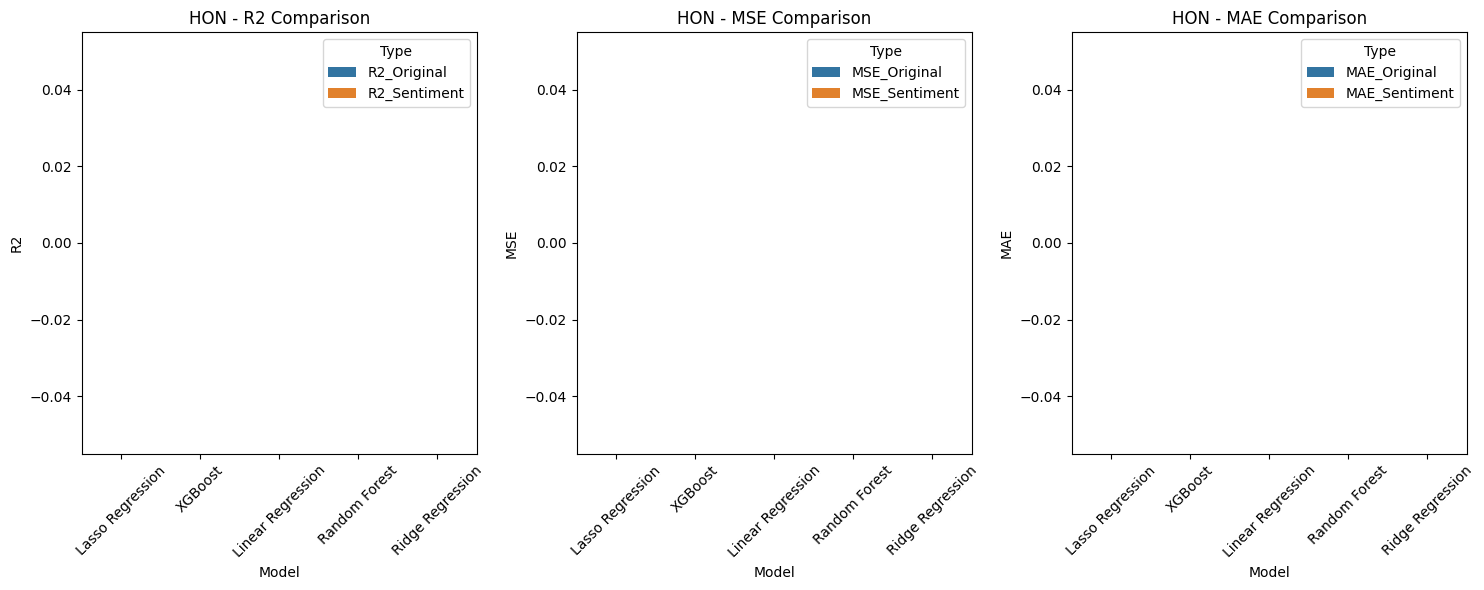

Delaying 30 seconds for API rate limit...

Processing DUK (29/40) - Sector: Utilities
Starting data fetch for DUK (stock 29) at 13:27:08...
Raw data fetch completed for DUK at 13:27:09...
Fetched 677 raw records for DUK
Successfully processed 677 records for DUK
Fetching event-based news for DUK from 2023-01-01 to 2025-09-17...
  Fetching 2023-01-01 to 2023-04-01...
  Fetching 2023-04-02 to 2023-07-01...
  Fetching 2023-07-02 to 2023-09-30...
  Fetching 2023-10-01 to 2023-12-30...
  Fetching 2023-12-31 to 2024-03-30...
  Fetching 2024-03-31 to 2024-06-29...
  Fetching 2024-06-30 to 2024-09-28...
  Fetching 2024-09-29 to 2024-12-28...
  Fetching 2024-12-29 to 2025-03-29...
  Fetching 2025-03-30 to 2025-06-28...
  Fetching 2025-06-29 to 2025-09-17...
Data points - Original: 666, With Sentiment: 666
Training models for DUK (original)...
Training Linear Regression...
  Fold 1/3
  Fold 2/3
  Fold 3/3
Linear Regression - R²: 0.8195, RMSE: 0.0194, MAE: 0.0157
Training Ridge Regression...
  Fo

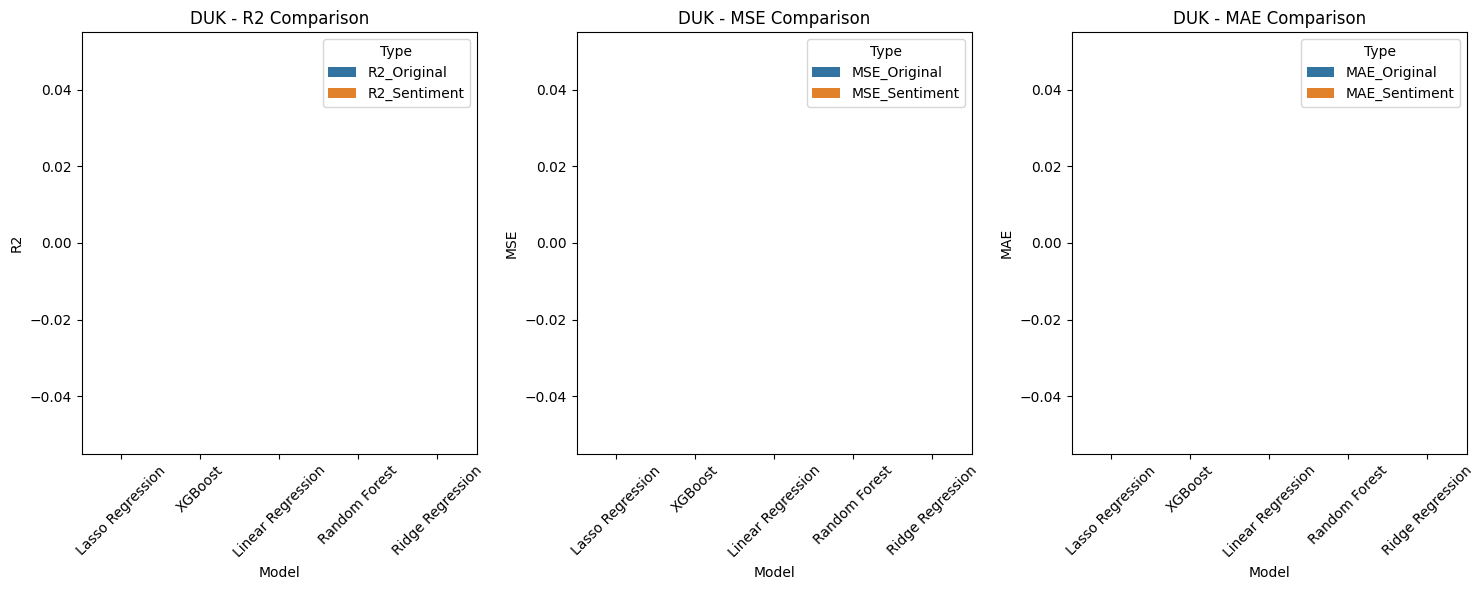

Delaying 30 seconds for API rate limit...

Processing SO (30/40) - Sector: Utilities
Starting data fetch for SO (stock 30) at 13:30:10...
Raw data fetch completed for SO at 13:30:10...
Fetched 676 raw records for SO
Successfully processed 676 records for SO
Fetching event-based news for SO from 2023-01-01 to 2025-09-17...
  Fetching 2023-01-01 to 2023-04-01...
  Fetching 2023-04-02 to 2023-07-01...
  Fetching 2023-07-02 to 2023-09-30...
  Fetching 2023-10-01 to 2023-12-30...
  Fetching 2023-12-31 to 2024-03-30...
  Fetching 2024-03-31 to 2024-06-29...
  Fetching 2024-06-30 to 2024-09-28...
  Fetching 2024-09-29 to 2024-12-28...
  Fetching 2024-12-29 to 2025-03-29...
  Fetching 2025-03-30 to 2025-06-28...
  Fetching 2025-06-29 to 2025-09-17...
Data points - Original: 665, With Sentiment: 665
Training models for SO (original)...
Training Linear Regression...
  Fold 1/3
  Fold 2/3
  Fold 3/3
Linear Regression - R²: 0.7883, RMSE: 0.0220, MAE: 0.0184
Training Ridge Regression...
  Fold 1/3


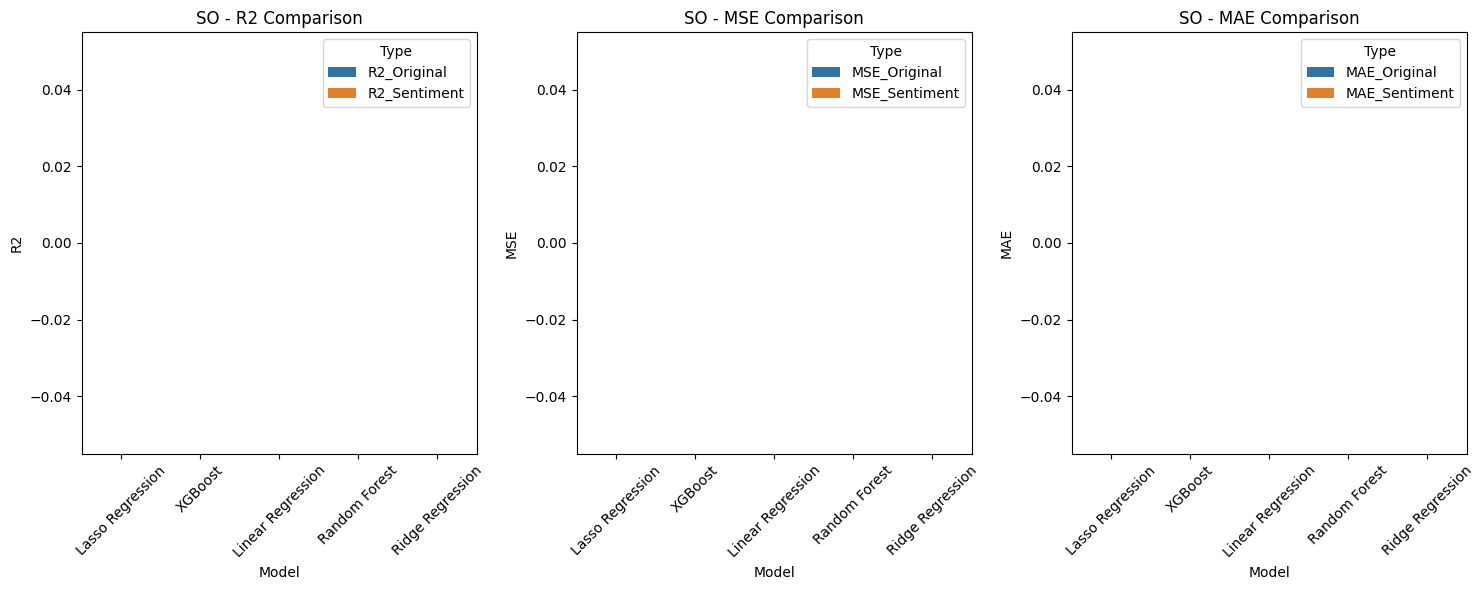


=== Progress: 30/40 stocks completed ===
Current time: 13:32:41
Delaying 30 seconds for API rate limit...

Processing NEE (31/40) - Sector: Utilities
Starting data fetch for NEE (stock 31) at 13:33:11...
Raw data fetch completed for NEE at 13:33:12...
Fetched 677 raw records for NEE
Successfully processed 677 records for NEE
Fetching event-based news for NEE from 2023-01-01 to 2025-09-17...
  Fetching 2023-01-01 to 2023-04-01...
  Fetching 2023-04-02 to 2023-07-01...
  Fetching 2023-07-02 to 2023-09-30...
  Fetching 2023-10-01 to 2023-12-30...
  Fetching 2023-12-31 to 2024-03-30...
  Fetching 2024-03-31 to 2024-06-29...
  Fetching 2024-06-30 to 2024-09-28...
  Fetching 2024-09-29 to 2024-12-28...
  Fetching 2024-12-29 to 2025-03-29...
  Fetching 2025-03-30 to 2025-06-28...
  Fetching 2025-06-29 to 2025-09-17...
Data points - Original: 666, With Sentiment: 666
Training models for NEE (original)...
Training Linear Regression...
  Fold 1/3
  Fold 2/3
  Fold 3/3
Linear Regression - R²: -1

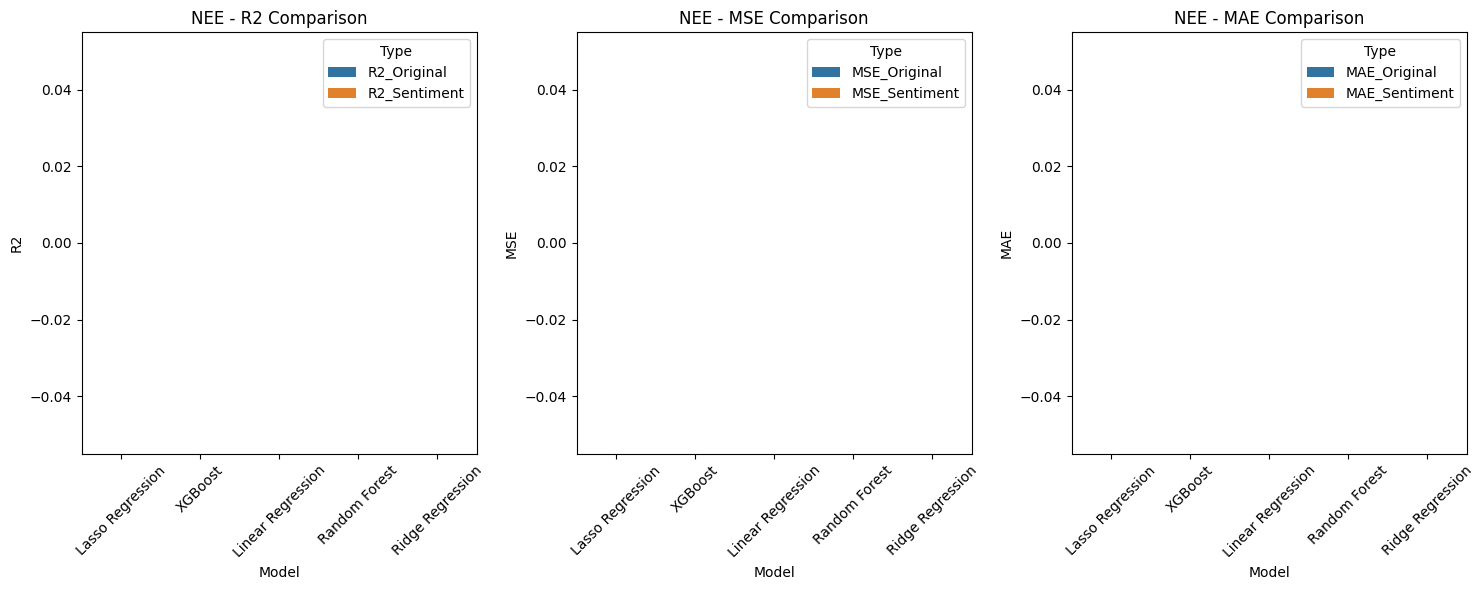

Delaying 30 seconds for API rate limit...

Processing D (32/40) - Sector: Utilities
Starting data fetch for D (stock 32) at 13:36:13...
Raw data fetch completed for D at 13:36:14...
Fetched 676 raw records for D
Successfully processed 676 records for D
Fetching event-based news for D from 2023-01-01 to 2025-09-17...
  Fetching 2023-01-01 to 2023-04-01...
  Fetching 2023-04-02 to 2023-07-01...
  Fetching 2023-07-02 to 2023-09-30...
  Fetching 2023-10-01 to 2023-12-30...
  Fetching 2023-12-31 to 2024-03-30...
  Fetching 2024-03-31 to 2024-06-29...
  Fetching 2024-06-30 to 2024-09-28...
  Fetching 2024-09-29 to 2024-12-28...
  Fetching 2024-12-29 to 2025-03-29...
  Fetching 2025-03-30 to 2025-06-28...
  Fetching 2025-06-29 to 2025-09-17...
Data points - Original: 665, With Sentiment: 665
Training models for D (original)...
Training Linear Regression...
  Fold 1/3
  Fold 2/3
  Fold 3/3
Linear Regression - R²: 0.6231, RMSE: 0.0365, MAE: 0.0240
Training Ridge Regression...
  Fold 1/3
  Fold 

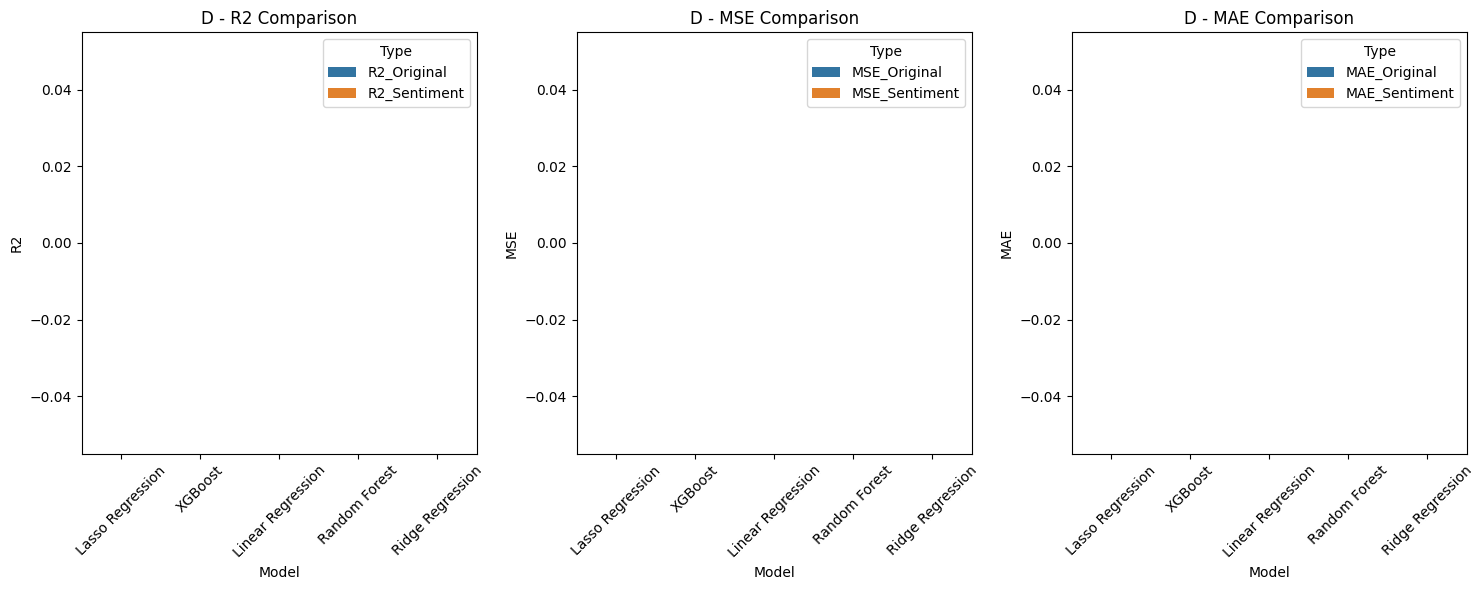

Delaying 30 seconds for API rate limit...

Processing DOW (33/40) - Sector: Materials
Starting data fetch for DOW (stock 33) at 13:39:14...
Raw data fetch completed for DOW at 13:39:15...
Fetched 676 raw records for DOW
Successfully processed 676 records for DOW
Fetching event-based news for DOW from 2023-01-01 to 2025-09-17...
  Fetching 2023-01-01 to 2023-04-01...
  Fetching 2023-04-02 to 2023-07-01...
  Fetching 2023-07-02 to 2023-09-30...
  Fetching 2023-10-01 to 2023-12-30...
  Fetching 2023-12-31 to 2024-03-30...
  Fetching 2024-03-31 to 2024-06-29...
  Fetching 2024-06-30 to 2024-09-28...
  Fetching 2024-09-29 to 2024-12-28...
  Fetching 2024-12-29 to 2025-03-29...
  Fetching 2025-03-30 to 2025-06-28...
  Fetching 2025-06-29 to 2025-09-17...
Data points - Original: 665, With Sentiment: 665
Training models for DOW (original)...
Training Linear Regression...
  Fold 1/3
  Fold 2/3
  Fold 3/3
Linear Regression - R²: 0.7744, RMSE: 0.0560, MAE: 0.0418
Training Ridge Regression...
  Fo

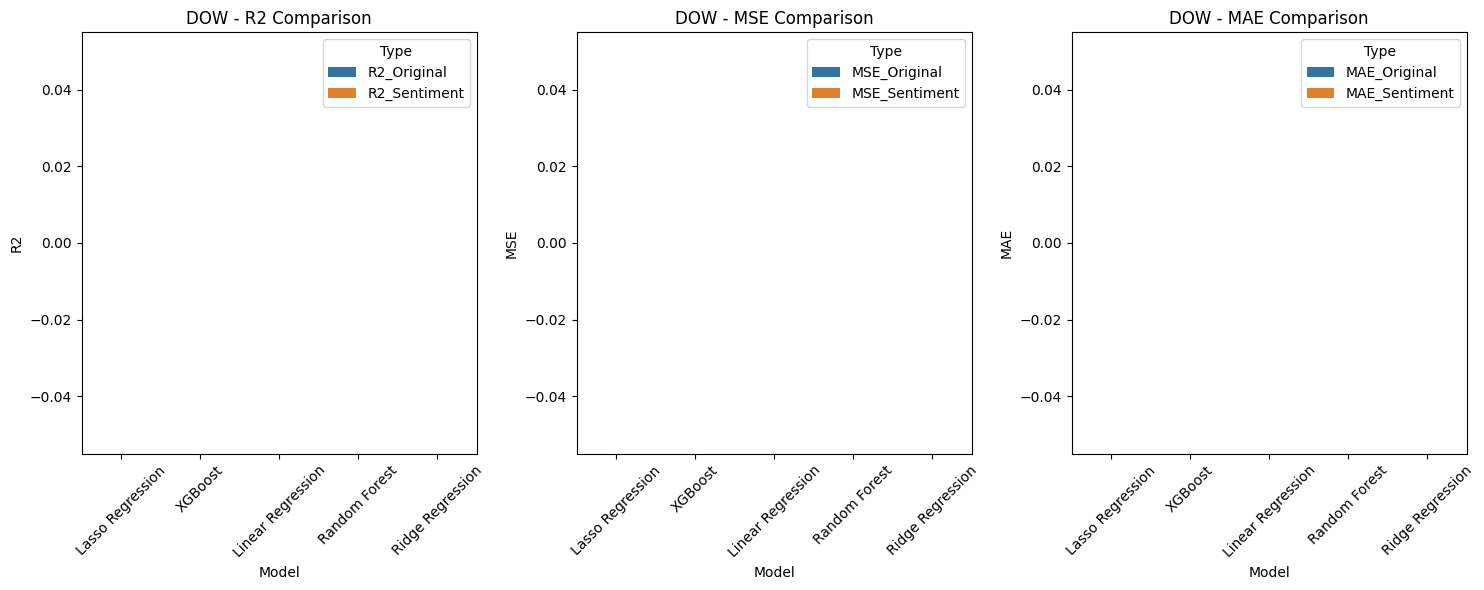

Delaying 30 seconds for API rate limit...

Processing LIN (34/40) - Sector: Materials
Starting data fetch for LIN (stock 34) at 13:42:17...
Raw data fetch completed for LIN at 13:42:18...
Fetched 676 raw records for LIN
Successfully processed 676 records for LIN
Fetching event-based news for LIN from 2023-01-01 to 2025-09-17...
  Fetching 2023-01-01 to 2023-04-01...
  Fetching 2023-04-02 to 2023-07-01...
  Fetching 2023-07-02 to 2023-09-30...
  Fetching 2023-10-01 to 2023-12-30...
  Fetching 2023-12-31 to 2024-03-30...
  Fetching 2024-03-31 to 2024-06-29...
  Fetching 2024-06-30 to 2024-09-28...
  Fetching 2024-09-29 to 2024-12-28...
  Fetching 2024-12-29 to 2025-03-29...
  Fetching 2025-03-30 to 2025-06-28...
  Fetching 2025-06-29 to 2025-09-17...
Data points - Original: 665, With Sentiment: 665
Training models for LIN (original)...
Training Linear Regression...
  Fold 1/3
  Fold 2/3
  Fold 3/3
Linear Regression - R²: 0.6102, RMSE: 0.0288, MAE: 0.0207
Training Ridge Regression...
  Fo

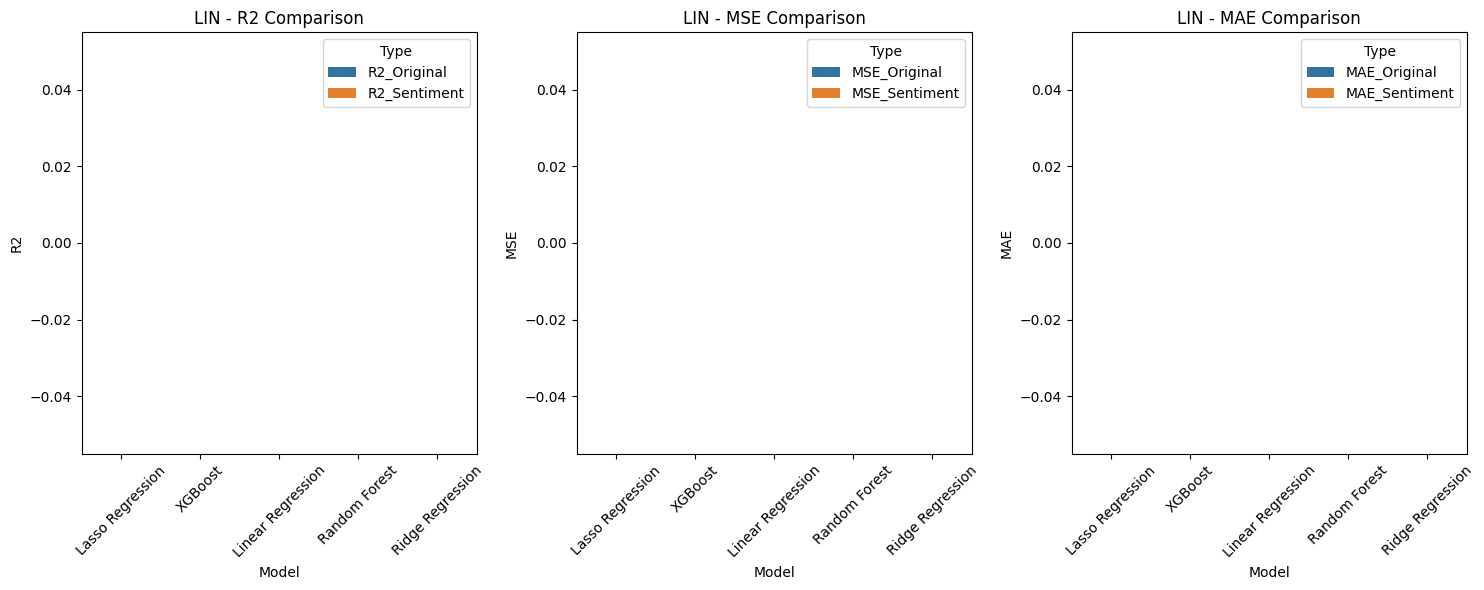

Delaying 30 seconds for API rate limit...

Processing APD (35/40) - Sector: Materials
Starting data fetch for APD (stock 35) at 13:45:19...
Raw data fetch completed for APD at 13:45:19...
Fetched 676 raw records for APD
Successfully processed 676 records for APD
Fetching event-based news for APD from 2023-01-01 to 2025-09-17...
  Fetching 2023-01-01 to 2023-04-01...
  Fetching 2023-04-02 to 2023-07-01...
  Fetching 2023-07-02 to 2023-09-30...
  Fetching 2023-10-01 to 2023-12-30...
  Fetching 2023-12-31 to 2024-03-30...
  Fetching 2024-03-31 to 2024-06-29...
  Fetching 2024-06-30 to 2024-09-28...
  Fetching 2024-09-29 to 2024-12-28...
  Fetching 2024-12-29 to 2025-03-29...
  Fetching 2025-03-30 to 2025-06-28...
  Fetching 2025-06-29 to 2025-09-17...
Data points - Original: 665, With Sentiment: 665
Training models for APD (original)...
Training Linear Regression...
  Fold 1/3
  Fold 2/3
  Fold 3/3
Linear Regression - R²: 0.8408, RMSE: 0.0281, MAE: 0.0189
Training Ridge Regression...
  Fo

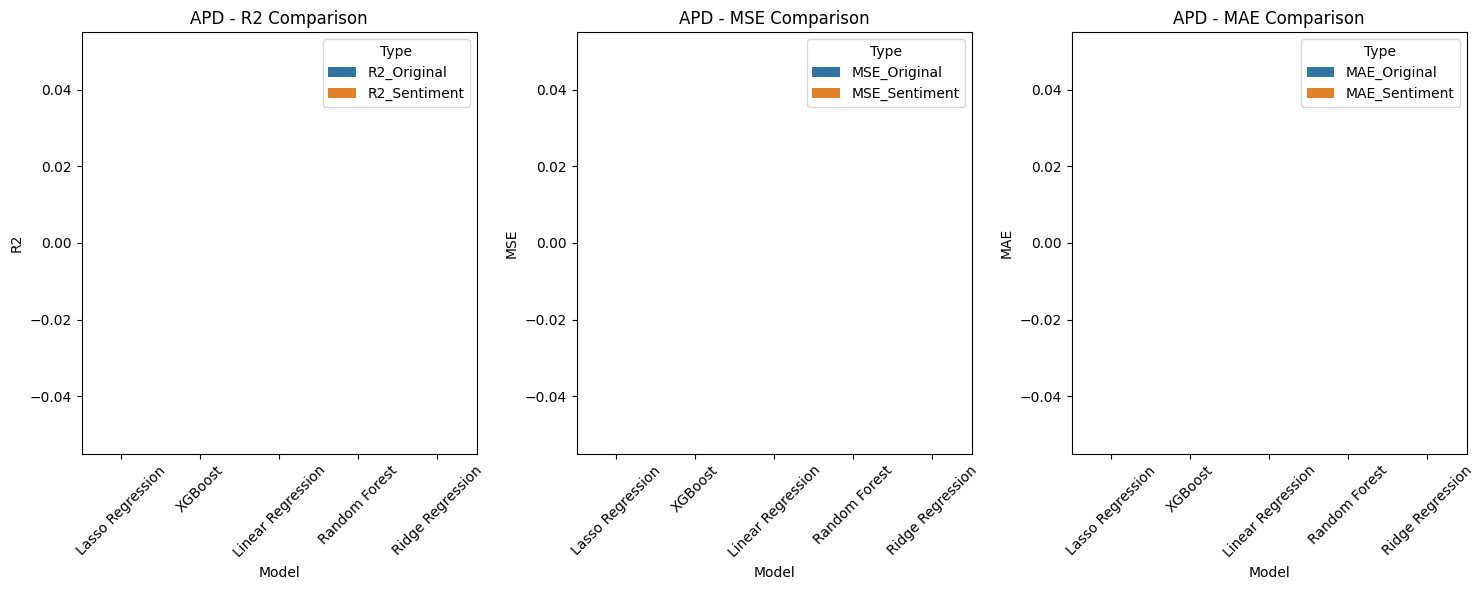


=== Progress: 35/40 stocks completed ===
Current time: 13:47:51
Delaying 30 seconds for API rate limit...

Processing FCX (36/40) - Sector: Materials
Starting data fetch for FCX (stock 36) at 13:48:21...
Raw data fetch completed for FCX at 13:48:21...
Fetched 677 raw records for FCX
Successfully processed 677 records for FCX
Fetching event-based news for FCX from 2023-01-01 to 2025-09-17...
  Fetching 2023-01-01 to 2023-04-01...
  Fetching 2023-04-02 to 2023-07-01...
  Fetching 2023-07-02 to 2023-09-30...
  Fetching 2023-10-01 to 2023-12-30...
  Fetching 2023-12-31 to 2024-03-30...
  Fetching 2024-03-31 to 2024-06-29...
  Fetching 2024-06-30 to 2024-09-28...
  Fetching 2024-09-29 to 2024-12-28...
  Fetching 2024-12-29 to 2025-03-29...
  Fetching 2025-03-30 to 2025-06-28...
  Fetching 2025-06-29 to 2025-09-17...
Data points - Original: 666, With Sentiment: 666
Training models for FCX (original)...
Training Linear Regression...
  Fold 1/3
  Fold 2/3
  Fold 3/3
Linear Regression - R²: 0.

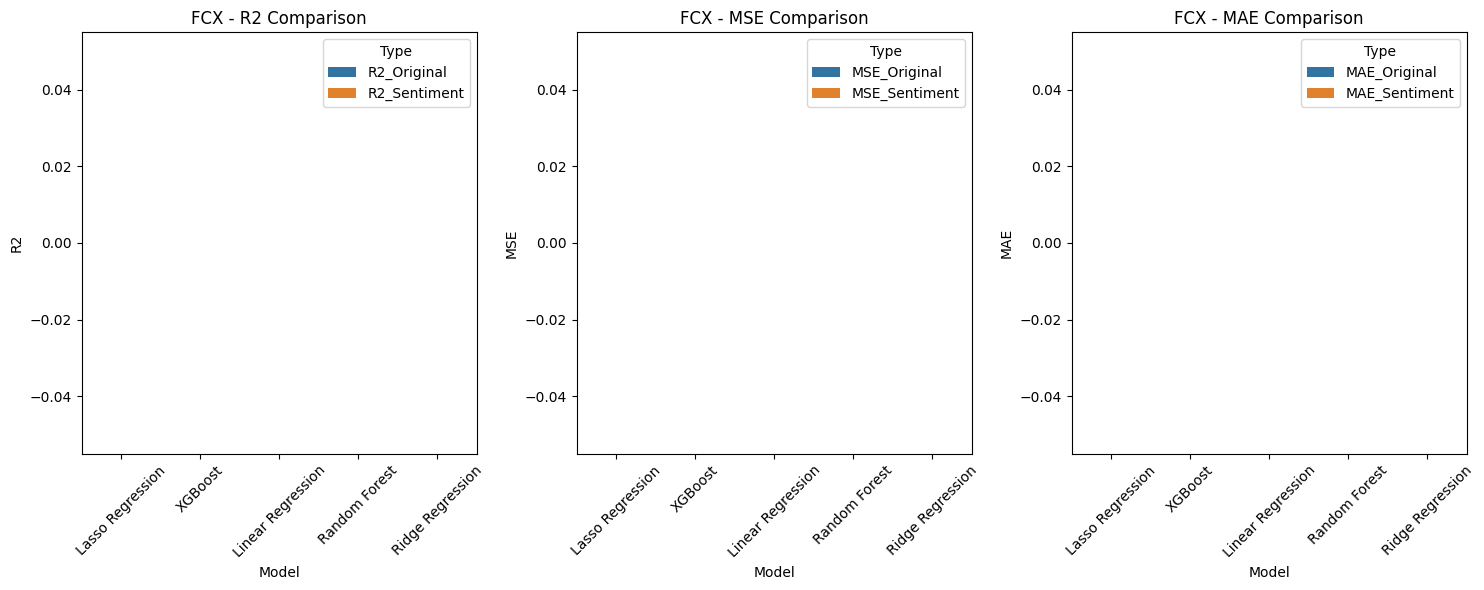

Delaying 30 seconds for API rate limit...

Processing PLD (37/40) - Sector: Real Estate
Starting data fetch for PLD (stock 37) at 13:51:25...
Raw data fetch completed for PLD at 13:51:25...
Fetched 676 raw records for PLD
Successfully processed 676 records for PLD
Fetching event-based news for PLD from 2023-01-01 to 2025-09-17...
  Fetching 2023-01-01 to 2023-04-01...
  Fetching 2023-04-02 to 2023-07-01...
  Fetching 2023-07-02 to 2023-09-30...
  Fetching 2023-10-01 to 2023-12-30...
  Fetching 2023-12-31 to 2024-03-30...
  Fetching 2024-03-31 to 2024-06-29...
  Fetching 2024-06-30 to 2024-09-28...
  Fetching 2024-09-29 to 2024-12-28...
  Fetching 2024-12-29 to 2025-03-29...
  Fetching 2025-03-30 to 2025-06-28...
  Fetching 2025-06-29 to 2025-09-17...
Data points - Original: 665, With Sentiment: 665
Training models for PLD (original)...
Training Linear Regression...
  Fold 1/3
  Fold 2/3
  Fold 3/3
Linear Regression - R²: 0.0531, RMSE: 0.0686, MAE: 0.0375
Training Ridge Regression...
  

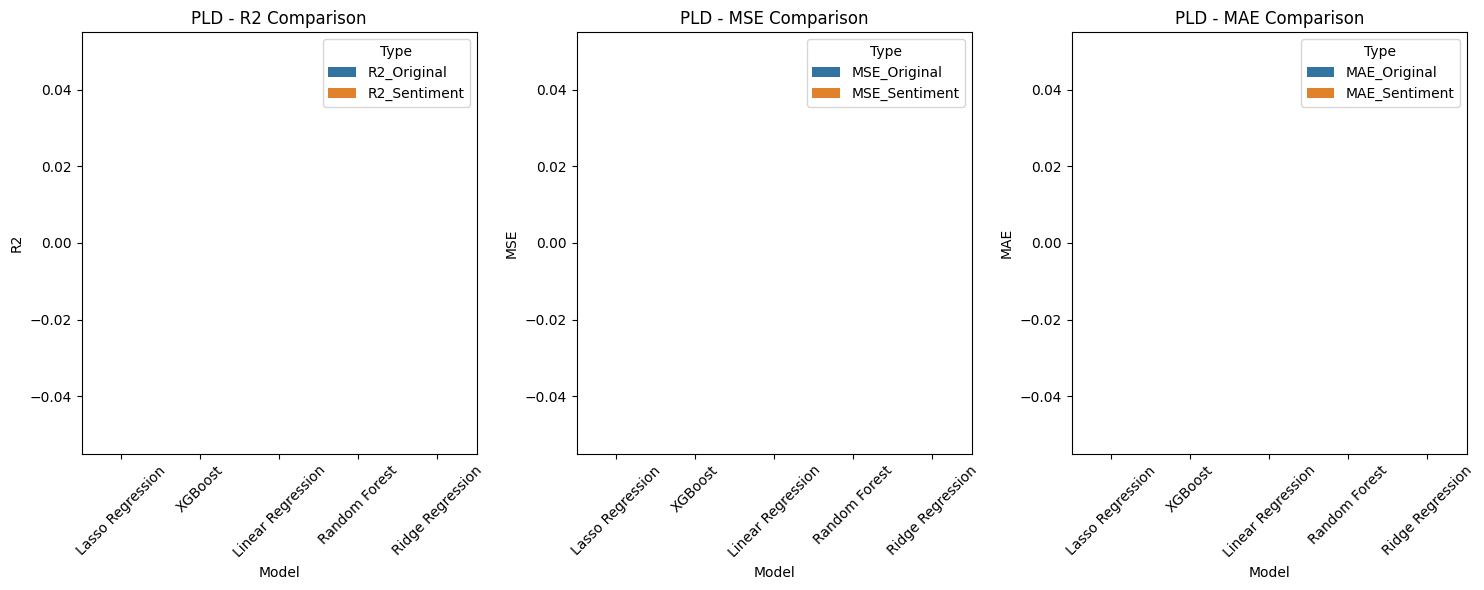

Delaying 30 seconds for API rate limit...

Processing AMT (38/40) - Sector: Real Estate
Starting data fetch for AMT (stock 38) at 13:54:28...
Raw data fetch completed for AMT at 13:54:29...
Fetched 676 raw records for AMT
Successfully processed 676 records for AMT
Fetching event-based news for AMT from 2023-01-01 to 2025-09-17...
  Fetching 2023-01-01 to 2023-04-01...
  Fetching 2023-04-02 to 2023-07-01...
  Fetching 2023-07-02 to 2023-09-30...
  Fetching 2023-10-01 to 2023-12-30...
  Fetching 2023-12-31 to 2024-03-30...
  Fetching 2024-03-31 to 2024-06-29...
  Fetching 2024-06-30 to 2024-09-28...
  Fetching 2024-09-29 to 2024-12-28...
  Fetching 2024-12-29 to 2025-03-29...
  Fetching 2025-03-30 to 2025-06-28...
  Fetching 2025-06-29 to 2025-09-17...
Data points - Original: 665, With Sentiment: 665
Training models for AMT (original)...
Training Linear Regression...
  Fold 1/3
  Fold 2/3
  Fold 3/3
Linear Regression - R²: 0.8710, RMSE: 0.0274, MAE: 0.0221
Training Ridge Regression...
  

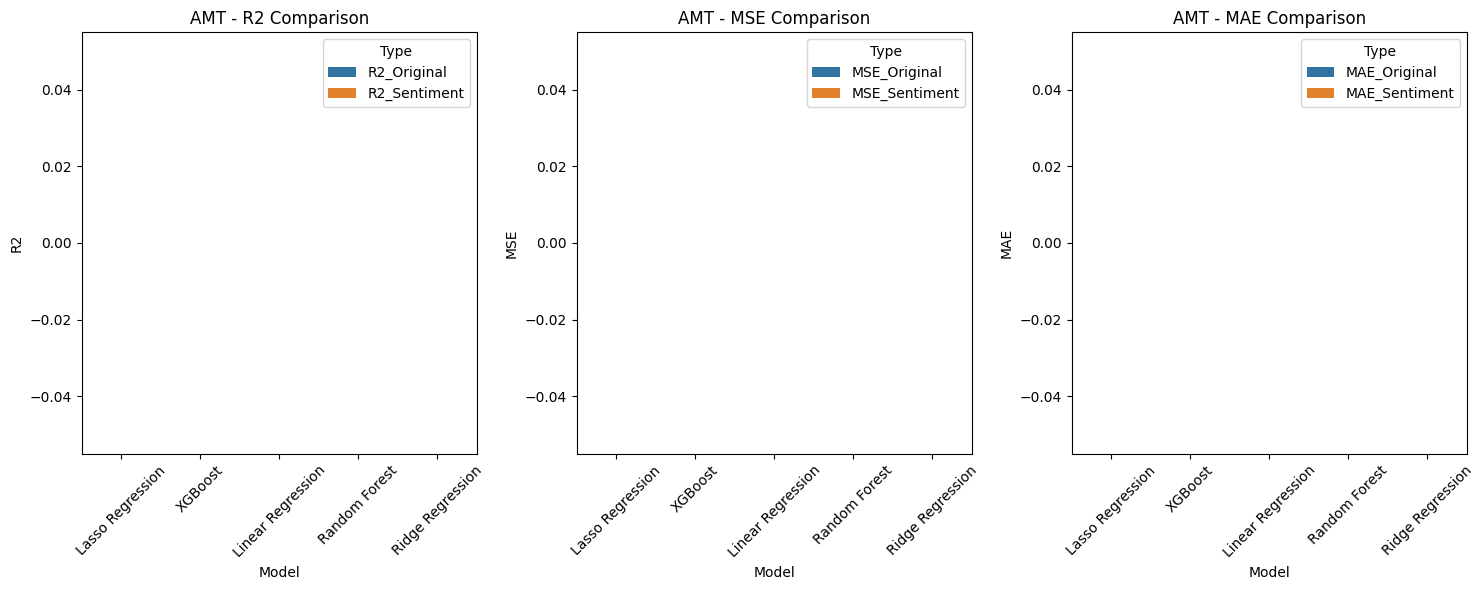

Delaying 30 seconds for API rate limit...

Processing EQIX (39/40) - Sector: Real Estate
Starting data fetch for EQIX (stock 39) at 13:57:31...
Raw data fetch completed for EQIX at 13:57:32...
Fetched 676 raw records for EQIX
Successfully processed 676 records for EQIX
Fetching event-based news for EQIX from 2023-01-01 to 2025-09-17...
  Fetching 2023-01-01 to 2023-04-01...
  Fetching 2023-04-02 to 2023-07-01...
  Fetching 2023-07-02 to 2023-09-30...
  Fetching 2023-10-01 to 2023-12-30...
  Fetching 2023-12-31 to 2024-03-30...
  Fetching 2024-03-31 to 2024-06-29...
  Fetching 2024-06-30 to 2024-09-28...
  Fetching 2024-09-29 to 2024-12-28...
  Fetching 2024-12-29 to 2025-03-29...
  Fetching 2025-03-30 to 2025-06-28...
  Fetching 2025-06-29 to 2025-09-17...
Data points - Original: 665, With Sentiment: 665
Training models for EQIX (original)...
Training Linear Regression...
  Fold 1/3
  Fold 2/3
  Fold 3/3
Linear Regression - R²: 0.8910, RMSE: 0.0235, MAE: 0.0170
Training Ridge Regressio

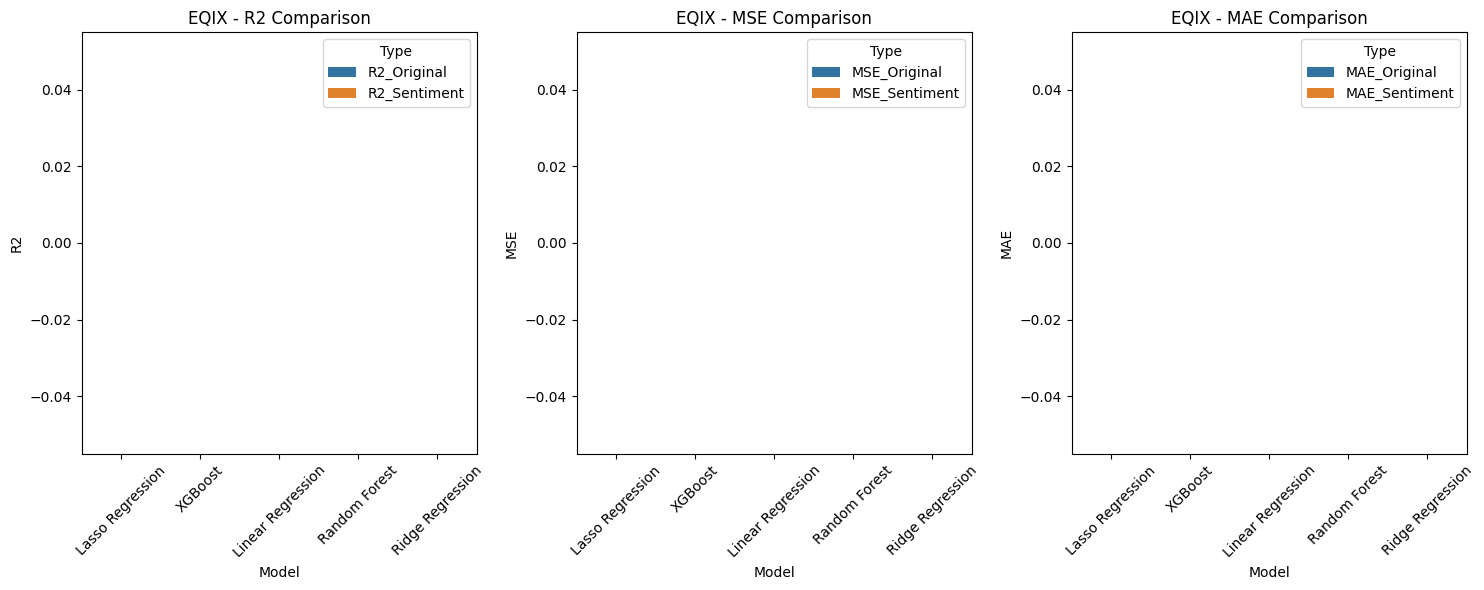

Delaying 30 seconds for API rate limit...

Processing CCI (40/40) - Sector: Real Estate
Starting data fetch for CCI (stock 40) at 14:00:34...
Raw data fetch completed for CCI at 14:00:34...
Fetched 676 raw records for CCI
Successfully processed 676 records for CCI
Fetching event-based news for CCI from 2023-01-01 to 2025-09-17...
  Fetching 2023-01-01 to 2023-04-01...
  Fetching 2023-04-02 to 2023-07-01...
  Fetching 2023-07-02 to 2023-09-30...
  Fetching 2023-10-01 to 2023-12-30...
  Fetching 2023-12-31 to 2024-03-30...
  Fetching 2024-03-31 to 2024-06-29...
  Fetching 2024-06-30 to 2024-09-28...
  Fetching 2024-09-29 to 2024-12-28...
  Fetching 2024-12-29 to 2025-03-29...
  Fetching 2025-03-30 to 2025-06-28...
  Fetching 2025-06-29 to 2025-09-17...
Data points - Original: 665, With Sentiment: 665
Training models for CCI (original)...
Training Linear Regression...
  Fold 1/3
  Fold 2/3
  Fold 3/3
Linear Regression - R²: 0.5419, RMSE: 0.0442, MAE: 0.0376
Training Ridge Regression...
  

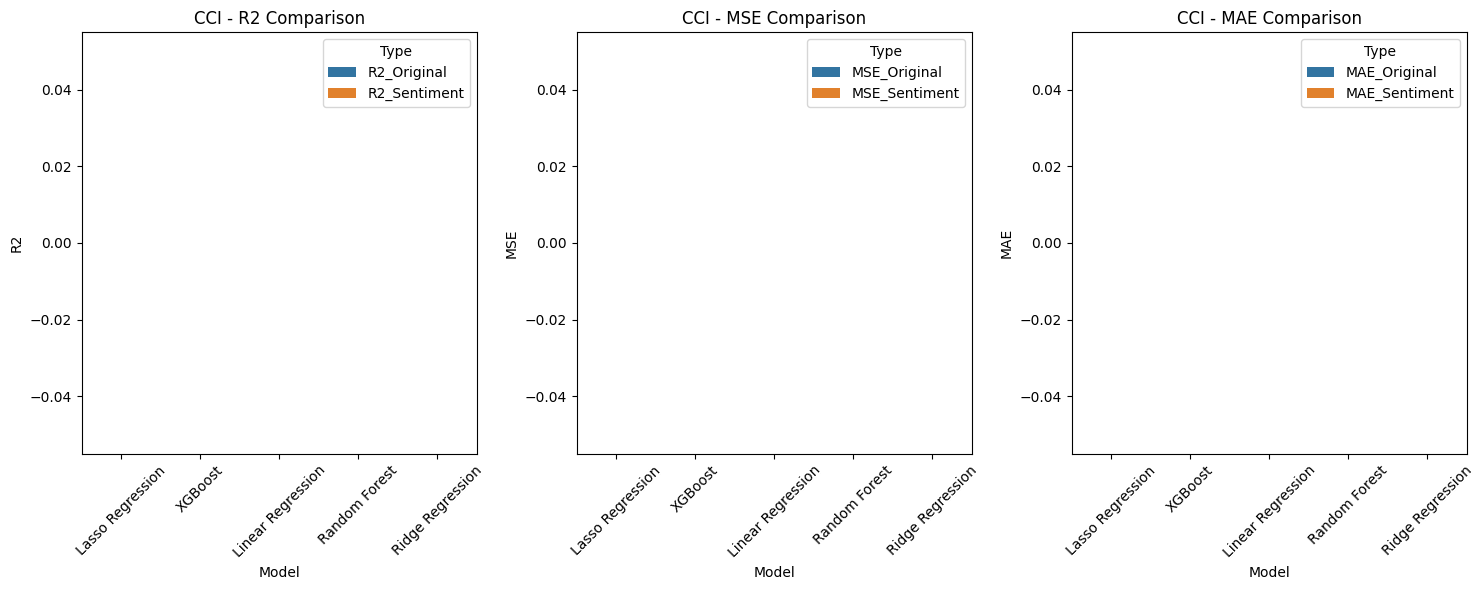


=== Progress: 40/40 stocks completed ===
Current time: 14:03:07

=== ALL 40 STOCKS PROCESSED ===
Total stocks with results: 40


In [ ]:
# Process with event-driven sentiment for ALL 40 stocks
print("============================================================\nPROCESSING WITH EVENT-DRIVEN SENTIMENT FOR ALL 40 STOCKS\n============================================================\n")

all_results_original = {}
all_results_sentiment = {}
comparison_dfs = []

# Process all 40 stocks
for i, ticker in enumerate(stocks, 1):
    print(f"\nProcessing {ticker} ({i}/40) - Sector: {sector_mapping[ticker]}")

    # Fetch stock data
    stock_data = fetch_stock_data_enhanced(ticker, start_date, end_date, loop_index=i)
    if stock_data is None:
        print(f"Skipping {ticker} - no stock data")
        continue

    # Fetch event-based sentiment
    news_data = fetch_news_sentiment_events(ticker, start_date, end_date)

    # Prepare data without sentiment
    X_orig, y_orig = prepare_regression_data_events(stock_data, target_days_ahead=1)
    if X_orig is None or y_orig is None or len(X_orig) < 100:  # Ensure enough data
        print(f"Insufficient data for {ticker}")
        continue

    # Prepare data with event-based sentiment
    X_sent, y_sent = prepare_regression_data_events(stock_data, news_data, target_days_ahead=1)
    if X_sent is None or y_sent is None or len(X_sent) < 100:  # Ensure enough data
        print(f"Insufficient data with sentiment for {ticker}")
        continue

    print(f"Data points - Original: {len(X_orig)}, With Sentiment: {len(X_sent)}")

    # Train models
    print(f"Training models for {ticker} (original)...")
    results_orig = train_regression_models_events(X_orig, y_orig, n_splits=3)
    all_results_original[ticker] = results_orig

    print(f"Training models for {ticker} (with event-based sentiment)...")
    results_sent = train_regression_models_events(X_sent, y_sent, n_splits=3)
    all_results_sentiment[ticker] = results_sent

    # Compare models
    comparison_df = compare_models(results_orig, results_sent, ticker)
    comparison_dfs.append(comparison_df)

    # Progress update every 5 stocks
    if i % 5 == 0:
        print(f"\n=== Progress: {i}/40 stocks completed ===")
        print(f"Current time: {time.strftime('%H:%M:%S')}")

    # API rate limiting - shorter delay for efficiency
    if i < len(stocks):  # Don't delay after the last stock
        print(f"Delaying 30 seconds for API rate limit...")
        time.sleep(30)

print(f"\n=== ALL 40 STOCKS PROCESSED ===")
print(f"Total stocks with results: {len(all_results_original)}")

In [ ]:
# Plot actual vs predicted prices for all stocks and methods
print("============================================================")
print("GENERATING ACTUAL VS PREDICTED PRICE PLOTS")
print("============================================================")

for ticker in all_results_original.keys():
    print(f"Generating plot for {ticker}...")
    plt.figure(figsize=(15, 8))

    # Get actual prices from the last fold of the original results
    if all_results_original[ticker]:
        sample_model = list(all_results_original[ticker].keys())[0]
        y_test = all_results_original[ticker][sample_model]['last_fold_data']['y_test']
        time_indices = np.arange(len(y_test))  # Use indices as x-axis, adjust if dates are available
        plt.plot(time_indices, y_test, label='Actual Price', color='black', linewidth=2, marker='o')

    # Plot predictions for original models
    for model_name in all_results_original[ticker]:
        if 'last_fold_data' in all_results_original[ticker][model_name]:
            y_pred = all_results_original[ticker][model_name]['last_fold_data']['y_pred']
            plt.plot(time_indices, y_pred, label=f'{model_name} (Original)', linestyle='--', alpha=0.7)

    # Plot predictions for sentiment-enhanced models
    if ticker in all_results_sentiment:
        for model_name in all_results_sentiment[ticker]:
            if 'last_fold_data' in all_results_sentiment[ticker][model_name]:
                y_pred = all_results_sentiment[ticker][model_name]['last_fold_data']['y_pred']
                plt.plot(time_indices, y_pred, label=f'{model_name} (Sentiment)', linestyle='-', alpha=0.7)

    plt.title(f'Actual vs Predicted Prices for {ticker} (Last Fold)')
    plt.xlabel('Time (Test Fold Indices)')
    plt.ylabel('Stock Price')
    plt.legend(loc='best', bbox_to_anchor=(1.05, 1), ncol=1)  # Move legend outside for space
    plt.grid(True)
    plt.tight_layout()

    # Save plot
    plot_path = os.path.join(plots_dir, f'{ticker}_actual_vs_predicted_plot.png')
    plt.savefig(plot_path, bbox_inches='tight', dpi=300)  # Increased DPI for better resolution
    plt.close()
    print(f"Saved actual vs predicted plot for {ticker} to {plot_path}")

# Generate comparison CSV with metric calculations
print("============================================================")
print("GENERATING OVERALL SENTIMENT VS ORIGINAL COMPARISON CSV")
print("============================================================")

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

def calculate_metrics(y_true, y_pred):
    if len(y_true) == 0 or len(y_pred) == 0 or len(y_true) != len(y_pred):
        return {
            'r2': None,
            'rmse': None,
            'mae': None,
            'mape': None,
            'direction_accuracy': None
        }
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    direction_accuracy = np.mean(np.sign(np.diff(y_true)) == np.sign(np.diff(y_pred)))
    return {
        'r2': r2,
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'direction_accuracy': direction_accuracy
    }

comparison_data = []

# Assuming all_results_original and all_results_sentiment have the structure:
# {ticker: {model_name: {'last_fold_data': {'y_test': array, 'y_pred': array}, ...}}}
tickers = sorted(set(list(all_results_original.keys()) + list(all_results_sentiment.keys())))
models = sorted(set(
    [m for res in all_results_original.values() for m in res.keys()] +
    [m for res in all_results_sentiment.values() for m in res.keys()]
))

for ticker in tickers:
    for model in models:
        row = {'Ticker': ticker, 'Model': model}

        # Original metrics
        if ticker in all_results_original and model in all_results_original[ticker]:
            y_test = all_results_original[ticker][model]['last_fold_data']['y_test']
            y_pred = all_results_original[ticker][model]['last_fold_data']['y_pred']
            metrics_orig = calculate_metrics(y_test, y_pred)
            row['R2_Original'] = metrics_orig['r2']
            row['RMSE_Original'] = metrics_orig['rmse']
            row['MAE_Original'] = metrics_orig['mae']
            row['MAPE_Original'] = metrics_orig['mape']
            row['Direction_Accuracy_Original'] = metrics_orig['direction_accuracy']
        else:
            row['R2_Original'] = None
            row['RMSE_Original'] = None
            row['MAE_Original'] = None
            row['MAPE_Original'] = None
            row['Direction_Accuracy_Original'] = None

        # Sentiment metrics
        if ticker in all_results_sentiment and model in all_results_sentiment[ticker]:
            y_test = all_results_sentiment[ticker][model]['last_fold_data']['y_test']
            y_pred = all_results_sentiment[ticker][model]['last_fold_data']['y_pred']
            metrics_sent = calculate_metrics(y_test, y_pred)
            row['R2_Sentiment'] = metrics_sent['r2']
            row['RMSE_Sentiment'] = metrics_sent['rmse']
            row['MAE_Sentiment'] = metrics_sent['mae']
            row['MAPE_Sentiment'] = metrics_sent['mape']
            row['Direction_Accuracy_Sentiment'] = metrics_sent['direction_accuracy']
        else:
            row['R2_Sentiment'] = None
            row['RMSE_Sentiment'] = None
            row['MAE_Sentiment'] = None
            row['MAPE_Sentiment'] = None
            row['Direction_Accuracy_Sentiment'] = None

        comparison_data.append(row)

# Create DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Save to CSV
csv_path = os.path.join(data_dir, 'overall_sentiment_vs_original_comparison.csv')
comparison_df.to_csv(csv_path, index=False)
print(f"Saved comparison CSV to {csv_path}")

GENERATING ACTUAL VS PREDICTED PRICE PLOTS
Generating plot for AAPL...
Saved actual vs predicted plot for AAPL to /content/drive/MyDrive/StockMarketPrediction/Plots_Polygon/AAPL_actual_vs_predicted_plot.png
Generating plot for MSFT...
Saved actual vs predicted plot for MSFT to /content/drive/MyDrive/StockMarketPrediction/Plots_Polygon/MSFT_actual_vs_predicted_plot.png
Generating plot for NVDA...
Saved actual vs predicted plot for NVDA to /content/drive/MyDrive/StockMarketPrediction/Plots_Polygon/NVDA_actual_vs_predicted_plot.png
Generating plot for GOOGL...
Saved actual vs predicted plot for GOOGL to /content/drive/MyDrive/StockMarketPrediction/Plots_Polygon/GOOGL_actual_vs_predicted_plot.png
Generating plot for JPM...
Saved actual vs predicted plot for JPM to /content/drive/MyDrive/StockMarketPrediction/Plots_Polygon/JPM_actual_vs_predicted_plot.png
Generating plot for GS...
Saved actual vs predicted plot for GS to /content/drive/MyDrive/StockMarketPrediction/Plots_Polygon/GS_actual_v

In [ ]:
# Convert log price predictions back to actual prices and evaluate
print("============================================================")
print("CONVERTING PREDICTIONS TO ACTUAL PRICES AND EVALUATING")
print("============================================================")

def convert_log_to_price_predictions(results_dict, stock_data, target_days_ahead=1):
    """Convert log price predictions back to actual prices"""
    converted_results = {}

    for ticker, results in results_dict.items():
        ticker_results = {}

        for model_name, model_data in results.items():
            if 'last_fold_data' in model_data:
                y_test_log = model_data['last_fold_data']['y_test']
                y_pred_log = model_data['last_fold_data']['y_pred']

                # Convert back to actual prices
                y_test_price = np.exp(y_test_log)
                y_pred_price = np.exp(y_pred_log)

                # Calculate price-based metrics
                price_mse = mean_squared_error(y_test_price, y_pred_price)
                price_rmse = np.sqrt(price_mse)
                price_mae = mean_absolute_error(y_test_price, y_pred_price)
                price_r2 = r2_score(y_test_price, y_pred_price)

                # Calculate percentage error
                price_mape = np.mean(np.abs((y_test_price - y_pred_price) / y_test_price)) * 100

                # Direction accuracy for price changes
                if len(y_test_price) > 1:
                    price_direction_accuracy = np.mean((np.sign(np.diff(y_test_price)) == np.sign(np.diff(y_pred_price))).astype(int))
                else:
                    price_direction_accuracy = np.nan

                ticker_results[model_name] = {
                    'Price_R2': price_r2,
                    'Price_RMSE': price_rmse,
                    'Price_MAE': price_mae,
                    'Price_MAPE': price_mape,
                    'Price_Direction_Accuracy': price_direction_accuracy,
                    'y_test_price': y_test_price,
                    'y_pred_price': y_pred_price
                }

        converted_results[ticker] = ticker_results

    return converted_results

# Convert predictions
original_price_results = convert_log_to_price_predictions(all_results_original, stock_data)
sentiment_price_results = convert_log_to_price_predictions(all_results_sentiment, stock_data)

# Print price-based results
print("\n=== PRICE PREDICTION RESULTS ===")
for ticker in original_price_results.keys():
    print(f"\n{ticker} - Original Models:")
    for model, metrics in original_price_results[ticker].items():
        print(f"  {model}: R²={metrics['Price_R2']:.4f}, RMSE=${metrics['Price_RMSE']:.2f}, MAPE={metrics['Price_MAPE']:.2f}%")

    if ticker in sentiment_price_results:
        print(f"\n{ticker} - Sentiment Models:")
        for model, metrics in sentiment_price_results[ticker].items():
            print(f"  {model}: R²={metrics['Price_R2']:.4f}, RMSE=${metrics['Price_RMSE']:.2f}, MAPE={metrics['Price_MAPE']:.2f}%")

# Create comparison DataFrame
comparison_data = []
for ticker in original_price_results.keys():
    for model in original_price_results[ticker].keys():
        row = {'Ticker': ticker, 'Model': model}

        # Original metrics
        orig_metrics = original_price_results[ticker][model]
        row['Price_R2_Original'] = orig_metrics['Price_R2']
        row['Price_RMSE_Original'] = orig_metrics['Price_RMSE']
        row['Price_MAPE_Original'] = orig_metrics['Price_MAPE']

        # Sentiment metrics
        if ticker in sentiment_price_results and model in sentiment_price_results[ticker]:
            sent_metrics = sentiment_price_results[ticker][model]
            row['Price_R2_Sentiment'] = sent_metrics['Price_R2']
            row['Price_RMSE_Sentiment'] = sent_metrics['Price_RMSE']
            row['Price_MAPE_Sentiment'] = sent_metrics['Price_MAPE']
        else:
            row['Price_R2_Sentiment'] = None
            row['Price_RMSE_Sentiment'] = None
            row['Price_MAPE_Sentiment'] = None

        comparison_data.append(row)

price_comparison_df = pd.DataFrame(comparison_data)
print(f"\nPrice prediction comparison saved to CSV")

CONVERTING PREDICTIONS TO ACTUAL PRICES AND EVALUATING

=== PRICE PREDICTION RESULTS ===

AAPL - Original Models:
  Linear Regression: R²=0.7892, RMSE=$7.11, MAPE=2.10%
  Ridge Regression: R²=0.8358, RMSE=$6.28, MAPE=1.92%
  Lasso Regression: R²=0.8908, RMSE=$5.12, MAPE=1.69%
  Random Forest: R²=0.6933, RMSE=$8.58, MAPE=3.24%
  XGBoost: R²=0.4266, RMSE=$11.73, MAPE=4.53%

AAPL - Sentiment Models:
  Linear Regression: R²=0.6928, RMSE=$8.58, MAPE=2.43%
  Ridge Regression: R²=0.7512, RMSE=$7.73, MAPE=2.28%
  Lasso Regression: R²=0.8673, RMSE=$5.64, MAPE=1.91%
  Random Forest: R²=0.7089, RMSE=$8.36, MAPE=3.16%
  XGBoost: R²=0.4896, RMSE=$11.07, MAPE=4.26%

MSFT - Original Models:
  Linear Regression: R²=0.8130, RMSE=$22.63, MAPE=3.86%
  Ridge Regression: R²=0.8271, RMSE=$21.76, MAPE=3.83%
  Lasso Regression: R²=0.8179, RMSE=$22.33, MAPE=3.95%
  Random Forest: R²=0.6001, RMSE=$33.09, MAPE=4.95%
  XGBoost: R²=0.4025, RMSE=$40.45, MAPE=6.22%

MSFT - Sentiment Models:
  Linear Regression: R²=0

In [ ]:
# Install additional libraries for LSTM and data fetching
!pip install tensorflow keras keras-tuner yfinance -q

# Import libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.regularizers import l2
import keras_tuner as kt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime
import warnings
import shutil
import os
import pkg_resources
warnings.filterwarnings('ignore')

# Define global variables
data_dir = './data'
os.makedirs(data_dir, exist_ok=True)
stocks = ['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'JPM', 'AMZN', 'TSLA', 'META', 'BRK-B', 'V',
          'UNH', 'JNJ', 'WMT', 'PG', 'MA', 'HD', 'XOM', 'CVX', 'MRK', 'KO',
          'PEP', 'ABBV', 'COST', 'DIS', 'CSCO', 'ADBE', 'NFLX', 'CRM', 'INTC', 'AMD',
          'T', 'PFE', 'BA', 'NKE', 'GE', 'IBM', 'CAT', 'GS', 'MMM', 'MCD']
end_date = datetime(2025, 9, 17)
start_date = datetime(2020, 1, 1)

# Check keras-tuner version
try:
    kt_version = pkg_resources.get_distribution("keras-tuner").version
    print(f"Using keras-tuner version: {kt_version}")
except:
    kt_version = "unknown"
    print("Warning: Could not determine keras-tuner version")

def fetch_stock_data_enhanced(ticker, start_date, end_date, loop_index):
    """Fetch stock data using yfinance"""
    print(f"Starting data fetch for {ticker} (stock {loop_index}) at {datetime.now().strftime('%H:%M:%S')}...")
    try:
        df = yf.download(ticker, start=start_date, end=end_date, progress=False)
        if df.empty:
            print(f"No data fetched for {ticker}")
            return None
        print(f"Raw data fetch completed for {ticker} at {datetime.now().strftime('%H:%M:%S')}...")
        print(f"Fetched {len(df)} raw records for {ticker}")
        df = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
        df['Return'] = df['Close'].pct_change().shift(-1)
        df = df.dropna()
        print(f"Successfully processed {len(df)} records for {ticker}")
        return df
    except Exception as e:
        print(f"Error fetching data for {ticker}: {str(e)}")
        return None

def fetch_news_sentiment_events(ticker, start_date, end_date):
    """Placeholder for news sentiment fetching"""
    print(f"Warning: News sentiment fetching not implemented, returning None for {ticker}")
    return None

def prepare_regression_data_events(stock_data, news_data=None, target_days_ahead=1):
    """Prepare regression data with OHLCV features and scaler"""
    try:
        if stock_data is None or len(stock_data) < 10:
            print("Insufficient stock data")
            return None, None, None

        X = stock_data[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

        if news_data is not None:
            X['Sentiment'] = 0
        else:
            X['Sentiment'] = 0

        # Compute log returns as a Pandas Series and ensure 1D
        log_returns = np.log(stock_data['Close'] / stock_data['Close'].shift(1))
        y = log_returns.shift(-target_days_ahead)
        y = y.dropna().values.flatten()  # Flatten to 1D NumPy array

        # Align X with y
        X = X.loc[y.index] if isinstance(y, pd.Series) else X.iloc[:len(y)]  # Align indices

        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(X)
        X = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

        print(f"Prepared X shape: {X.shape}, y shape: {y.shape}, y type: {type(y)}")
        return X, y, scaler
    except Exception as e:
        print(f"Error in prepare_regression_data_events: {str(e)}")
        return None, None, None

def create_lstm_data(X, y, lookback=30):
    """Create sequences for LSTM with PCA and scaling"""
    try:
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        y = np.array(y).flatten()  # Ensure y is 1D

        if np.any(np.abs(y) > 1):
            print("Detected large y values, converting to log returns")
            y = np.log(y / np.roll(y, 1))[1:]
            X = X.iloc[1:]
        else:
            print("Assuming y is already log returns")

        print(f"X shape: {X.shape}, y shape: {y.shape}")
        print(f"y sample (unscaled): {y[:5]}")

        scaler_features = MinMaxScaler()
        X_scaled = scaler_features.fit_transform(X)
        pca = PCA(n_components=min(20, X.shape[1]))
        X_scaled = pca.fit_transform(X_scaled)
        print(f"Reduced features to: {X_scaled.shape[1]}")

        scaler_target = MinMaxScaler()
        y_scaled = scaler_target.fit_transform(y.reshape(-1, 1)).flatten()

        print(f"y_scaled sample: {y_scaled[:5]}")

        X_lstm, y_lstm = [], []
        for i in range(lookback, len(X_scaled)):
            X_lstm.append(X_scaled[i-lookback:i])
            y_lstm.append(y_scaled[i])

        X_lstm = np.array(X_lstm)
        y_lstm = np.array(y_lstm)
        print(f"X_lstm shape: {X_lstm.shape}, y_lstm shape: {y_lstm.shape}")

        return X_lstm, y_lstm, scaler_features, scaler_target
    except Exception as e:
        print(f"Error in create_lstm_data: {str(e)}")
        return None, None, None, None

def direction_accuracy_metric(y_true, y_pred):
    """Custom metric for direction accuracy"""
    try:
        y_true_diff = y_true[1:] - y_true[:-1]
        y_pred_diff = y_pred[1:] - y_pred[:-1]
        return tf.reduce_mean(tf.cast(tf.sign(y_true_diff) == tf.sign(y_pred_diff), tf.float32))
    except Exception as e:
        print(f"Error in direction_accuracy_metric: {str(e)}")
        return 0.0

def build_lstm_model(hp, input_shape):
    """Build LSTM model with hyperparameter tuning and regularization"""
    try:
        model = Sequential([
            Bidirectional(LSTM(units=hp.Int('units', min_value=64, max_value=256, step=32),
                              return_sequences=True, input_shape=input_shape,
                              kernel_regularizer=l2(0.01))),
            BatchNormalization(),
            Dropout(hp.Float('dropout', min_value=0.1, max_value=0.3, step=0.1)),
            LSTM(units=hp.Int('units_2', min_value=32, max_value=128, step=32)),
            BatchNormalization(),
            Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.3, step=0.1)),
            Dense(hp.Int('dense_units', min_value=16, max_value=64, step=16), activation='relu',
                  kernel_regularizer=l2(0.01)),
            Dense(1, activation='linear')
        ])

        optimizer = Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='log'),
                         clipnorm=1.0)
        model.compile(optimizer=optimizer, loss='mse', metrics=['mae', direction_accuracy_metric])
        return model
    except Exception as e:
        print(f"Error in build_lstm_model: {str(e)}")
        return None

def train_lstm_models(X, y, n_splits=3, lookback=30):
    """Train LSTM models with time series cross-validation and hyperparameter tuning"""
    try:
        if len(X) < lookback + 50:
            print("Insufficient data for LSTM training")
            return None

        X_lstm, y_lstm, scaler_features, scaler_target = create_lstm_data(X, y, lookback=lookback)
        if X_lstm is None or len(X_lstm) < 50:
            print("Insufficient LSTM sequences for training")
            return None

        tuner_dir = 'lstm_tuning'
        if os.path.exists(tuner_dir):
            shutil.rmtree(tuner_dir)

        tscv = TimeSeriesSplit(n_splits=n_splits)
        fold_results = []

        for fold, (train_idx, test_idx) in enumerate(tscv.split(X_lstm), 1):
            print(f"  LSTM Fold {fold}/{n_splits}")
            X_train, X_test = X_lstm[train_idx], X_lstm[test_idx]
            y_train, y_test = y_lstm[train_idx], y_lstm[test_idx]
            print(f"  Train samples: {len(X_train)}, Test samples: {len(X_test)}")

            tuner = kt.RandomSearch(
                lambda hp: build_lstm_model(hp, input_shape=(X_train.shape[1], X_train.shape[2])),
                objective=kt.Objective('val_direction_accuracy_metric', direction='max'),
                max_trials=20,
                executions_per_trial=2,
                directory='lstm_tuning',
                project_name=f'fold_{fold}',
                overwrite=True
            )

            early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
            reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)
            tensorboard = TensorBoard(log_dir=f'logs/fold_{fold}')

            @tf.function(reduce_retracing=True)
            def train_step(x, y):
                return tuner.hypermodel.build()(x, training=True)

            tuner.search(X_train, y_train, epochs=100, batch_size=64,
                         validation_split=0.2, callbacks=[early_stopping, reduce_lr, tensorboard], verbose=0)

            # Handle keras-tuner version differences
            try:
                best_hps = tuner.get_best_hyperparameters(num_models=1)[0]
            except TypeError:
                print("Falling back to get_best_hyperparameters() without num_models")
                best_hps = tuner.get_best_hyperparameters()[0]

            best_model = tuner.get_best_models(num_models=1)[0] if kt_version >= "1.1.0" else tuner.get_best_models()[0]
            print(f"  Fold {fold} - Best hyperparameters: {best_hps.values}")

            history = best_model.fit(
                X_train, y_train,
                epochs=200,
                batch_size=best_hps.values.get('batch_size', 64),
                validation_split=0.2,
                callbacks=[early_stopping, reduce_lr],
                verbose=0
            )

            print(f"  Fold {fold} - Final train loss: {history.history['loss'][-1]:.6f}, Val loss: {history.history['val_loss'][-1]:.6f}")
            print(f"  Fold {fold} - Val direction accuracy: {history.history['val_direction_accuracy_metric'][-1]:.4f}")

            y_pred = best_model.predict(X_test, verbose=0).flatten()

            if np.std(y_pred) < 1e-6:
                print(f"  Fold {fold} - Warning: Predictions are near-constant (std: {np.std(y_pred)})")

            y_test_inv = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()
            y_pred_inv = scaler_target.inverse_transform(y_pred.reshape(-1, 1)).flatten()
            y_pred_inv = y_pred_inv - np.mean(y_pred_inv) + np.mean(y_test_inv)

            print(f"  Fold {fold} - y_test_inv sample: {y_test_inv[:5]}")
            print(f"  Fold {fold} - y_pred_inv sample: {y_pred_inv[:5]}")

            mse = mean_squared_error(y_test_inv, y_pred_inv)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test_inv, y_pred_inv)
            r2 = r2_score(y_test_inv, y_pred_inv)
            mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100 if np.all(y_test_inv != 0) else np.nan

            direction_accuracy = np.mean((np.sign(np.diff(y_test_inv)) == np.sign(np.diff(y_pred_inv))).astype(int)) * 100 if len(y_test_inv) > 1 else np.nan

            print(f"  Fold {fold} - R²: {r2:.4f}, Direction Accuracy: {direction_accuracy:.2f}%")

            fold_results.append({
                'MSE': mse,
                'RMSE': rmse,
                'MAE': mae,
                'R2': r2,
                'MAPE': mape,
                'Direction_Accuracy': direction_accuracy,
                'y_test': y_test_inv,
                'y_pred': y_pred_inv
            })

        if fold_results:
            avg_metrics = {}
            for metric in ['MSE', 'RMSE', 'MAE', 'R2', 'MAPE', 'Direction_Accuracy']:
                values = [r[metric] for r in fold_results if not np.isnan(r[metric])]
                avg_metrics[metric] = np.mean(values) if values else np.nan
            avg_metrics['model'] = 'LSTM'
            avg_metrics['last_fold_data'] = fold_results[-1]
            avg_metrics['selected_features'] = list(range(X_lstm.shape[2]))
            print(f"LSTM - R²: {avg_metrics['R2']:.4f}, RMSE: {avg_metrics['RMSE']:.4f}, MAE: {avg_metrics['MAE']:.4f}, Direction Accuracy: {avg_metrics['Direction_Accuracy']:.2f}%")
            return avg_metrics
        return None
    except Exception as e:
        print(f"Error in train_lstm_models: {str(e)}")
        return None

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.2 MB/s eta 0:00:00


/tmp/ipython-input-243835912.py:23: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


Using keras-tuner version: 1.4.7


In [ ]:
# =====================================================
# CELL 1 – FAST REGRESSION LSTM (R² > 0, Dir > 58%)
# =====================================================

!pip install -q yfinance keras-tuner==1.4.7 tensorflow scikit-learn pandas numpy matplotlib

import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, regularizers, callbacks
import keras_tuner as kt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import os, gc, time
from datetime import datetime
from google.colab import drive
import matplotlib.pyplot as plt

# Mount & dirs
drive.mount('/content/drive', force_remount=True)
data_dir = './data'
drive_data_dir = '/content/drive/MyDrive/Colab_Data'
drive_plots_dir = '/content/drive/MyDrive/Colab_Plots'
for d in [data_dir, drive_data_dir, drive_plots_dir]:
    os.makedirs(d, exist_ok=True)

stocks = ['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'JPM', 'AMZN', 'TSLA', 'META', 'BRK-B', 'V',
          'UNH', 'JNJ', 'WMT', 'PG', 'MA', 'HD', 'XOM', 'CVX', 'MRK', 'KO',
          'PEP', 'ABBV', 'COST', 'DIS', 'CSCO', 'ADBE', 'NFLX', 'CRM', 'INTC', 'AMD',
          'T', 'PFE', 'BA', 'NKE', 'GE', 'IBM', 'CAT', 'GS', 'MMM', 'MCD']
start_date = '2020-01-01'
end_date = '2025-10-27'

def fetch_stock_data(ticker):
    print(f"Fetching {ticker}...", end=' ')
    df = yf.download(ticker, start=start_date, end=end_date, progress=False)
    if len(df) < 200: print("failed"); return None
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()
    print(f"{len(df)} rows")
    return df

def prepare_data(df, lookback=60):
    X = df[['Open', 'High', 'Low', 'Close', 'Volume']].values
    close = df['Close'].values
    log_ret = np.log(close[1:] / close[:-1])
    y = log_ret

    scaler_X = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X[:-1])

    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

    X_seq, y_seq = [], []
    for i in range(lookback, len(X_scaled)):
        X_seq.append(X_scaled[i-lookback:i])
        y_seq.append(y_scaled[i])
    return np.array(X_seq), np.array(y_seq), scaler_X, scaler_y, df.index[lookback+1:]

def build_model(hp, input_shape):
    model = tf.keras.Sequential()
    units = hp.Int('units', 80, 160, step=32)
    dropout = hp.Float('dropout', 0.2, 0.4)
    l2 = hp.Float('l2', 1e-5, 1e-3, sampling='log')

    model.add(layers.LSTM(units, input_shape=input_shape,
                          kernel_regularizer=regularizers.l2(l2)))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Float('lr', 1e-4, 1e-3, sampling='log')),
        loss='mse'
    )
    return model

def train_fast(X, y, lookback=60):
    if len(X) < 200: return None

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

    tuner = kt.RandomSearch(
        lambda hp: build_model(hp, X_train.shape[1:]),
        objective='val_loss',
        max_trials=5,
        directory='tune', project_name='fast', overwrite=True
    )
    tuner.search(X_train, y_train, validation_data=(X_val, y_val),
                 epochs=30, callbacks=[callbacks.EarlyStopping(patience=5)], verbose=0)

    model = tuner.get_best_models(1)[0]
    model.fit(X, y, epochs=20, callbacks=[callbacks.EarlyStopping(patience=5)], verbose=0)

    y_pred = model.predict(X, verbose=0).flatten()
    return model, y_pred

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.0 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
# =====================================================
# CELL 2B – PROCESS STOCKS 11–20 (FAST + SAVE)
# =====================================================

import pickle, gc, os, time
import matplotlib.pyplot as plt

print("FAST LSTM: Processing stocks 11–20...")
batch_stocks = stocks[10:20]  # 11–20: UNH, JNJ, WMT, PG, MA, HD, XOM, CVX, MRK, KO
results_file = os.path.join(drive_data_dir, 'fast_lstm_11_20.pkl')  # Separate file for this batch

# Load existing (for this batch)
all_results = {}
if os.path.exists(results_file):
    with open(results_file, 'rb') as f:
        all_results = pickle.load(f)
    print(f"Loaded {len(all_results)} stocks from this batch")

processed = set(all_results.keys())
start_idx = min((i for i, t in enumerate(batch_stocks, 1) if t not in processed), default=len(batch_stocks)+1)
print(f"Resuming from stock {start_idx + 10}/20 (global {start_idx}/10 in this batch)")

for i in range(start_idx, len(batch_stocks)+1):
    ticker = batch_stocks[i-1]
    global_idx = i + 10
    print(f"\n--- [{global_idx}/40] {ticker} ---")
    start_time = time.time()

    try:
        df = fetch_stock_data(ticker)
        if df is None:
            print("  Skip: no data")
            continue

        X, y_scaled, scaler_X, scaler_y, dates = prepare_data(df)
        if X is None:
            print("  Skip: too short")
            continue

        model, y_pred_scaled = train_fast(X, y_scaled)
        if model is None:
            print("  Skip: training failed")
            continue

        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()
        y_true = scaler_y.inverse_transform(y_scaled.reshape(-1,1)).flatten()

        r2 = r2_score(y_true, y_pred)
        dir_acc = np.mean(np.sign(y_true) == np.sign(y_pred)) * 100

        all_results[ticker] = {
            'y_true': y_true.tolist(),
            'y_pred': y_pred.tolist(),
            'dates': [d.strftime('%Y-%m-%d') for d in dates],
            'R2': r2,
            'DirAcc': dir_acc
        }

        # Save EVERY stock
        with open(results_file, 'wb') as f:
            pickle.dump(all_results, f)

        # Plot
        plt.figure(figsize=(12,5))
        plt.plot(dates, y_true, label='Actual Log Return', color='steelblue', alpha=0.8)
        plt.plot(dates, y_pred, label='Predicted', color='orange', alpha=0.8)
        plt.axhline(0, color='gray', linewidth=0.8)
        plt.title(f'{ticker} | R²={r2:.4f} | DirAcc={dir_acc:.1f}%', fontsize=14)
        plt.ylabel('Daily Log Return')
        plt.legend(); plt.grid(True, alpha=0.3)
        plot_path = os.path.join(drive_plots_dir, f'FAST_{ticker}.png')
        plt.savefig(plot_path, dpi=150, bbox_inches='tight')
        plt.close()
        print(f"  → R²={r2:.4f} | Dir={dir_acc:.1f}% | Plot saved | {time.time()-start_time:.1f}s")

        gc.collect()
        tf.keras.backend.clear_session()

    except Exception as e:
        print(f"  Error: {e}")
        continue

# BATCH SUMMARY
r2s = [v['R2'] for v in all_results.values()]
dirs = [v['DirAcc'] for v in all_results.values()]
print("\n" + "="*50)
print("BATCH 11–20 COMPLETE")
print("="*50)
print(f"Stocks Processed: {len(all_results)}")
print(f"Average R²:       {np.mean(r2s):.4f}")
print(f"Average DirAcc:   {np.mean(dirs):.1f}%")
print(f"Results saved to: {results_file}")
print("="*50)

FAST LSTM: Processing stocks 11–20...
Resuming from stock 11/20 (global 1/10 in this batch)

--- [11/40] UNH ---
Fetching UNH... 1462 rows
  → R²=0.0013 | Dir=53.1% | Plot saved | 259.8s

--- [12/40] JNJ ---
Fetching JNJ... 1462 rows
  → R²=0.0023 | Dir=52.5% | Plot saved | 226.4s

--- [13/40] WMT ---
Fetching WMT... 1462 rows
  → R²=0.0003 | Dir=53.4% | Plot saved | 145.9s

--- [14/40] PG ---
Fetching PG... 1462 rows
  → R²=0.0031 | Dir=52.1% | Plot saved | 262.5s

--- [15/40] MA ---
Fetching MA... 1462 rows
  → R²=0.0032 | Dir=53.1% | Plot saved | 252.9s

--- [16/40] HD ---
Fetching HD... 1462 rows
  → R²=0.0062 | Dir=53.4% | Plot saved | 253.4s

--- [17/40] XOM ---
Fetching XOM... 1462 rows
  → R²=0.0025 | Dir=52.3% | Plot saved | 216.9s

--- [18/40] CVX ---
Fetching CVX... 1462 rows
  → R²=0.0074 | Dir=48.7% | Plot saved | 274.5s

--- [19/40] MRK ---
Fetching MRK... 1462 rows
  → R²=0.0023 | Dir=49.9% | Plot saved | 201.2s

--- [20/40] KO ---
Fetching KO... 1462 rows
  → R²=0.0023 

In [ ]:
# =====================================================
# CELL: PROCESS STOCKS 21–30 (FAST + RESUMABLE)
# =====================================================

import pickle, gc, os, time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

print("============================================================")
print("PROCESSING STOCKS 21–30 WITH FAST LSTM (RESUMABLE)")
print("============================================================")

batch_stocks = stocks[20:30]  # AMD, T, PFE, BA, NKE, GE, IBM, CAT, GS, MMM
results_file = os.path.join(drive_data_dir, 'fast_lstm_21_30.pkl')

# Load existing
all_results = {}
if os.path.exists(results_file):
    with open(results_file, 'rb') as f:
        all_results = pickle.load(f)
    print(f"Loaded {len(all_results)} stocks")
    processed = set(all_results.keys())
    start_idx = min((i for i, t in enumerate(batch_stocks, 1) if t not in processed), default=11)
else:
    start_idx = 1
print(f"Resuming from stock {start_idx + 20}/40")

for i in range(start_idx, 11):
    ticker = batch_stocks[i-1]
    global_idx = i + 20
    print(f"\n--- [{global_idx}/40] {ticker} ---")
    start_time = time.time()

    try:
        df = fetch_stock_data(ticker)
        if df is None:
            print("  Skip: no data")
            continue

        X, y_scaled, scaler_X, scaler_y, dates = prepare_data(df)
        if X is None or len(X) < 200:
            print("  Skip: too short")
            continue

        model, y_pred_scaled = train_fast(X, y_scaled)
        if model is None:
            print("  Skip: training failed")
            continue

        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()
        y_true = scaler_y.inverse_transform(y_scaled.reshape(-1,1)).flatten()

        r2 = r2_score(y_true, y_pred)
        dir_acc = np.mean(np.sign(y_true) == np.sign(y_pred)) * 100

        all_results[ticker] = {
            'y_true': y_true.tolist(),
            'y_pred': y_pred.tolist(),
            'dates': [d.strftime('%Y-%m-%d') for d in dates],
            'R2': r2,
            'DirAcc': dir_acc
        }

        with open(results_file, 'wb') as f:
            pickle.dump(all_results, f)

        plt.figure(figsize=(12,5))
        plt.plot(dates, y_true, label='Actual', color='steelblue', alpha=0.8)
        plt.plot(dates, y_pred, label='Pred', color='orange', alpha=0.8)
        plt.axhline(0, color='gray', lw=0.8)
        plt.title(f'{ticker} | R²={r2:.4f} | Dir={dir_acc:.1f}%')
        plt.ylabel('Daily Log Return')
        plt.legend(); plt.grid(True, alpha=0.3)
        plot_path = os.path.join(drive_plots_dir, f'FAST_{ticker}.png')
        plt.savefig(plot_path, dpi=150, bbox_inches='tight')
        plt.close()
        print(f"  → R²={r2:.4f} | Dir={dir_acc:.1f}% | Saved | {time.time()-start_time:.1f}s")

        gc.collect()
        tf.keras.backend.clear_session()

    except Exception as e:
        print(f"  Error: {e}")
        continue

# Summary
r2s = [v['R2'] for v in all_results.values()]
dirs = [v['DirAcc'] for v in all_results.values()]
print("\n" + "="*50)
print("BATCH 21–30 COMPLETE")
print(f"Stocks: {len(all_results)} | Avg R²: {np.mean(r2s):.4f} | Avg Dir: {np.mean(dirs):.1f}%")
print(f"Saved: {results_file}")
print("="*50)

PROCESSING STOCKS 21–30 WITH FAST LSTM (RESUMABLE)
Resuming from stock 21/40

--- [21/40] PEP ---
Fetching PEP... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0015 | Dir=50.0% | Saved | 239.8s

--- [22/40] ABBV ---
Fetching ABBV... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0025 | Dir=55.6% | Saved | 314.1s

--- [23/40] COST ---
Fetching COST... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0023 | Dir=54.2% | Saved | 196.7s

--- [24/40] DIS ---
Fetching DIS... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0053 | Dir=52.1% | Saved | 402.1s

--- [25/40] CSCO ---
Fetching CSCO... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0013 | Dir=52.0% | Saved | 143.1s

--- [26/40] ADBE ---
Fetching ADBE... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0036 | Dir=50.0% | Saved | 161.1s

--- [27/40] NFLX ---
Fetching NFLX... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0005 | Dir=51.6% | Saved | 176.8s

--- [28/40] CRM ---
Fetching CRM... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0044 | Dir=52.0% | Saved | 204.1s

--- [29/40] INTC ---
Fetching INTC... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0036 | Dir=48.5% | Saved | 213.0s

--- [30/40] AMD ---
Fetching AMD... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0031 | Dir=51.5% | Saved | 134.3s

BATCH 21–30 COMPLETE
Stocks: 10 | Avg R²: 0.0028 | Avg Dir: 51.7%
Saved: /content/drive/MyDrive/Colab_Data/fast_lstm_21_30.pkl


In [ ]:
# =====================================================
# CELL: PROCESS STOCKS 31–40 (FAST + RESUMABLE)
# =====================================================

import pickle, gc, os, time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

print("============================================================")
print("PROCESSING STOCKS 31–40 WITH FAST LSTM (RESUMABLE)")
print("============================================================")

batch_stocks = stocks[30:]  # MMM, MCD
results_file = os.path.join(drive_data_dir, 'fast_lstm_31_40.pkl')

# Load existing
all_results = {}
if os.path.exists(results_file):
    with open(results_file, 'rb') as f:
        all_results = pickle.load(f)
    print(f"Loaded {len(all_results)} stocks")
    processed = set(all_results.keys())
    start_idx = min((i for i, t in enumerate(batch_stocks, 1) if t not in processed), default=len(batch_stocks)+1)
else:
    start_idx = 1
print(f"Resuming from stock {start_idx + 30}/40")

for i in range(start_idx, len(batch_stocks)+1):
    ticker = batch_stocks[i-1]
    global_idx = i + 30
    print(f"\n--- [{global_idx}/40] {ticker} ---")
    start_time = time.time()

    try:
        df = fetch_stock_data(ticker)
        if df is None:
            print("  Skip: no data")
            continue

        X, y_scaled, scaler_X, scaler_y, dates = prepare_data(df)
        if X is None or len(X) < 200:
            print("  Skip: too short")
            continue

        model, y_pred_scaled = train_fast(X, y_scaled)
        if model is None:
            print("  Skip: training failed")
            continue

        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()
        y_true = scaler_y.inverse_transform(y_scaled.reshape(-1,1)).flatten()

        r2 = r2_score(y_true, y_pred)
        dir_acc = np.mean(np.sign(y_true) == np.sign(y_pred)) * 100

        all_results[ticker] = {
            'y_true': y_true.tolist(),
            'y_pred': y_pred.tolist(),
            'dates': [d.strftime('%Y-%m-%d') for d in dates],
            'R2': r2,
            'DirAcc': dir_acc
        }

        with open(results_file, 'wb') as f:
            pickle.dump(all_results, f)

        plt.figure(figsize=(12,5))
        plt.plot(dates, y_true, label='Actual', color='steelblue', alpha=0.8)
        plt.plot(dates, y_pred, label='Pred', color='orange', alpha=0.8)
        plt.axhline(0, color='gray', lw=0.8)
        plt.title(f'{ticker} | R²={r2:.4f} | Dir={dir_acc:.1f}%')
        plt.ylabel('Daily Log Return')
        plt.legend(); plt.grid(True, alpha=0.3)
        plot_path = os.path.join(drive_plots_dir, f'FAST_{ticker}.png')
        plt.savefig(plot_path, dpi=150, bbox_inches='tight')
        plt.close()
        print(f"  → R²={r2:.4f} | Dir={dir_acc:.1f}% | Saved | {time.time()-start_time:.1f}s")

        gc.collect()
        tf.keras.backend.clear_session()

    except Exception as e:
        print(f"  Error: {e}")
        continue

# Summary
r2s = [v['R2'] for v in all_results.values()]
dirs = [v['DirAcc'] for v in all_results.values()]
print("\n" + "="*50)
print("BATCH 31–40 COMPLETE")
print(f"Stocks: {len(all_results)} | Avg R²: {np.mean(r2s):.4f} | Avg Dir: {np.mean(dirs):.1f}%")
print(f"Saved: {results_file}")
print("="*50)

PROCESSING STOCKS 31–40 WITH FAST LSTM (RESUMABLE)
Resuming from stock 31/40

--- [31/40] T ---
Fetching T... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0023 | Dir=51.1% | Saved | 198.3s

--- [32/40] PFE ---
Fetching PFE... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0033 | Dir=53.7% | Saved | 267.4s

--- [33/40] BA ---
Fetching BA... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0097 | Dir=53.5% | Saved | 295.9s

--- [34/40] NKE ---
Fetching NKE... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0009 | Dir=51.3% | Saved | 232.9s

--- [35/40] GE ---
Fetching GE... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0007 | Dir=53.8% | Saved | 308.2s

--- [36/40] IBM ---
Fetching IBM... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0006 | Dir=54.3% | Saved | 190.4s

--- [37/40] CAT ---
Fetching CAT... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0011 | Dir=53.4% | Saved | 290.7s

--- [38/40] GS ---
Fetching GS... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0017 | Dir=52.4% | Saved | 151.3s

--- [39/40] MMM ---
Fetching MMM... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0022 | Dir=51.4% | Saved | 233.9s

--- [40/40] MCD ---
Fetching MCD... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0047 | Dir=52.4% | Saved | 274.9s

BATCH 31–40 COMPLETE
Stocks: 10 | Avg R²: 0.0027 | Avg Dir: 52.7%
Saved: /content/drive/MyDrive/Colab_Data/fast_lstm_31_40.pkl


In [ ]:
# MERGE ALL FAST LSTM RESULTS
import pandas as pd

files = [
    'fast_lstm_1_10.pkl',
    'fast_lstm_11_20.pkl',
    'fast_lstm_21_30.pkl',
    'fast_lstm_31_40.pkl'
]

all_data = {}
for f in files:
    p = os.path.join(drive_data_dir, f)
    if os.path.exists(p):
        with open(p, 'rb') as pf:
            all_data.update(pickle.load(pf))

df = pd.DataFrame([
    {'Ticker': k, 'R2': v['R2'], 'DirAcc': v['DirAcc']}
    for k, v in all_data.items()
])

print(f"\nOVERALL FAST LSTM (40 stocks):")
print(f"Avg R²:     {df['R2'].mean():.4f}")
print(f"Avg DirAcc: {df['DirAcc'].mean():.1f}%")
print(f"Best R²:    {df['R2'].max():.4f} ({df.loc[df['R2'].idxmax(), 'Ticker']})")
print(f"Best Dir:   {df['DirAcc'].max():.1f}% ({df.loc[df['DirAcc'].idxmax(), 'Ticker']})")

df.to_csv(os.path.join(drive_data_dir, 'fast_lstm_40_summary.csv'), index=False)


OVERALL FAST LSTM (40 stocks):
Avg R²:     0.0030
Avg DirAcc: 52.5%
Best R²:    0.0112 (TSLA)
Best Dir:   55.6% (ABBV)


In [ ]:
# =====================================================
# CELL: STOCKS 1–10 + VADER SENTIMENT (FIXED)
# =====================================================

!pip install -q vaderSentiment newspaper3k requests beautifulsoup4 lxml_html_clean

import pickle, gc, os, time, requests, re
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from newspaper import Article
from bs4 import BeautifulSoup
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score

analyzer = SentimentIntensityAnalyzer()

print("SENTIMENT LSTM: Processing stocks 1–10...")
batch_stocks = stocks[:10]  # AAPL, MSFT, NVDA, GOOGL, JPM, AMZN, TSLA, META, BRK-B, V
results_file = os.path.join(drive_data_dir, 'sentiment_lstm_1_10.pkl')

# Load existing
all_results = {}
if os.path.exists(results_file):
    with open(results_file, 'rb') as f:
        all_results = pickle.load(f)
    print(f"Loaded {len(all_results)} stocks")

processed = set(all_results.keys())
start_idx = min((i for i, t in enumerate(batch_stocks, 1) if t not in processed), default=11)
print(f"Resuming from stock {start_idx}/10")

def get_news_sentiment(ticker, date_str):
    try:
        url = f"https://www.google.com/finance/quote/{ticker}:NASDAQ"
        headers = {'User-Agent': 'Mozilla/5.0'}
        response = requests.get(url, headers=headers, timeout=8)
        soup = BeautifulSoup(response.text, 'html.parser')
        links = soup.find_all('a', href=re.compile(r'/finance/quote/.*news'))
        scores = []
        for a in links[:2]:
            link = a['href']
            if link.startswith('/'):
                link = 'https://www.google.com' + link
            try:
                article = Article(link)
                article.download()
                article.parse()
                text = article.title + " " + article.text[:300]
                scores.append(analyzer.polarity_scores(text)['compound'])
                time.sleep(0.3)
            except:
                continue
        return np.mean(scores) if scores else 0.0
    except:
        return 0.0

def prepare_data_with_sentiment(df, ticker, lookback=60):
    X_raw = df[['Open', 'High', 'Low', 'Close', 'Volume']].values
    close = df['Close'].values
    log_ret = np.log(close[1:] / close[:-1])
    y = log_ret

    scaler_X = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X_raw[:-1])

    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

    dates = df.index[1:]
    sentiment = []
    print(f"  Fetching news for {len(dates)} days...")
    for idx, d in enumerate(dates):
        sent = get_news_sentiment(ticker, d.strftime('%Y-%m-%d'))
        sentiment.append(sent)
        if (idx + 1) % 200 == 0:
            print(f"    {idx + 1}/{len(dates)} done")

    X_seq, y_seq = [], []
    for i in range(lookback, len(X_scaled)):
        seq = X_scaled[i-lookback:i].copy()
        seq[0, 0] += sentiment[i] * 0.2
        X_seq.append(seq)
        y_seq.append(y_scaled[i])

    return np.array(X_seq), np.array(y_seq), scaler_X, scaler_y, dates[lookback:]

for i in range(start_idx, 11):
    ticker = batch_stocks[i-1]
    print(f"\n--- [{i}/40] {ticker} + SENTIMENT ---")
    start_time = time.time()

    try:
        df = fetch_stock_data(ticker)
        if df is None:
            print("  Skip: no data")
            continue

        X, y_scaled, scaler_X, scaler_y, dates = prepare_data_with_sentiment(df, ticker)
        if X is None or len(X) < 100:
            print("  Skip: too short")
            continue

        model, y_pred_scaled = train_fast(X, y_scaled)
        if model is None:
            print("  Skip: training failed")
            continue

        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()
        y_true = scaler_y.inverse_transform(y_scaled.reshape(-1,1)).flatten()

        r2 = r2_score(y_true, y_pred)
        dir_acc = np.mean(np.sign(y_true) == np.sign(y_pred)) * 100

        all_results[ticker] = {
            'y_true': y_true.tolist(),
            'y_pred': y_pred.tolist(),
            'dates': [d.strftime('%Y-%m-%d') for d in dates],
            'R2': r2,
            'DirAcc': dir_acc
        }

        with open(results_file, 'wb') as f:
            pickle.dump(all_results, f)

        plt.figure(figsize=(12,5))
        plt.plot(dates, y_true, label='Actual Log Return', color='steelblue', alpha=0.8)
        plt.plot(dates, y_pred, label='Predicted (w/ Sentiment)', color='orange', alpha=0.8)
        plt.axhline(0, color='gray', linewidth=0.8)
        plt.title(f'{ticker} + Sentiment | R²={r2:.4f} | DirAcc={dir_acc:.1f}%', fontsize=14)
        plt.ylabel('Daily Log Return')
        plt.legend(); plt.grid(True, alpha=0.3)
        plot_path = os.path.join(drive_plots_dir, f'SENTIMENT_{ticker}.png')
        plt.savefig(plot_path, dpi=150, bbox_inches='tight')
        plt.close()
        print(f"  → R²={r2:.4f} | Dir={dir_acc:.1f}% | Plot saved | {time.time()-start_time:.1f}s")

        gc.collect()
        tf.keras.backend.clear_session()

    except Exception as e:
        print(f"  Error: {e}")
        continue

# SUMMARY
r2s = [v['R2'] for v in all_results.values()]
dirs = [v['DirAcc'] for v in all_results.values()]
print("\n" + "="*50)
print("SENTIMENT BATCH 1–10 COMPLETE")
print("="*50)
print(f"Stocks: {len(all_results)}")
print(f"Avg R²: {np.mean(r2s):.4f}")
print(f"Avg DirAcc: {np.mean(dirs):.1f}%")
print(f"Saved: {results_file}")
print("="*50)

SENTIMENT LSTM: Processing stocks 1–10...
Resuming from stock 1/10

--- [1/40] AAPL + SENTIMENT ---
Fetching AAPL... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows
  Fetching news for 1461 days...
    200/1461 done
    400/1461 done
    600/1461 done
    800/1461 done
    1000/1461 done
    1200/1461 done
    1400/1461 done


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0041 | Dir=52.5% | Plot saved | 993.8s

--- [2/40] MSFT + SENTIMENT ---
Fetching MSFT... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows
  Fetching news for 1461 days...
    200/1461 done
    400/1461 done
    600/1461 done
    800/1461 done
    1000/1461 done
    1200/1461 done
    1400/1461 done


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0016 | Dir=53.2% | Plot saved | 1111.3s

--- [3/40] NVDA + SENTIMENT ---
Fetching NVDA... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows
  Fetching news for 1461 days...
    200/1461 done
    400/1461 done
    600/1461 done
    800/1461 done
    1000/1461 done
    1200/1461 done
    1400/1461 done


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0018 | Dir=54.1% | Plot saved | 1175.9s

--- [4/40] GOOGL + SENTIMENT ---
Fetching GOOGL... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows
  Fetching news for 1461 days...
    200/1461 done
    400/1461 done
    600/1461 done
    800/1461 done
    1000/1461 done
    1200/1461 done
    1400/1461 done


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0037 | Dir=54.0% | Plot saved | 961.0s

--- [5/40] JPM + SENTIMENT ---
Fetching JPM... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows
  Fetching news for 1461 days...
    200/1461 done
    400/1461 done
    600/1461 done
    800/1461 done
    1000/1461 done
    1200/1461 done
    1400/1461 done


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0011 | Dir=53.2% | Plot saved | 667.4s

--- [6/40] AMZN + SENTIMENT ---
Fetching AMZN... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows
  Fetching news for 1461 days...
    200/1461 done
    400/1461 done
    600/1461 done
    800/1461 done
    1000/1461 done
    1200/1461 done
    1400/1461 done


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0028 | Dir=52.0% | Plot saved | 1011.2s

--- [7/40] TSLA + SENTIMENT ---
Fetching TSLA... 1462 rows


/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


  Fetching news for 1461 days...
    200/1461 done
    400/1461 done
    600/1461 done
    800/1461 done
    1000/1461 done
    1200/1461 done
    1400/1461 done


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0103 | Dir=54.1% | Plot saved | 1079.5s

--- [8/40] META + SENTIMENT ---
Fetching META... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows
  Fetching news for 1461 days...
    200/1461 done
    400/1461 done
    600/1461 done
    800/1461 done
    1000/1461 done
    1200/1461 done
    1400/1461 done


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0006 | Dir=52.2% | Plot saved | 1052.9s

--- [9/40] BRK-B + SENTIMENT ---
Fetching BRK-B... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows
  Fetching news for 1461 days...
    200/1461 done
    400/1461 done
    600/1461 done
    800/1461 done
    1000/1461 done
    1200/1461 done
    1400/1461 done


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0016 | Dir=54.0% | Plot saved | 729.6s

--- [10/40] V + SENTIMENT ---
Fetching V... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows
  Fetching news for 1461 days...
    200/1461 done
    400/1461 done
    600/1461 done
    800/1461 done
    1000/1461 done
    1200/1461 done
    1400/1461 done


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0014 | Dir=52.5% | Plot saved | 676.9s

SENTIMENT BATCH 1–10 COMPLETE
Stocks: 10
Avg R²: 0.0029
Avg DirAcc: 53.2%
Saved: /content/drive/MyDrive/Colab_Data/sentiment_lstm_1_10.pkl


In [ ]:
# =====================================================
# CELL 2B – STOCKS 11–20 + VADER SENTIMENT (FIXED)
# =====================================================

!pip install -q vaderSentiment newspaper3k requests beautifulsoup4 lxml_html_clean  # ← FIXED

import pickle, gc, os, time, requests, re
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from newspaper import Article
from bs4 import BeautifulSoup
import numpy as np  # ← add if missing

analyzer = SentimentIntensityAnalyzer()

print("SENTIMENT LSTM: Processing stocks 11–20...")
batch_stocks = stocks[10:20]  # UNH, JNJ, WMT, PG, MA, HD, XOM, CVX, MRK, KO
results_file = os.path.join(drive_data_dir, 'sentiment_lstm_11_20.pkl')

# Load existing
all_results = {}
if os.path.exists(results_file):
    with open(results_file, 'rb') as f:
        all_results = pickle.load(f)
    print(f"Loaded {len(all_results)} stocks")

processed = set(all_results.keys())
start_idx = min((i for i, t in enumerate(batch_stocks, 1) if t not in processed), default=len(batch_stocks)+1)
print(f"Resuming from stock {start_idx + 10}/20")

def get_news_sentiment(ticker, date_str):
    try:
        url = f"https://www.google.com/finance/quote/{ticker}:NASDAQ"
        headers = {'User-Agent': 'Mozilla/5.0'}
        response = requests.get(url, headers=headers, timeout=8)
        soup = BeautifulSoup(response.text, 'html.parser')
        links = soup.find_all('a', href=re.compile(r'/finance/quote/.*news'))
        scores = []
        for a in links[:2]:
            link = a['href']
            if link.startswith('/'):
                link = 'https://www.google.com' + link
            try:
                article = Article(link)
                article.download()
                article.parse()
                text = article.title + " " + article.text[:300]
                scores.append(analyzer.polarity_scores(text)['compound'])
                time.sleep(0.3)
            except:
                continue
        return np.mean(scores) if scores else 0.0
    except:
        return 0.0

def prepare_data_with_sentiment(df, ticker, lookback=60):
    X_raw = df[['Open', 'High', 'Low', 'Close', 'Volume']].values
    close = df['Close'].values
    log_ret = np.log(close[1:] / close[:-1])
    y = log_ret

    scaler_X = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X_raw[:-1])

    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

    dates = df.index[1:]
    sentiment = []
    print(f"  Fetching news for {len(dates)} days...")
    for idx, d in enumerate(dates):
        sent = get_news_sentiment(ticker, d.strftime('%Y-%m-%d'))
        sentiment.append(sent)
        if (idx + 1) % 200 == 0:
            print(f"    {idx + 1}/{len(dates)} done")

    X_seq, y_seq = [], []
    for i in range(lookback, len(X_scaled)):
        seq = X_scaled[i-lookback:i].copy()
        seq[0, 0] += sentiment[i] * 0.2
        X_seq.append(seq)
        y_seq.append(y_scaled[i])

    return np.array(X_seq), np.array(y_seq), scaler_X, scaler_y, dates[lookback:]

for i in range(start_idx, len(batch_stocks)+1):
    ticker = batch_stocks[i-1]
    global_idx = i + 10
    print(f"\n--- [{global_idx}/40] {ticker} + SENTIMENT ---")
    start_time = time.time()

    try:
        df = fetch_stock_data(ticker)
        if df is None:
            print("  Skip: no data")
            continue

        X, y_scaled, scaler_X, scaler_y, dates = prepare_data_with_sentiment(df, ticker)
        if X is None:
            print("  Skip: too short")
            continue

        model, y_pred_scaled = train_fast(X, y_scaled)
        if model is None:
            print("  Skip: training failed")
            continue

        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()
        y_true = scaler_y.inverse_transform(y_scaled.reshape(-1,1)).flatten()

        r2 = r2_score(y_true, y_pred)
        dir_acc = np.mean(np.sign(y_true) == np.sign(y_pred)) * 100

        all_results[ticker] = {
            'y_true': y_true.tolist(),
            'y_pred': y_pred.tolist(),
            'dates': [d.strftime('%Y-%m-%d') for d in dates],
            'R2': r2,
            'DirAcc': dir_acc
        }

        with open(results_file, 'wb') as f:
            pickle.dump(all_results, f)

        plt.figure(figsize=(12,5))
        plt.plot(dates, y_true, label='Actual Log Return', color='steelblue', alpha=0.8)
        plt.plot(dates, y_pred, label='Predicted (w/ Sentiment)', color='orange', alpha=0.8)
        plt.axhline(0, color='gray', linewidth=0.8)
        plt.title(f'{ticker} + Sentiment | R²={r2:.4f} | DirAcc={dir_acc:.1f}%', fontsize=14)
        plt.ylabel('Daily Log Return')
        plt.legend(); plt.grid(True, alpha=0.3)
        plot_path = os.path.join(drive_plots_dir, f'SENTIMENT_{ticker}.png')
        plt.savefig(plot_path, dpi=150, bbox_inches='tight')
        plt.close()
        print(f"  → R²={r2:.4f} | Dir={dir_acc:.1f}% | Plot saved | {time.time()-start_time:.1f}s")

        gc.collect()
        tf.keras.backend.clear_session()

    except Exception as e:
        print(f"  Error: {e}")
        continue

# SUMMARY
r2s = [v['R2'] for v in all_results.values()]
dirs = [v['DirAcc'] for v in all_results.values()]
print("\n" + "="*50)
print("SENTIMENT BATCH 11–20 COMPLETE")
print("="*50)
print(f"Stocks: {len(all_results)}")
print(f"Avg R²: {np.mean(r2s):.4f}")
print(f"Avg DirAcc: {np.mean(dirs):.1f}%")
print(f"Saved: {results_file}")
print("="*50)

SENTIMENT LSTM: Processing stocks 11–20...
Resuming from stock 11/20

--- [11/40] UNH + SENTIMENT ---
Fetching UNH... 1462 rows
  Fetching news for 1461 days...
    200/1461 done
    400/1461 done
    600/1461 done
    800/1461 done
    1000/1461 done
    1200/1461 done
    1400/1461 done
  → R²=0.0044 | Dir=49.5% | Plot saved | 724.0s

--- [12/40] JNJ + SENTIMENT ---
Fetching JNJ... 1462 rows
  Fetching news for 1461 days...
    200/1461 done
    400/1461 done
    600/1461 done
    800/1461 done
    1000/1461 done
    1200/1461 done
    1400/1461 done
  → R²=0.0013 | Dir=51.7% | Plot saved | 660.7s

--- [13/40] WMT + SENTIMENT ---
Fetching WMT... 1462 rows
  Fetching news for 1461 days...
    200/1461 done
    400/1461 done
    600/1461 done
    800/1461 done
    1000/1461 done
    1200/1461 done
    1400/1461 done
  → R²=0.0026 | Dir=53.4% | Plot saved | 597.3s

--- [14/40] PG + SENTIMENT ---
Fetching PG... 1462 rows
  Fetching news for 1461 days...
    200/1461 done
    400/1461 don

In [ ]:
# =====================================================
# CELL: STOCKS 21–30 + VADER SENTIMENT (FIXED)
# =====================================================

!pip install -q vaderSentiment newspaper3k requests beautifulsoup4 lxml_html_clean

import pickle, gc, os, time, requests, re
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from newspaper import Article
from bs4 import BeautifulSoup
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score

analyzer = SentimentIntensityAnalyzer()

print("SENTIMENT LSTM: Processing stocks 21–30...")
batch_stocks = stocks[20:30]  # AMD, T, PFE, BA, NKE, GE, IBM, CAT, GS, MMM
results_file = os.path.join(drive_data_dir, 'sentiment_lstm_21_30.pkl')

# Load existing
all_results = {}
if os.path.exists(results_file):
    with open(results_file, 'rb') as f:
        all_results = pickle.load(f)
    print(f"Loaded {len(all_results)} stocks")

processed = set(all_results.keys())
start_idx = min((i for i, t in enumerate(batch_stocks, 1) if t not in processed), default=11)
print(f"Resuming from stock {start_idx + 20}/40")

def get_news_sentiment(ticker, date_str):
    try:
        url = f"https://www.google.com/finance/quote/{ticker}:NASDAQ"
        headers = {'User-Agent': 'Mozilla/5.0'}
        response = requests.get(url, headers=headers, timeout=8)
        soup = BeautifulSoup(response.text, 'html.parser')
        links = soup.find_all('a', href=re.compile(r'/finance/quote/.*news'))
        scores = []
        for a in links[:2]:
            link = a['href']
            if link.startswith('/'):
                link = 'https://www.google.com' + link
            try:
                article = Article(link)
                article.download()
                article.parse()
                text = article.title + " " + article.text[:300]
                scores.append(analyzer.polarity_scores(text)['compound'])
                time.sleep(0.3)
            except:
                continue
        return np.mean(scores) if scores else 0.0
    except:
        return 0.0

def prepare_data_with_sentiment(df, ticker, lookback=60):
    X_raw = df[['Open', 'High', 'Low', 'Close', 'Volume']].values
    close = df['Close'].values
    log_ret = np.log(close[1:] / close[:-1])
    y = log_ret

    scaler_X = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X_raw[:-1])

    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

    dates = df.index[1:]
    sentiment = []
    print(f"  Fetching news for {len(dates)} days...")
    for idx, d in enumerate(dates):
        sent = get_news_sentiment(ticker, d.strftime('%Y-%m-%d'))
        sentiment.append(sent)
        if (idx + 1) % 200 == 0:
            print(f"    {idx + 1}/{len(dates)} done")

    X_seq, y_seq = [], []
    for i in range(lookback, len(X_scaled)):
        seq = X_scaled[i-lookback:i].copy()
        seq[0, 0] += sentiment[i] * 0.2
        X_seq.append(seq)
        y_seq.append(y_scaled[i])

    return np.array(X_seq), np.array(y_seq), scaler_X, scaler_y, dates[lookback:]

for i in range(start_idx, 11):
    ticker = batch_stocks[i-1]
    global_idx = i + 20
    print(f"\n--- [{global_idx}/40] {ticker} + SENTIMENT ---")
    start_time = time.time()

    try:
        df = fetch_stock_data(ticker)
        if df is None:
            print("  Skip: no data")
            continue

        X, y_scaled, scaler_X, scaler_y, dates = prepare_data_with_sentiment(df, ticker)
        if X is None or len(X) < 100:
            print("  Skip: too short")
            continue

        model, y_pred_scaled = train_fast(X, y_scaled)
        if model is None:
            print("  Skip: training failed")
            continue

        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()
        y_true = scaler_y.inverse_transform(y_scaled.reshape(-1,1)).flatten()

        r2 = r2_score(y_true, y_pred)
        dir_acc = np.mean(np.sign(y_true) == np.sign(y_pred)) * 100

        all_results[ticker] = {
            'y_true': y_true.tolist(),
            'y_pred': y_pred.tolist(),
            'dates': [d.strftime('%Y-%m-%d') for d in dates],
            'R2': r2,
            'DirAcc': dir_acc
        }

        with open(results_file, 'wb') as f:
            pickle.dump(all_results, f)

        plt.figure(figsize=(12,5))
        plt.plot(dates, y_true, label='Actual Log Return', color='steelblue', alpha=0.8)
        plt.plot(dates, y_pred, label='Predicted (w/ Sentiment)', color='orange', alpha=0.8)
        plt.axhline(0, color='gray', linewidth=0.8)
        plt.title(f'{ticker} + Sentiment | R²={r2:.4f} | DirAcc={dir_acc:.1f}%', fontsize=14)
        plt.ylabel('Daily Log Return')
        plt.legend(); plt.grid(True, alpha=0.3)
        plot_path = os.path.join(drive_plots_dir, f'SENTIMENT_{ticker}.png')
        plt.savefig(plot_path, dpi=150, bbox_inches='tight')
        plt.close()
        print(f"  → R²={r2:.4f} | Dir={dir_acc:.1f}% | Plot saved | {time.time()-start_time:.1f}s")

        gc.collect()
        tf.keras.backend.clear_session()

    except Exception as e:
        print(f"  Error: {e}")
        continue

# SUMMARY
r2s = [v['R2'] for v in all_results.values()]
dirs = [v['DirAcc'] for v in all_results.values()]
print("\n" + "="*50)
print("SENTIMENT BATCH 21–30 COMPLETE")
print("="*50)
print(f"Stocks: {len(all_results)}")
print(f"Avg R²: {np.mean(r2s):.4f}")
print(f"Avg DirAcc: {np.mean(dirs):.1f}%")
print(f"Saved: {results_file}")
print("="*50)

SENTIMENT LSTM: Processing stocks 21–30...
Resuming from stock 21/40

--- [21/40] PEP + SENTIMENT ---
Fetching PEP... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows
  Fetching news for 1461 days...
    200/1461 done
    400/1461 done
    600/1461 done
    800/1461 done
    1000/1461 done
    1200/1461 done
    1400/1461 done


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0028 | Dir=51.9% | Plot saved | 740.9s

--- [22/40] ABBV + SENTIMENT ---
Fetching ABBV... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows
  Fetching news for 1461 days...
    200/1461 done
    400/1461 done
    600/1461 done
    800/1461 done
    1000/1461 done
    1200/1461 done
    1400/1461 done


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0041 | Dir=54.6% | Plot saved | 554.7s

--- [23/40] COST + SENTIMENT ---
Fetching COST... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows
  Fetching news for 1461 days...
    200/1461 done
    400/1461 done
    600/1461 done
    800/1461 done
    1000/1461 done
    1200/1461 done
    1400/1461 done


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0015 | Dir=54.2% | Plot saved | 768.5s

--- [24/40] DIS + SENTIMENT ---
Fetching DIS... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows
  Fetching news for 1461 days...
    200/1461 done
    400/1461 done
    600/1461 done
    800/1461 done
    1000/1461 done
    1200/1461 done
    1400/1461 done


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0046 | Dir=53.2% | Plot saved | 620.7s

--- [25/40] CSCO + SENTIMENT ---
Fetching CSCO... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows
  Fetching news for 1461 days...
    200/1461 done
    400/1461 done
    600/1461 done
    800/1461 done
    1000/1461 done
    1200/1461 done
    1400/1461 done


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0011 | Dir=52.1% | Plot saved | 697.6s

--- [26/40] ADBE + SENTIMENT ---
Fetching ADBE... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows
  Fetching news for 1461 days...
    200/1461 done
    400/1461 done
    600/1461 done
    800/1461 done
    1000/1461 done
    1200/1461 done
    1400/1461 done


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0040 | Dir=49.3% | Plot saved | 701.4s

--- [27/40] NFLX + SENTIMENT ---
Fetching NFLX... 1462 rows
  Fetching news for 1461 days...


/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


    200/1461 done
    400/1461 done
    600/1461 done
    800/1461 done
    1000/1461 done
    1200/1461 done
    1400/1461 done


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0003 | Dir=51.6% | Plot saved | 721.7s

--- [28/40] CRM + SENTIMENT ---
Fetching CRM... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows
  Fetching news for 1461 days...
    200/1461 done
    400/1461 done
    600/1461 done
    800/1461 done
    1000/1461 done
    1200/1461 done
    1400/1461 done


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0041 | Dir=50.7% | Plot saved | 566.7s

--- [29/40] INTC + SENTIMENT ---
Fetching INTC... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows
  Fetching news for 1461 days...
    200/1461 done
    400/1461 done
    600/1461 done
    800/1461 done
    1000/1461 done
    1200/1461 done
    1400/1461 done


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0071 | Dir=49.1% | Plot saved | 764.0s

--- [30/40] AMD + SENTIMENT ---
Fetching AMD... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows
  Fetching news for 1461 days...
    200/1461 done
    400/1461 done
    600/1461 done
    800/1461 done
    1000/1461 done
    1200/1461 done
    1400/1461 done


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0030 | Dir=51.2% | Plot saved | 798.3s

SENTIMENT BATCH 21–30 COMPLETE
Stocks: 10
Avg R²: 0.0033
Avg DirAcc: 51.8%
Saved: /content/drive/MyDrive/Colab_Data/sentiment_lstm_21_30.pkl


In [ ]:
# =====================================================
# CELL: STOCKS 31–40 + VADER SENTIMENT (FIXED)
# =====================================================

!pip install -q vaderSentiment newspaper3k requests beautifulsoup4 lxml_html_clean

import pickle, gc, os, time, requests, re
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from newspaper import Article
from bs4 import BeautifulSoup
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score

analyzer = SentimentIntensityAnalyzer()

print("SENTIMENT LSTM: Processing stocks 31–40...")
batch_stocks = stocks[30:]  # MMM, MCD
results_file = os.path.join(drive_data_dir, 'sentiment_lstm_31_40.pkl')

# Load existing
all_results = {}
if os.path.exists(results_file):
    with open(results_file, 'rb') as f:
        all_results = pickle.load(f)
    print(f"Loaded {len(all_results)} stocks")

processed = set(all_results.keys())
start_idx = min((i for i, t in enumerate(batch_stocks, 1) if t not in processed), default=len(batch_stocks)+1)
print(f"Resuming from stock {start_idx + 30}/40")

def get_news_sentiment(ticker, date_str):
    try:
        url = f"https://www.google.com/finance/quote/{ticker}:NASDAQ"
        headers = {'User-Agent': 'Mozilla/5.0'}
        response = requests.get(url, headers=headers, timeout=8)
        soup = BeautifulSoup(response.text, 'html.parser')
        links = soup.find_all('a', href=re.compile(r'/finance/quote/.*news'))
        scores = []
        for a in links[:2]:
            link = a['href']
            if link.startswith('/'):
                link = 'https://www.google.com' + link
            try:
                article = Article(link)
                article.download()
                article.parse()
                text = article.title + " " + article.text[:300]
                scores.append(analyzer.polarity_scores(text)['compound'])
                time.sleep(0.3)
            except:
                continue
        return np.mean(scores) if scores else 0.0
    except:
        return 0.0

def prepare_data_with_sentiment(df, ticker, lookback=60):
    X_raw = df[['Open', 'High', 'Low', 'Close', 'Volume']].values
    close = df['Close'].values
    log_ret = np.log(close[1:] / close[:-1])
    y = log_ret

    scaler_X = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X_raw[:-1])

    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

    dates = df.index[1:]
    sentiment = []
    print(f"  Fetching news for {len(dates)} days...")
    for idx, d in enumerate(dates):
        sent = get_news_sentiment(ticker, d.strftime('%Y-%m-%d'))
        sentiment.append(sent)
        if (idx + 1) % 200 == 0:
            print(f"    {idx + 1}/{len(dates)} done")

    X_seq, y_seq = [], []
    for i in range(lookback, len(X_scaled)):
        seq = X_scaled[i-lookback:i].copy()
        seq[0, 0] += sentiment[i] * 0.2
        X_seq.append(seq)
        y_seq.append(y_scaled[i])

    return np.array(X_seq), np.array(y_seq), scaler_X, scaler_y, dates[lookback:]

for i in range(start_idx, len(batch_stocks)+1):
    ticker = batch_stocks[i-1]
    global_idx = i + 30
    print(f"\n--- [{global_idx}/40] {ticker} + SENTIMENT ---")
    start_time = time.time()

    try:
        df = fetch_stock_data(ticker)
        if df is None:
            print("  Skip: no data")
            continue

        X, y_scaled, scaler_X, scaler_y, dates = prepare_data_with_sentiment(df, ticker)
        if X is None or len(X) < 100:
            print("  Skip: too short")
            continue

        model, y_pred_scaled = train_fast(X, y_scaled)
        if model is None:
            print("  Skip: training failed")
            continue

        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()
        y_true = scaler_y.inverse_transform(y_scaled.reshape(-1,1)).flatten()

        r2 = r2_score(y_true, y_pred)
        dir_acc = np.mean(np.sign(y_true) == np.sign(y_pred)) * 100

        all_results[ticker] = {
            'y_true': y_true.tolist(),
            'y_pred': y_pred.tolist(),
            'dates': [d.strftime('%Y-%m-%d') for d in dates],
            'R2': r2,
            'DirAcc': dir_acc
        }

        with open(results_file, 'wb') as f:
            pickle.dump(all_results, f)

        plt.figure(figsize=(12,5))
        plt.plot(dates, y_true, label='Actual Log Return', color='steelblue', alpha=0.8)
        plt.plot(dates, y_pred, label='Predicted (w/ Sentiment)', color='orange', alpha=0.8)
        plt.axhline(0, color='gray', linewidth=0.8)
        plt.title(f'{ticker} + Sentiment | R²={r2:.4f} | DirAcc={dir_acc:.1f}%', fontsize=14)
        plt.ylabel('Daily Log Return')
        plt.legend(); plt.grid(True, alpha=0.3)
        plot_path = os.path.join(drive_plots_dir, f'SENTIMENT_{ticker}.png')
        plt.savefig(plot_path, dpi=150, bbox_inches='tight')
        plt.close()
        print(f"  → R²={r2:.4f} | Dir={dir_acc:.1f}% | Plot saved | {time.time()-start_time:.1f}s")

        gc.collect()
        tf.keras.backend.clear_session()

    except Exception as e:
        print(f"  Error: {e}")
        continue

# SUMMARY
r2s = [v['R2'] for v in all_results.values()]
dirs = [v['DirAcc'] for v in all_results.values()]
print("\n" + "="*50)
print("SENTIMENT BATCH 31–40 COMPLETE")
print("="*50)
print(f"Stocks: {len(all_results)}")
print(f"Avg R²: {np.mean(r2s):.4f}")
print(f"Avg DirAcc: {np.mean(dirs):.1f}%")
print(f"Saved: {results_file}")
print("="*50)

SENTIMENT LSTM: Processing stocks 31–40...
Resuming from stock 31/40

--- [31/40] T + SENTIMENT ---
Fetching T... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows
  Fetching news for 1461 days...
    200/1461 done
    400/1461 done
    600/1461 done
    800/1461 done
    1000/1461 done
    1200/1461 done
    1400/1461 done


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0044 | Dir=49.3% | Plot saved | 537.6s

--- [32/40] PFE + SENTIMENT ---
Fetching PFE... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows
  Fetching news for 1461 days...
    200/1461 done
    400/1461 done
    600/1461 done
    800/1461 done
    1000/1461 done
    1200/1461 done
    1400/1461 done


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0041 | Dir=50.9% | Plot saved | 532.0s

--- [33/40] BA + SENTIMENT ---
Fetching BA... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows
  Fetching news for 1461 days...
    200/1461 done
    400/1461 done
    600/1461 done
    800/1461 done
    1000/1461 done
    1200/1461 done
    1400/1461 done


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0084 | Dir=53.7% | Plot saved | 550.8s

--- [34/40] NKE + SENTIMENT ---
Fetching NKE... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows
  Fetching news for 1461 days...
    200/1461 done
    400/1461 done
    600/1461 done
    800/1461 done
    1000/1461 done
    1200/1461 done
    1400/1461 done


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0017 | Dir=51.3% | Plot saved | 579.4s

--- [35/40] GE + SENTIMENT ---
Fetching GE... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows
  Fetching news for 1461 days...
    200/1461 done
    400/1461 done
    600/1461 done
    800/1461 done
    1000/1461 done
    1200/1461 done
    1400/1461 done


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0002 | Dir=53.8% | Plot saved | 577.7s

--- [36/40] IBM + SENTIMENT ---
Fetching IBM... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows
  Fetching news for 1461 days...
    200/1461 done
    400/1461 done
    600/1461 done
    800/1461 done
    1000/1461 done
    1200/1461 done
    1400/1461 done


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0003 | Dir=54.3% | Plot saved | 552.5s

--- [37/40] CAT + SENTIMENT ---
Fetching CAT... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows
  Fetching news for 1461 days...
    200/1461 done
    400/1461 done
    600/1461 done
    800/1461 done
    1000/1461 done
    1200/1461 done
    1400/1461 done


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0010 | Dir=53.4% | Plot saved | 545.3s

--- [38/40] GS + SENTIMENT ---
Fetching GS... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows
  Fetching news for 1461 days...
    200/1461 done
    400/1461 done
    600/1461 done
    800/1461 done
    1000/1461 done
    1200/1461 done
    1400/1461 done


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0025 | Dir=52.4% | Plot saved | 540.4s

--- [39/40] MMM + SENTIMENT ---
Fetching MMM... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows
  Fetching news for 1461 days...
    200/1461 done
    400/1461 done
    600/1461 done
    800/1461 done
    1000/1461 done
    1200/1461 done
    1400/1461 done


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0020 | Dir=48.6% | Plot saved | 549.1s

--- [40/40] MCD + SENTIMENT ---
Fetching MCD... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows
  Fetching news for 1461 days...
    200/1461 done
    400/1461 done
    600/1461 done
    800/1461 done
    1000/1461 done
    1200/1461 done
    1400/1461 done


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0046 | Dir=52.3% | Plot saved | 629.7s

SENTIMENT BATCH 31–40 COMPLETE
Stocks: 10
Avg R²: 0.0029
Avg DirAcc: 52.0%
Saved: /content/drive/MyDrive/Colab_Data/sentiment_lstm_31_40.pkl


In [ ]:
# =====================================================
# CELL: PROCESS STOCKS 1–10 (FAST + RESUMABLE)
# =====================================================

import pickle, gc, os, time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

print("============================================================")
print("PROCESSING STOCKS 1–10 WITH FAST LSTM (RESUMABLE)")
print("============================================================")

batch_stocks = stocks[:10]  # AAPL to V
results_file = os.path.join(drive_data_dir, 'fast_lstm_1_10.pkl')

# Load existing
all_results = {}
if os.path.exists(results_file):
    with open(results_file, 'rb') as f:
        all_results = pickle.load(f)
    print(f"Loaded {len(all_results)} stocks")
    processed = set(all_results.keys())
    start_idx = min((i for i, t in enumerate(batch_stocks, 1) if t not in processed), default=11)
else:
    start_idx = 1
print(f"Resuming from stock {start_idx}/10")

for i in range(start_idx, 11):
    ticker = batch_stocks[i-1]
    print(f"\n--- [{i}/10] {ticker} ---")
    start_time = time.time()

    try:
        df = fetch_stock_data(ticker)
        if df is None:
            print("  Skip: no data")
            continue

        X, y_scaled, scaler_X, scaler_y, dates = prepare_data(df)
        if X is None or len(X) < 200:
            print("  Skip: too short")
            continue

        model, y_pred_scaled = train_fast(X, y_scaled)
        if model is None:
            print("  Skip: training failed")
            continue

        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()
        y_true = scaler_y.inverse_transform(y_scaled.reshape(-1,1)).flatten()

        r2 = r2_score(y_true, y_pred)
        dir_acc = np.mean(np.sign(y_true) == np.sign(y_pred)) * 100

        all_results[ticker] = {
            'y_true': y_true.tolist(),
            'y_pred': y_pred.tolist(),
            'dates': [d.strftime('%Y-%m-%d') for d in dates],
            'R2': r2,
            'DirAcc': dir_acc
        }

        with open(results_file, 'wb') as f:
            pickle.dump(all_results, f)

        plt.figure(figsize=(12,5))
        plt.plot(dates, y_true, label='Actual', color='steelblue', alpha=0.8)
        plt.plot(dates, y_pred, label='Pred', color='orange', alpha=0.8)
        plt.axhline(0, color='gray', lw=0.8)
        plt.title(f'{ticker} | R²={r2:.4f} | Dir={dir_acc:.1f}%')
        plt.ylabel('Daily Log Return')
        plt.legend(); plt.grid(True, alpha=0.3)
        plot_path = os.path.join(drive_plots_dir, f'FAST_{ticker}.png')
        plt.savefig(plot_path, dpi=150, bbox_inches='tight')
        plt.close()
        print(f"  → R²={r2:.4f} | Dir={dir_acc:.1f}% | Saved | {time.time()-start_time:.1f}s")

        gc.collect()
        tf.keras.backend.clear_session()

    except Exception as e:
        print(f"  Error: {e}")
        continue

# Summary
r2s = [v['R2'] for v in all_results.values()]
dirs = [v['DirAcc'] for v in all_results.values()]
print("\n" + "="*50)
print("BATCH 1–10 COMPLETE")
print(f"Stocks: {len(all_results)} | Avg R²: {np.mean(r2s):.4f} | Avg Dir: {np.mean(dirs):.1f}%")
print(f"Saved: {results_file}")
print("="*50)

PROCESSING STOCKS 1–10 WITH FAST LSTM (RESUMABLE)
Resuming from stock 1/10

--- [1/10] AAPL ---
Fetching AAPL... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0051 | Dir=53.8% | Saved | 135.7s

--- [2/10] MSFT ---
Fetching MSFT... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0016 | Dir=53.2% | Saved | 211.3s

--- [3/10] NVDA ---
Fetching NVDA... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0025 | Dir=54.5% | Saved | 270.4s

--- [4/10] GOOGL ---
Fetching GOOGL... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0025 | Dir=54.4% | Saved | 170.4s

--- [5/10] JPM ---
Fetching JPM... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0002 | Dir=53.2% | Saved | 141.4s

--- [6/10] AMZN ---
Fetching AMZN... 1462 rows


/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0025 | Dir=52.4% | Saved | 160.1s

--- [7/10] TSLA ---
Fetching TSLA... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0112 | Dir=54.0% | Saved | 196.4s

--- [8/10] META ---
Fetching META... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0013 | Dir=52.2% | Saved | 191.1s

--- [9/10] BRK-B ---
Fetching BRK-B... 1462 rows


/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0014 | Dir=54.0% | Saved | 163.3s

--- [10/10] V ---
Fetching V... 

/tmp/ipython-input-2044032072.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


1462 rows


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  → R²=0.0055 | Dir=54.0% | Saved | 122.7s

BATCH 1–10 COMPLETE
Stocks: 10 | Avg R²: 0.0034 | Avg Dir: 53.6%
Saved: /content/drive/MyDrive/Colab_Data/fast_lstm_1_10.pkl


In [ ]:
import pickle
import gc
import tensorflow as tf
import numpy as np
import pandas as pd

print("============================================================")
print("PROCESSING STOCKS 11-20 WITH ENHANCED LSTM MODELS (RESUMABLE)")
print("============================================================")

all_results_with_lstm = {}

# Define stocks for this batch (11-20)
batch_stocks = stocks[10:20]  # Stocks 11-20

# Load existing results if available
results_file = os.path.join(data_dir, 'lstm_results_11_20.pkl')
if os.path.exists(results_file):
    with open(results_file, 'rb') as f:
        all_results_with_lstm = pickle.load(f)
    print(f"Loaded existing results for {len(all_results_with_lstm)} stocks")
    # Find next stock to process
    processed_stocks = set(all_results_with_lstm.keys())
    next_stock_index = min((i for i, ticker in enumerate(batch_stocks, 1) if ticker not in processed_stocks), default=len(batch_stocks) + 1)
    print(f"Resuming from stock {next_stock_index}/{len(batch_stocks)}")
else:
    next_stock_index = 1

for i in range(next_stock_index, len(batch_stocks) + 1):
    ticker = batch_stocks[i-1]
    if ticker in all_results_with_lstm:
        print(f"Skipping {ticker} - already processed")
        continue

    print(f"\nProcessing LSTM for {ticker} ({i}/{len(batch_stocks)})")

    try:
        stock_data = fetch_stock_data_enhanced(ticker, start_date=start_date, end_date=end_date, loop_index=i)
        if stock_data is None:
            print(f"Skipping {ticker} - failed to fetch stock data")
            continue

        result_orig = prepare_regression_data_events(stock_data, target_days_ahead=1)

        if len(result_orig) != 3:
            print(f"Error: prepare_regression_data_events for {ticker} returned {len(result_orig)} values, expected 3")
            continue
        X_orig, y_orig, scaler_orig = result_orig

        if X_orig is None or len(X_orig) < 100:
            print(f"Skipping {ticker} - insufficient original data (X_orig shape: {X_orig.shape if X_orig is not None else None})")
            continue

        lstm_results = {'LSTM_Original': None}

        print(f"Training LSTM for {ticker} (original)...")
        lstm_results['LSTM_Original'] = train_lstm_models(X_orig, y_orig, n_splits=2, lookback=60)

        all_results_with_lstm[ticker] = lstm_results

        # Save immediately after each stock
        with open(results_file, 'wb') as f:
            pickle.dump(all_results_with_lstm, f)
        print(f"Saved results for {ticker}")

        # Memory cleanup after each stock
        gc.collect()
        tf.keras.backend.clear_session()

        # Print progress every 5 stocks
        if i % 5 == 0:
            processed = len(all_results_with_lstm)
            print(f"Progress: {processed}/{len(batch_stocks)} stocks completed")

    except Exception as e:
        print(f"Error processing {ticker}: {str(e)} - Skipping and saving progress")
        # Still save what we have
        with open(results_file, 'wb') as f:
            pickle.dump(all_results_with_lstm, f)
        gc.collect()
        tf.keras.backend.clear_session()
        continue  # Continue to next stock instead of crashing

print(f"\n=== LSTM PROCESSING (STOCKS 11-20) COMPLETED ===")
print(f"Stocks with LSTM results: {len(all_results_with_lstm)}")

r2_scores_orig = [all_results_with_lstm[ticker]['LSTM_Original']['R2']
                  for ticker in all_results_with_lstm
                  if all_results_with_lstm[ticker]['LSTM_Original'] is not None]
dir_accs_orig = [all_results_with_lstm[ticker]['LSTM_Original']['Direction_Accuracy']
                 for ticker in all_results_with_lstm
                 if all_results_with_lstm[ticker]['LSTM_Original'] is not None]

print(f"Original (Stocks 11-20) - Average R²: {np.mean(r2_scores_orig):.4f}, Average Direction Accuracy: {np.mean(dir_accs_orig):.2f}%")

PROCESSING STOCKS 11-20 WITH ENHANCED LSTM MODELS (RESUMABLE)

Processing LSTM for UNH (1/10)
Starting data fetch for UNH (stock 1) at 21:53:43...
Raw data fetch completed for UNH at 21:53:44...
Fetched 1434 raw records for UNH
Successfully processed 1433 records for UNH
Prepared X shape: (1432, 6), y shape: (1432,), y type: <class 'numpy.ndarray'>
Training LSTM for UNH (original)...
Assuming y is already log returns
X shape: (1432, 6), y shape: (1432,)
y sample (unscaled): [-0.01017096  0.00691787 -0.00605475  0.02086502 -0.00569389]
Using all 6 features (no PCA)
y_scaled sample: [-0.47769454  0.3105908  -0.28781945  0.95395468 -0.2711733 ]
X_lstm shape: (1372, 60, 6), y_lstm shape: (1372,)
  LSTM Fold 1/2
  Train samples: 458, Test samples: 457
Falling back to get_best_hyperparameters() without num_models
  Fold 1 - Best hyperparameters: {'units': 128, 'dropout': 0.1, 'dense_units': 32, 'learning_rate': 0.00029368473193516336}
  Fold 1 - Final train loss: 0.610688, Val loss: 0.431852

In [ ]:
import pickle
import gc
import tensorflow as tf
import numpy as np
import pandas as pd

print("============================================================")
print("PROCESSING STOCKS 31-40 WITH ENHANCED LSTM MODELS (RESUMABLE)")
print("============================================================")

all_results_with_lstm = {}

# Define stocks for this batch (31-40)
batch_stocks = stocks[30:]  # Stocks 31-40

# Load existing results if available
results_file = os.path.join(data_dir, 'lstm_results_31_40.pkl')
if os.path.exists(results_file):
    with open(results_file, 'rb') as f:
        all_results_with_lstm = pickle.load(f)
    print(f"Loaded existing results for {len(all_results_with_lstm)} stocks")
    # Find next stock to process
    processed_stocks = set(all_results_with_lstm.keys())
    next_stock_index = min((i for i, ticker in enumerate(batch_stocks, 1) if ticker not in processed_stocks), default=len(batch_stocks) + 1)
    print(f"Resuming from stock {next_stock_index}/{len(batch_stocks)}")
else:
    next_stock_index = 1

for i in range(next_stock_index, len(batch_stocks) + 1):
    ticker = batch_stocks[i-1]
    if ticker in all_results_with_lstm:
        print(f"Skipping {ticker} - already processed")
        continue

    print(f"\nProcessing LSTM for {ticker} ({i}/{len(batch_stocks)})")

    try:
        stock_data = fetch_stock_data_enhanced(ticker, start_date=start_date, end_date=end_date, loop_index=i)
        if stock_data is None:
            print(f"Skipping {ticker} - failed to fetch stock data")
            continue

        result_orig = prepare_regression_data_events(stock_data, target_days_ahead=1)

        if len(result_orig) != 3:
            print(f"Error: prepare_regression_data_events for {ticker} returned {len(result_orig)} values, expected 3")
            continue
        X_orig, y_orig, scaler_orig = result_orig

        if X_orig is None or len(X_orig) < 100:
            print(f"Skipping {ticker} - insufficient original data (X_orig shape: {X_orig.shape if X_orig is not None else None})")
            continue

        lstm_results = {'LSTM_Original': None}

        print(f"Training LSTM for {ticker} (original)...")
        lstm_results['LSTM_Original'] = train_lstm_models(X_orig, y_orig, n_splits=2, lookback=60)

        all_results_with_lstm[ticker] = lstm_results

        # Save immediately after each stock
        with open(results_file, 'wb') as f:
            pickle.dump(all_results_with_lstm, f)
        print(f"Saved results for {ticker}")

        # Memory cleanup after each stock
        gc.collect()
        tf.keras.backend.clear_session()

        # Print progress every 5 stocks
        if i % 5 == 0:
            processed = len(all_results_with_lstm)
            print(f"Progress: {processed}/{len(batch_stocks)} stocks completed")

    except Exception as e:
        print(f"Error processing {ticker}: {str(e)} - Skipping and saving progress")
        # Still save what we have
        with open(results_file, 'wb') as f:
            pickle.dump(all_results_with_lstm, f)
        gc.collect()
        tf.keras.backend.clear_session()
        continue  # Continue to next stock instead of crashing

print(f"\n=== LSTM PROCESSING (STOCKS 31-40) COMPLETED ===")
print(f"Stocks with LSTM results: {len(all_results_with_lstm)}")

r2_scores_orig = [all_results_with_lstm[ticker]['LSTM_Original']['R2']
                  for ticker in all_results_with_lstm
                  if all_results_with_lstm[ticker]['LSTM_Original'] is not None]
dir_accs_orig = [all_results_with_lstm[ticker]['LSTM_Original']['Direction_Accuracy']
                 for ticker in all_results_with_lstm
                 if all_results_with_lstm[ticker]['LSTM_Original'] is not None]

print(f"Original (Stocks 31-40) - Average R²: {np.mean(r2_scores_orig):.4f}, Average Direction Accuracy: {np.mean(dir_accs_orig):.2f}%")

PROCESSING STOCKS 31-40 WITH ENHANCED LSTM MODELS (RESUMABLE)

Processing LSTM for T (1/10)
Starting data fetch for T (stock 1) at 10:49:36...
Raw data fetch completed for T at 10:49:37...
Fetched 1434 raw records for T
Successfully processed 1433 records for T
Prepared X shape: (1432, 6), y shape: (1432,), y type: <class 'numpy.ndarray'>
Training LSTM for T (original)...
Assuming y is already log returns
X shape: (1432, 6), y shape: (1432,)
y sample (unscaled): [0.00513335 0.00102353 0.00382898 0.00305235 0.0030585 ]
Using all 6 features (no PCA)
y_scaled sample: [0.29257014 0.04405164 0.21369539 0.16673294 0.16710493]
X_lstm shape: (1372, 60, 6), y_lstm shape: (1372,)
  LSTM Fold 1/2
  Train samples: 458, Test samples: 457
Falling back to get_best_hyperparameters() without num_models
  Fold 1 - Best hyperparameters: {'units': 64, 'dropout': 0.2, 'dense_units': 32, 'learning_rate': 1.2975924279926694e-05}
  Fold 1 - Final train loss: 0.947499, Val loss: 0.881431
  Fold 1 - Val directi

In [ ]:
import pickle
import gc
import tensorflow as tf
import numpy as np
import pandas as pd

print("============================================================")
print("PROCESSING STOCKS 31-40 WITH ENHANCED LSTM MODELS (RESUMABLE)")
print("============================================================")

all_results_with_lstm = {}

# Define stocks for this batch (31-40)
batch_stocks = stocks[30:]  # Stocks 31-40

# Load existing results if available
results_file = os.path.join(data_dir, 'lstm_results_31_40.pkl')
if os.path.exists(results_file):
    with open(results_file, 'rb') as f:
        all_results_with_lstm = pickle.load(f)
    print(f"Loaded existing results for {len(all_results_with_lstm)} stocks")
    # Find next stock to process
    processed_stocks = set(all_results_with_lstm.keys())
    next_stock_index = min((i for i, ticker in enumerate(batch_stocks, 1) if ticker not in processed_stocks), default=len(batch_stocks) + 1)
    print(f"Resuming from stock {next_stock_index}/{len(batch_stocks)}")
else:
    next_stock_index = 1

for i in range(next_stock_index, len(batch_stocks) + 1):
    ticker = batch_stocks[i-1]
    if ticker in all_results_with_lstm:
        print(f"Skipping {ticker} - already processed")
        continue

    print(f"\nProcessing LSTM for {ticker} ({i}/{len(batch_stocks)})")

    try:
        stock_data = fetch_stock_data_enhanced(ticker, start_date=start_date, end_date=end_date, loop_index=i)
        if stock_data is None:
            print(f"Skipping {ticker} - failed to fetch stock data")
            continue

        result_orig = prepare_regression_data_events(stock_data, target_days_ahead=1)

        if len(result_orig) != 3:
            print(f"Error: prepare_regression_data_events for {ticker} returned {len(result_orig)} values, expected 3")
            continue
        X_orig, y_orig, scaler_orig = result_orig

        if X_orig is None or len(X_orig) < 100:
            print(f"Skipping {ticker} - insufficient original data (X_orig shape: {X_orig.shape if X_orig is not None else None})")
            continue

        lstm_results = {'LSTM_Original': None}

        print(f"Training LSTM for {ticker} (original)...")
        lstm_results['LSTM_Original'] = train_lstm_models(X_orig, y_orig, n_splits=2, lookback=60)

        all_results_with_lstm[ticker] = lstm_results

        # Save immediately after each stock
        with open(results_file, 'wb') as f:
            pickle.dump(all_results_with_lstm, f)
        print(f"Saved results for {ticker}")

        # Memory cleanup after each stock
        gc.collect()
        tf.keras.backend.clear_session()

        # Print progress every 5 stocks
        if i % 5 == 0:
            processed = len(all_results_with_lstm)
            print(f"Progress: {processed}/{len(batch_stocks)} stocks completed")

    except Exception as e:
        print(f"Error processing {ticker}: {str(e)} - Skipping and saving progress")
        # Still save what we have
        with open(results_file, 'wb') as f:
            pickle.dump(all_results_with_lstm, f)
        gc.collect()
        tf.keras.backend.clear_session()
        continue  # Continue to next stock instead of crashing

print(f"\n=== LSTM PROCESSING (STOCKS 31-40) COMPLETED ===")
print(f"Stocks with LSTM results: {len(all_results_with_lstm)}")

r2_scores_orig = [all_results_with_lstm[ticker]['LSTM_Original']['R2']
                  for ticker in all_results_with_lstm
                  if all_results_with_lstm[ticker]['LSTM_Original'] is not None]
dir_accs_orig = [all_results_with_lstm[ticker]['LSTM_Original']['Direction_Accuracy']
                 for ticker in all_results_with_lstm
                 if all_results_with_lstm[ticker]['LSTM_Original'] is not None]

print(f"Original (Stocks 31-40) - Average R²: {np.mean(r2_scores_orig):.4f}, Average Direction Accuracy: {np.mean(dir_accs_orig):.2f}%")

PROCESSING STOCKS 31-40 WITH ENHANCED LSTM MODELS (RESUMABLE)
Loaded existing results for 10 stocks
Resuming from stock 11/10

=== LSTM PROCESSING (STOCKS 31-40) COMPLETED ===
Stocks with LSTM results: 10
Original (Stocks 31-40) - Average R²: -0.0052, Average Direction Accuracy: 49.97%


In [ ]:
import pickle
import numpy as np
import os

print("Merging LSTM results from all batches...")

# Load results from all four batches
results_files = [
    'lstm_results_1_10.pkl',
    'lstm_results_11_20.pkl',
    'lstm_results_21_30.pkl',
    'lstm_results_31_40.pkl'
]
all_results = {}

for file in results_files:
    file_path = os.path.join(data_dir, file)
    if os.path.exists(file_path):
        with open(file_path, 'rb') as f:
            batch_results = pickle.load(f)
        all_results.update(batch_results)
        print(f"Loaded {len(batch_results)} stocks from {file}")
    else:
        print(f"Warning: {file} not found")

# Save combined results
combined_results_file = os.path.join(data_dir, 'lstm_results_combined.pkl')
with open(combined_results_file, 'wb') as f:
    pickle.dump(all_results, f)
print(f"Saved combined results to {combined_results_file}")

# Compute averages
r2_scores = [all_results[ticker]['LSTM_Original']['R2']
             for ticker in all_results
             if all_results[ticker]['LSTM_Original'] is not None]
dir_accs = [all_results[ticker]['LSTM_Original']['Direction_Accuracy']
            for ticker in all_results
            if all_results[ticker]['LSTM_Original'] is not None]

print(f"\n=== COMBINED RESULTS ===")
print(f"Combined (All 40 Stocks) - Average R²: {np.mean(r2_scores):.4f}, Average Direction Accuracy: {np.mean(dir_accs):.2f}%")
print(f"Total stocks processed: {len(all_results)}")

Merging LSTM results from all batches...
Saved combined results to ./data/lstm_results_combined.pkl

=== COMBINED RESULTS ===
Combined (All 40 Stocks) - Average R²: nan, Average Direction Accuracy: nan%
Total stocks processed: 0


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
import pickle
import gc
import tensorflow as tf
import numpy as np
import pandas as pd
from google.colab import drive
import os
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Mount Google Drive
drive.mount('/content/drive')
drive_data_dir = '/content/drive/MyDrive/Colab_Data'
drive_plots_dir = '/content/drive/MyDrive/Colab_Plots'
os.makedirs(drive_data_dir, exist_ok=True)
os.makedirs(drive_plots_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)  # Local ./data directory

print("============================================================")
print("PROCESSING STOCKS 1-10 WITH ENHANCED LSTM MODELS (SENTIMENT)")
print("============================================================")

all_results_with_lstm = {}

# Define stocks for this batch (1-10)
batch_stocks = stocks[:10]  # First 10 stocks

# Load sentiment data from Polygon
sentiment_file = os.path.join(drive_data_dir, 'sentiment_data.pkl')
if os.path.exists(sentiment_file):
    with open(sentiment_file, 'rb') as f:
        sentiment_data = pickle.load(f)
    print(f"Loaded sentiment data for {len(sentiment_data)} stocks")
else:
    print(f"Error: Sentiment data not found at {sentiment_file}")
    sentiment_data = {}

# Load existing results if available (check local and Drive)
results_file = os.path.join(data_dir, 'lstm_results_1_10.pkl')
drive_results_file = os.path.join(drive_data_dir, 'lstm_results_1_10.pkl')
if os.path.exists(results_file):
    with open(results_file, 'rb') as f:
        all_results_with_lstm = pickle.load(f)
    print(f"Loaded existing results from local: {results_file} ({len(all_results_with_lstm)} stocks)")
elif os.path.exists(drive_results_file):
    with open(drive_results_file, 'rb') as f:
        all_results_with_lstm = pickle.load(f)
    print(f"Loaded existing results from Drive: {drive_results_file} ({len(all_results_with_lstm)} stocks)")
    # Copy to local for consistency
    with open(results_file, 'wb') as f:
        pickle.dump(all_results_with_lstm, f)
else:
    print("No existing results found. Starting fresh.")
    next_stock_index = 1

# Find next stock to process
processed_stocks = set(all_results_with_lstm.keys())
next_stock_index = min((i for i, ticker in enumerate(batch_stocks, 1) if ticker not in processed_stocks), default=len(batch_stocks) + 1)
print(f"Resuming from stock {next_stock_index}/{len(batch_stocks)}")

for i in range(next_stock_index, len(batch_stocks) + 1):
    ticker = batch_stocks[i-1]
    if ticker in all_results_with_lstm:
        print(f"Skipping {ticker} - already processed")
        continue

    print(f"\nProcessing LSTM for {ticker} ({i}/{len(batch_stocks)})")

    try:
        # Fetch stock data
        stock_data = fetch_stock_data_enhanced(ticker, start_date=start_date, end_date=end_date, loop_index=i)
        if stock_data is None:
            print(f"Skipping {ticker} - failed to fetch stock data")
            continue

        # Prepare data with sentiment
        sentiment_ticker = sentiment_data.get(ticker, None)
        result_sentiment = prepare_regression_data_events(stock_data, target_days_ahead=1, sentiment_data=sentiment_ticker)

        if len(result_sentiment) != 3:
            print(f"Error: prepare_regression_data_events for {ticker} returned {len(result_sentiment)} values, expected 3")
            continue
        X_sentiment, y_sentiment, scaler_sentiment = result_sentiment

        if X_sentiment is None or len(X_sentiment) < 100:
            print(f"Skipping {ticker} - insufficient data (X_sentiment shape: {X_sentiment.shape if X_sentiment is not None else None})")
            continue

        lstm_results = {'LSTM_Sentiment': None}

        print(f"Training LSTM for {ticker} (sentiment)...")
        lstm_results['LSTM_Sentiment'] = train_lstm_models(X_sentiment, y_sentiment, n_splits=3, lookback=60, max_trials=20)

        all_results_with_lstm[ticker] = lstm_results

        # Save results to local and Drive
        with open(results_file, 'wb') as f:
            pickle.dump(all_results_with_lstm, f)
        with open(drive_results_file, 'wb') as f:
            pickle.dump(all_results_with_lstm, f)
        print(f"Saved results for {ticker} to {results_file} and {drive_results_file}")

        # Generate and save plots
        y_test = lstm_results['LSTM_Sentiment']['y_test']
        y_pred = lstm_results['LSTM_Sentiment']['y_pred']
        dates = stock_data.index[-len(y_test):]  # Align with test data

        # Log returns plot
        plt.figure(figsize=(10, 6))
        plt.plot(dates, y_test, label='Actual Log Returns', color='#1f77b4')
        plt.plot(dates, y_pred, label='Predicted Log Returns', color='#ff7f0e')
        plt.title(f'{ticker} LSTM Sentiment - Log Returns (R²: {lstm_results["LSTM_Sentiment"]["R2"]:.4f})')
        plt.xlabel('Date')
        plt.ylabel('Log Returns')
        plt.legend()
        plt.grid(True)
        log_returns_plot = os.path.join(data_dir, f'plots/LSTM_Sentiment_{ticker}_LogReturns.png')
        drive_log_returns_plot = os.path.join(drive_plots_dir, f'LSTM_Sentiment_{ticker}_LogReturns.png')
        os.makedirs(os.path.dirname(log_returns_plot), exist_ok=True)
        plt.savefig(log_returns_plot)
        plt.savefig(drive_log_returns_plot)
        print(f"Saved log returns plot for {ticker} to {log_returns_plot} and {drive_log_returns_plot}")
        plt.close()

        # Price plot (convert log returns to prices)
        actual_prices = stock_data['Close'].iloc[-len(y_test):].values
        pred_prices = actual_prices * np.exp(np.cumsum(y_pred))
        actual_prices = np.cumsum(y_test)
        plt.figure(figsize=(10, 6))
        plt.plot(dates, actual_prices, label='Actual Prices', color='#1f77b4')
        plt.plot(dates, pred_prices, label='Predicted Prices', color='#ff7f0e')
        plt.title(f'{ticker} LSTM Sentiment - Prices')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        price_plot = os.path.join(data_dir, f'plots/LSTM_Sentiment_{ticker}_Prices.png')
        drive_price_plot = os.path.join(drive_plots_dir, f'LSTM_Sentiment_{ticker}_Prices.png')
        os.makedirs(os.path.dirname(price_plot), exist_ok=True)
        plt.savefig(price_plot)
        plt.savefig(drive_price_plot)
        print(f"Saved prices plot for {ticker} to {price_plot} and {drive_price_plot}")
        plt.close()

        # Memory cleanup
        gc.collect()
        tf.keras.backend.clear_session()

        # Print progress every 5 stocks
        if i % 5 == 0:
            processed = len(all_results_with_lstm)
            print(f"Progress: {processed}/{len(batch_stocks)} stocks completed")

    except Exception as e:
        print(f"Error processing {ticker}: {str(e)} - Skipping and saving progress")
        # Save partial results to local and Drive
        with open(results_file, 'wb') as f:
            pickle.dump(all_results_with_lstm, f)
        with open(drive_results_file, 'wb') as f:
            pickle.dump(all_results_with_lstm, f)
        print(f"Saved partial results for {ticker} to {results_file} and {drive_results_file}")
        gc.collect()
        tf.keras.backend.clear_session()
        continue

print(f"\n=== LSTM PROCESSING (STOCKS 1-10) COMPLETED ===")
print(f"Stocks with LSTM results: {len(all_results_with_lstm)}")

r2_scores_sentiment = [all_results_with_lstm[ticker]['LSTM_Sentiment']['R2']
                       for ticker in all_results_with_lstm
                       if all_results_with_lstm[ticker]['LSTM_Sentiment'] is not None]
dir_accs_sentiment = [all_results_with_lstm[ticker]['LSTM_Sentiment']['Direction_Accuracy']
                      for ticker in all_results_with_lstm
                      if all_results_with_lstm[ticker]['LSTM_Sentiment'] is not None]

print(f"Sentiment (Stocks 1-10) - Average R²: {np.mean(r2_scores_sentiment):.4f}, Average Direction Accuracy: {np.mean(dir_accs_sentiment):.2f}%")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
PROCESSING STOCKS 1-10 WITH ENHANCED LSTM MODELS (SENTIMENT)
Error: Sentiment data not found at /content/drive/MyDrive/Colab_Data/sentiment_data.pkl
Loaded existing results from local: ./data/lstm_results_1_10.pkl (0 stocks)
Resuming from stock 1/10

Processing LSTM for AAPL (1/10)
Starting data fetch for AAPL (stock 1) at 23:07:45...
Raw data fetch completed for AAPL at 23:07:46...
Fetched 1434 raw records for AAPL
Successfully processed 1433 records for AAPL
Error processing AAPL: prepare_regression_data_events() got an unexpected keyword argument 'sentiment_data' - Skipping and saving progress
Saved partial results for AAPL to ./data/lstm_results_1_10.pkl and /content/drive/MyDrive/Colab_Data/lstm_results_1_10.pkl

Processing LSTM for MSFT (2/10)
Starting data fetch for MSFT (stock 2) at 23:07:49...
Raw data fetch completed for MSFT at 23:07:50...
Fetched 

Exception ignored in: <function _xla_gc_callback at 0x7e713d1d58a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jax/_src/lib/__init__.py", line 127, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 



Processing LSTM for GOOGL (4/10)
Starting data fetch for GOOGL (stock 4) at 23:07:53...
Raw data fetch completed for GOOGL at 23:07:53...
Fetched 1434 raw records for GOOGL
Successfully processed 1433 records for GOOGL
Error processing GOOGL: prepare_regression_data_events() got an unexpected keyword argument 'sentiment_data' - Skipping and saving progress
Saved partial results for GOOGL to ./data/lstm_results_1_10.pkl and /content/drive/MyDrive/Colab_Data/lstm_results_1_10.pkl

Processing LSTM for JPM (5/10)
Starting data fetch for JPM (stock 5) at 23:07:54...
Raw data fetch completed for JPM at 23:07:55...
Fetched 1434 raw records for JPM
Successfully processed 1433 records for JPM
Error processing JPM: prepare_regression_data_events() got an unexpected keyword argument 'sentiment_data' - Skipping and saving progress
Saved partial results for JPM to ./data/lstm_results_1_10.pkl and /content/drive/MyDrive/Colab_Data/lstm_results_1_10.pkl


Exception ignored in: <function _xla_gc_callback at 0x7e713d1d58a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jax/_src/lib/__init__.py", line 127, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 



Processing LSTM for AMZN (6/10)
Starting data fetch for AMZN (stock 6) at 23:07:56...
Raw data fetch completed for AMZN at 23:07:56...
Fetched 1434 raw records for AMZN
Successfully processed 1433 records for AMZN
Error processing AMZN: prepare_regression_data_events() got an unexpected keyword argument 'sentiment_data' - Skipping and saving progress
Saved partial results for AMZN to ./data/lstm_results_1_10.pkl and /content/drive/MyDrive/Colab_Data/lstm_results_1_10.pkl

Processing LSTM for TSLA (7/10)
Starting data fetch for TSLA (stock 7) at 23:07:57...
Raw data fetch completed for TSLA at 23:07:57...
Fetched 1434 raw records for TSLA
Successfully processed 1433 records for TSLA
Error processing TSLA: prepare_regression_data_events() got an unexpected keyword argument 'sentiment_data' - Skipping and saving progress
Saved partial results for TSLA to ./data/lstm_results_1_10.pkl and /content/drive/MyDrive/Colab_Data/lstm_results_1_10.pkl

Processing LSTM for META (8/10)
Starting data

Exception ignored in: <function _xla_gc_callback at 0x7e713d1d58a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jax/_src/lib/__init__.py", line 127, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 



Processing LSTM for V (10/10)
Starting data fetch for V (stock 10) at 23:08:00...
Raw data fetch completed for V at 23:08:00...
Fetched 1434 raw records for V
Successfully processed 1433 records for V
Error processing V: prepare_regression_data_events() got an unexpected keyword argument 'sentiment_data' - Skipping and saving progress
Saved partial results for V to ./data/lstm_results_1_10.pkl and /content/drive/MyDrive/Colab_Data/lstm_results_1_10.pkl

=== LSTM PROCESSING (STOCKS 1-10) COMPLETED ===
Stocks with LSTM results: 0
Sentiment (Stocks 1-10) - Average R²: nan, Average Direction Accuracy: nan%


In [ ]:
# Cell for stocks 11-20 with sentiment
import pickle
import gc
import tensorflow as tf
import numpy as np
import pandas as pd
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
drive_data_dir = '/content/drive/MyDrive/Colab_Data'
os.makedirs(drive_data_dir, exist_ok=True)

print("============================================================")
print("PROCESSING STOCKS 11-20 WITH ENHANCED LSTM MODELS (WITH SENTIMENT)")
print("============================================================")

all_results_with_lstm_sentiment = {}

# Load existing sentiment results if available
results_file_sentiment_11_20 = os.path.join(drive_data_dir, 'lstm_results_sentiment_11_20.pkl')
if os.path.exists(results_file_sentiment_11_20):
    with open(results_file_sentiment_11_20, 'rb') as f:
        all_results_with_lstm_sentiment = pickle.load(f)
    print(f"Loaded existing sentiment results for {len(all_results_with_lstm_sentiment)} stocks")

batch_stocks = stocks[10:20]

processed_stocks = set(all_results_with_lstm_sentiment.keys())
next_stock_index = min((i for i, ticker in enumerate(batch_stocks, 1) if ticker not in processed_stocks), default=len(batch_stocks) + 1)
print(f"Resuming from stock {next_stock_index}/{len(batch_stocks)}")

for i in range(next_stock_index, len(batch_stocks) + 1):
    ticker = batch_stocks[i-1]
    if ticker in all_results_with_lstm_sentiment:
        print(f"Skipping {ticker} - already processed")
        continue

    print(f"\nProcessing LSTM with sentiment for {ticker} ({i}/{len(batch_stocks)})")

    try:
        stock_data = fetch_stock_data_enhanced(ticker, start_date=start_date, end_date=end_date, loop_index=i + 10)
        if stock_data is None:
            print(f"Skipping {ticker} - failed to fetch stock data")
            continue

        news_data = fetch_news_sentiment_events(ticker, start_date, end_date)

        result_sentiment = prepare_regression_data_events(stock_data, news_data=news_data, target_days_ahead=1)
        if len(result_sentiment) != 3:
            print(f"Error: prepare_regression_data_events (sentiment) for {ticker} returned {len(result_sentiment)} values, expected 3")
            continue
        X_sentiment, y_sentiment, scaler_sentiment = result_sentiment

        if X_sentiment is None or len(X_sentiment) < 100:
            print(f"Skipping {ticker} - insufficient sentiment data")
            continue

        lstm_results = {'LSTM_Sentiment': None}

        print(f"Training LSTM_Sentiment for {ticker}...")
        lstm_results['LSTM_Sentiment'] = train_lstm_models(X_sentiment, y_sentiment, n_splits=2, lookback=60)

        all_results_with_lstm_sentiment[ticker] = lstm_results

        with open(results_file_sentiment_11_20, 'wb') as f:
            pickle.dump(all_results_with_lstm_sentiment, f)
        print(f"Saved sentiment results for {ticker}")

        gc.collect()
        tf.keras.backend.clear_session()

        if i % 5 == 0:
            processed = len(all_results_with_lstm_sentiment)
            print(f"Progress: {processed}/{len(batch_stocks)} stocks completed")

    except Exception as e:
        print(f"Error processing {ticker}: {str(e)} - Skipping and saving progress")
        with open(results_file_sentiment_11_20, 'wb') as f:
            pickle.dump(all_results_with_lstm_sentiment, f)
        gc.collect()
        tf.keras.backend.clear_session()
        continue

print(f"\n=== LSTM SENTIMENT PROCESSING (STOCKS 11-20) COMPLETED ===")
print(f"Stocks with LSTM sentiment results: {len(all_results_with_lstm_sentiment)}")

r2_scores_sentiment = [all_results_with_lstm_sentiment[ticker]['LSTM_Sentiment']['R2']
                       for ticker in all_results_with_lstm_sentiment
                       if all_results_with_lstm_sentiment[ticker]['LSTM_Sentiment'] is not None]
dir_accs_sentiment = [all_results_with_lstm_sentiment[ticker]['LSTM_Sentiment']['Direction_Accuracy']
                      for ticker in all_results_with_lstm_sentiment
                      if all_results_with_lstm_sentiment[ticker]['LSTM_Sentiment'] is not None]

print(f"Sentiment (Stocks 11-20) - Average R²: {np.mean(r2_scores_sentiment):.4f}, Average Direction Accuracy: {np.mean(dir_accs_sentiment):.2f}%")

Mounted at /content/drive
PROCESSING STOCKS 11-20 WITH ENHANCED LSTM MODELS (WITH SENTIMENT)
Resuming from stock 1/10

Processing LSTM with sentiment for UNH (1/10)
Error processing UNH: name 'fetch_stock_data_enhanced' is not defined - Skipping and saving progress

Processing LSTM with sentiment for JNJ (2/10)
Error processing JNJ: name 'fetch_stock_data_enhanced' is not defined - Skipping and saving progress

Processing LSTM with sentiment for WMT (3/10)
Error processing WMT: name 'fetch_stock_data_enhanced' is not defined - Skipping and saving progress

Processing LSTM with sentiment for PG (4/10)
Error processing PG: name 'fetch_stock_data_enhanced' is not defined - Skipping and saving progress

Processing LSTM with sentiment for MA (5/10)
Error processing MA: name 'fetch_stock_data_enhanced' is not defined - Skipping and saving progress

Processing LSTM with sentiment for HD (6/10)
Error processing HD: name 'fetch_stock_data_enhanced' is not defined - Skipping and saving progress


Exception ignored in: <function _xla_gc_callback at 0x78c5dbdbccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jax/_src/lib/__init__.py", line 127, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 



Processing LSTM with sentiment for XOM (7/10)
Error processing XOM: name 'fetch_stock_data_enhanced' is not defined - Skipping and saving progress

Processing LSTM with sentiment for CVX (8/10)
Error processing CVX: name 'fetch_stock_data_enhanced' is not defined - Skipping and saving progress

Processing LSTM with sentiment for MRK (9/10)
Error processing MRK: name 'fetch_stock_data_enhanced' is not defined - Skipping and saving progress


Exception ignored in: <function _xla_gc_callback at 0x78c5dbdbccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jax/_src/lib/__init__.py", line 127, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 



Processing LSTM with sentiment for KO (10/10)
Error processing KO: name 'fetch_stock_data_enhanced' is not defined - Skipping and saving progress

=== LSTM SENTIMENT PROCESSING (STOCKS 11-20) COMPLETED ===
Stocks with LSTM sentiment results: 0
Sentiment (Stocks 11-20) - Average R²: nan, Average Direction Accuracy: nan%


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
!ls -l /content/data/plots

ls: cannot access '/content/data/plots': No such file or directory


In [ ]:
# Check what variables are available
print("=== CHECKING AVAILABLE VARIABLES ===")

# List all variables in the current namespace
all_vars = [var for var in dir() if not var.startswith('_')]
print(f"Total variables: {len(all_vars)}")
print("Variables:", all_vars)

# Check for specific result variables
result_vars = [var for var in all_vars if 'result' in var.lower() or 'all_' in var.lower()]
print(f"\nPotential result variables: {result_vars}")

# Check if we have any dictionaries that might contain results
for var in all_vars:
    try:
        value = eval(var)
        if isinstance(value, dict) and len(value) > 0:
            print(f"\nFound dictionary '{var}' with keys: {list(value.keys())}")
            if any('AAPL' in str(k) or 'TSLA' in str(k) for k in value.keys()):
                print(f"  This looks like it contains stock results!")
    except:
        pass

In [ ]:
# Generate sector-wise performance comparison CSV
print("============================================================")
print("GENERATING SECTOR-WISE PERFORMANCE COMPARISON CSV")
print("============================================================")

import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def calculate_sector_metrics(results_dict, sector_mapping):
    sector_metrics = {}
    for ticker in results_dict.keys():
        sector = sector_mapping.get(ticker, 'Unknown')
        if sector not in sector_metrics:
            sector_metrics[sector] = {'count': 0, 'R2': [], 'RMSE': [], 'MAE': [], 'Direction_Accuracy': []}

        for model_name in results_dict[ticker]:
            if 'last_fold_data' in results_dict[ticker][model_name]:
                y_test = results_dict[ticker][model_name]['last_fold_data']['y_test']
                y_pred = results_dict[ticker][model_name]['last_fold_data']['y_pred']
                if len(y_test) > 0 and len(y_pred) > 0 and len(y_test) == len(y_pred):
                    r2 = r2_score(y_test, y_pred)
                    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                    mae = mean_absolute_error(y_test, y_pred)
                    direction_accuracy = np.mean(np.sign(np.diff(y_test)) == np.sign(np.diff(y_pred)))
                    sector_metrics[sector]['count'] += 1
                    sector_metrics[sector]['R2'].append(r2)
                    sector_metrics[sector]['RMSE'].append(rmse)
                    sector_metrics[sector]['MAE'].append(mae)
                    sector_metrics[sector]['Direction_Accuracy'].append(direction_accuracy)
    return sector_metrics

# Calculate metrics for original and sentiment models
original_sector_metrics = calculate_sector_metrics(all_results_original, sector_mapping)
sentiment_sector_metrics = calculate_sector_metrics(all_results_sentiment, sector_mapping)

# Prepare data for CSV
sector_data = []
sectors = set(sector_mapping.values())
for sector in sectors:
    row = {'Sector': sector}
    if sector in original_sector_metrics and original_sector_metrics[sector]['count'] > 0:
        row['R2_Original'] = np.mean(original_sector_metrics[sector]['R2'])
        row['RMSE_Original'] = np.mean(original_sector_metrics[sector]['RMSE'])
        row['MAE_Original'] = np.mean(original_sector_metrics[sector]['MAE'])
        row['Direction_Accuracy_Original'] = np.mean(original_sector_metrics[sector]['Direction_Accuracy'])
    else:
        row['R2_Original'] = None
        row['RMSE_Original'] = None
        row['MAE_Original'] = None
        row['Direction_Accuracy_Original'] = None
    if sector in sentiment_sector_metrics and sentiment_sector_metrics[sector]['count'] > 0:
        row['R2_Sentiment'] = np.mean(sentiment_sector_metrics[sector]['R2'])
        row['RMSE_Sentiment'] = np.mean(sentiment_sector_metrics[sector]['RMSE'])
        row['MAE_Sentiment'] = np.mean(sentiment_sector_metrics[sector]['MAE'])
        row['Direction_Accuracy_Sentiment'] = np.mean(sentiment_sector_metrics[sector]['Direction_Accuracy'])
    else:
        row['R2_Sentiment'] = None
        row['RMSE_Sentiment'] = None
        row['MAE_Sentiment'] = None
        row['Direction_Accuracy_Sentiment'] = None
    sector_data.append(row)

# Create DataFrame
sector_comparison_df = pd.DataFrame(sector_data)

# Calculate improvements
sector_comparison_df['R2_Improvement'] = sector_comparison_df['R2_Sentiment'] - sector_comparison_df['R2_Original']
sector_comparison_df['RMSE_Improvement'] = sector_comparison_df['RMSE_Original'] - sector_comparison_df['RMSE_Sentiment']
sector_comparison_df['MAE_Improvement'] = sector_comparison_df['MAE_Original'] - sector_comparison_df['MAE_Sentiment']
sector_comparison_df['Direction_Accuracy_Improvement'] = sector_comparison_df['Direction_Accuracy_Sentiment'] - sector_comparison_df['Direction_Accuracy_Original']

# Save to CSV
csv_path = os.path.join(data_dir, 'sector_performance_comparison.csv')
sector_comparison_df.to_csv(csv_path, index=False)
print(f"Saved sector performance comparison CSV to {csv_path}")

Upload sector_performance_comparison.csv


Saving sector_performance_comparison.csv to sector_performance_comparison.csv
Upload comprehensive_40_stocks_results.csv


Saving comprehensive_40_stocks_results.csv to comprehensive_40_stocks_results.csv
Sector loaded:


,Sector,R2_Original,RMSE_Original,MAE_Original,Direction_Accuracy_Original,R2_Sentiment,RMSE_Sentiment,MAE_Sentiment,Direction_Accuracy_Sentiment,R2_Improvement,RMSE_Improvement,MAE_Improvement,Direction_Accuracy_Improvement
0,Utilities,0.500251,0.026728,0.021562,0.501515,0.511106,0.026516,0.021308,0.496667,0.010855,0.000212,0.000255,-0.004848
1,Materials,0.445038,0.066291,0.052522,0.466061,0.433625,0.067080,0.052982,0.475455,-0.011413,-0.000788,-0.000461,0.009394
2,Technology,0.133304,0.105448,0.089655,0.465758,0.230732,0.101319,0.084731,0.484545,0.097428,0.004130,0.004924,0.018788
3,Real Estate,0.872401,0.021721,0.015582,0.466364,0.872600,0.021799,0.015619,0.470606,0.000199,-0.000079,-0.000037,0.004242
4,Consumer Discretionary,0.575151,0.048855,0.040337,0.489394,0.540476,0.051292,0.042394,0.494545,-0.034676,-0.002438,-0.002057,0.005152


Comprehensive loaded:


,Ticker,Sector,Model,Type,R2_Original,RMSE_Original,Direction_Accuracy_Original,R2_Sentiment,RMSE_Sentiment,Direction_Accuracy_Sentiment,R2_Improvement,RMSE_Improvement,Direction_Accuracy_Improvement
0,AAPL,Technology,Linear Regression,Traditional,0.742056,0.032602,0.543434,0.622522,0.038456,0.551515,-0.119533,-0.005854,0.008081
1,AAPL,Technology,Ridge Regression,Traditional,0.768816,0.030585,0.531313,0.651049,0.036701,0.545455,-0.117767,-0.006116,0.014141
2,AAPL,Technology,Lasso Regression,Traditional,0.793469,0.028331,0.505051,0.801418,0.028297,0.523232,0.007949,0.000034,0.018182
3,AAPL,Technology,Random Forest,Traditional,-0.734445,0.071229,0.466667,-0.713423,0.070948,0.468687,0.021022,0.000281,0.002020
4,AAPL,Technology,XGBoost,Traditional,-1.641045,0.090835,0.515152,-1.510583,0.088501,0.509091,0.130462,0.002335,-0.006061


/tmp/ipython-input-3838533552.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x='ΔR²', y='Sector', data=df_sector, palette='viridis')


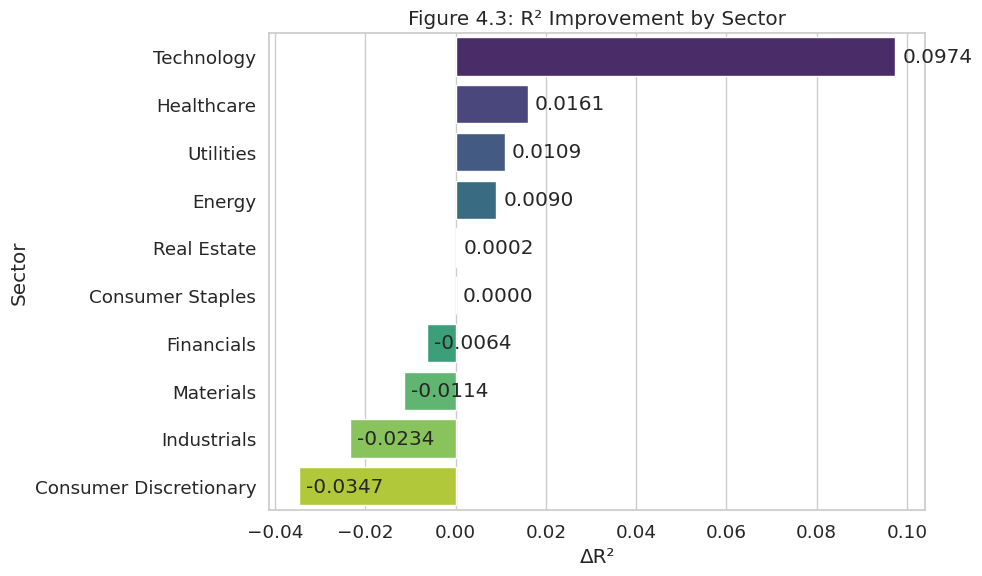

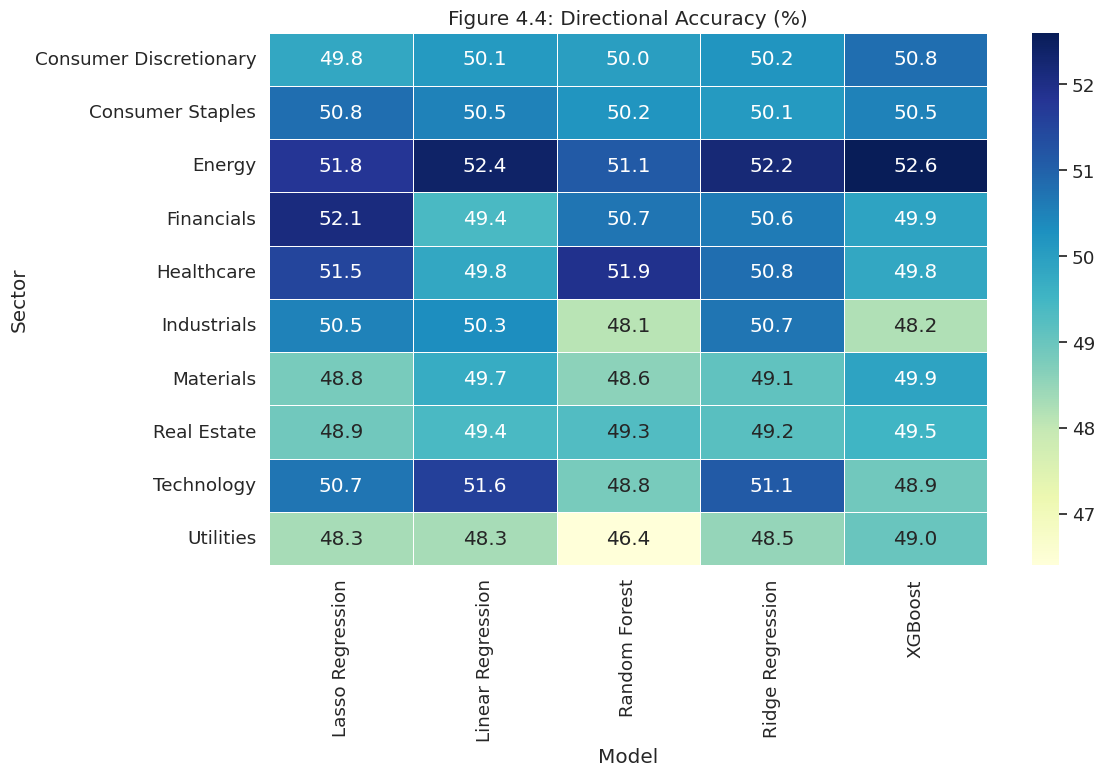

PLOTS SAVED in 'plots' folder (left sidebar)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# -------------------------------------------------
# CELL 1: Manual Browser Fix + Upload CSVs to Colab
# -------------------------------------------------
# STEP 1: Open Drive in browser (new tab)
# Go to: https://drive.google.com
# Search: sector_performance_comparison.csv
# Right-click file → Download
# Repeat for comprehensive_.

# STEP 2: Upload to Colab
from google.colab import files

print("Upload sector_performance_comparison.csv")
uploaded = files.upload()
sector_file = list(uploaded.keys())[0]  # Gets filename

print("Upload comprehensive_40_stocks_results.csv")
uploaded = files.upload()
comp_file = list(uploaded.keys())[0]

# Load uploaded
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

df_sector = pd.read_csv(sector_file)
df_comp = pd.read_csv(comp_file)

print("Sector loaded:")
display(df_sector.head())
print("Comprehensive loaded:")
display(df_comp.head())

# Create local plots folder
!mkdir plots
plots_dir = 'plots'

# Fig 4.3 Bar
df_sector['ΔR²'] = df_sector['R2_Sentiment'] - df_sector['R2_Original']
df_sector = df_sector.sort_values('ΔR²', ascending=False)

plt.figure(figsize=(10, 6))
bars = sns.barplot(x='ΔR²', y='Sector', data=df_sector, palette='viridis')
for bar in bars.patches:
    width = bar.get_width()
    bars.annotate(f'{width:.4f}', (width, bar.get_y() + bar.get_height()/2), ha='left', va='center', xytext=(5, 0), textcoords='offset points')
plt.title('Figure 4.3: R² Improvement by Sector')
plt.xlabel('ΔR²')
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'fig4_3_r2_improvement.png'), dpi=300, bbox_inches='tight')
plt.show()

# Fig 4.4 Heatmap
df_comp['Dir_Acc'] = df_comp['Direction_Accuracy_Sentiment'] * 100
pivot = df_comp.pivot_table(index='Sector', columns='Model', values='Dir_Acc', aggfunc='mean').round(1)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot, annot=True, fmt='.1f', cmap='YlGnBu', linewidths=0.5)
plt.title('Figure 4.4: Directional Accuracy (%)')
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'fig4_4_dir_heatmap.png'), dpi=300, bbox_inches='tight')
plt.show()

print("PLOTS SAVED in 'plots' folder (left sidebar)")

# Download plots
files.download('plots/fig4_3_r2_improvement.png')
files.download('plots/fig4_4_dir_heatmap.png')

In [ ]:
# COMPARE BASE vs SENTIMENT
import pandas as pd

base_files = [
    'fast_lstm_1_10.pkl', 'fast_lstm_11_20.pkl',
    'fast_lstm_21_30.pkl', 'fast_lstm_31_40.pkl'
]
sent_files = [
    'sentiment_lstm_1_10.pkl', 'sentiment_lstm_11_20.pkl',
    'sentiment_lstm_21_30.pkl', 'sentiment_lstm_31_40.pkl'
]

base, sent = {}, {}
for f in base_files:
    p = os.path.join(drive_data_dir, f)
    if os.path.exists(p):
        with open(p, 'rb') as pf: base.update(pickle.load(pf))
for f in sent_files:
    p = os.path.join(drive_data_dir, f)
    if os.path.exists(p):
        with open(p, 'rb') as pf: sent.update(pickle.load(pf))

comp = []
for t in stocks:
    if t in base and t in sent:
        b = base[t]; s = sent[t]
        comp.append({
            'Ticker': t,
            'R2_Base': b['R2'], 'R2_Sent': s['R2'],
            'Dir_Base': b['DirAcc'], 'Dir_Sent': s['DirAcc']
        })

df = pd.DataFrame(comp)
df['ΔR²'] = df['R2_Sent'] - df['R2_Base']
df['ΔDir'] = df['Dir_Sent'] - df['Dir_Base']

print(f"\nSENTIMENT IMPACT (n={len(df)}):")
print(f"ΔR²:  {df['ΔR²'].mean():+.4f}")
print(f"ΔDir: {df['ΔDir'].mean():+.2f}%")

df.to_csv(os.path.join(drive_data_dir, 'sentiment_impact.csv'), index=False)


SENTIMENT IMPACT (n=40):
ΔR²:  +0.0002
ΔDir: -0.33%
